In [1]:
!pip install -q optuna wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!wandb login $(cat drive/MyDrive/wandb/key.txt)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [1]:
import os
import math
import json
import random
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import amp
from tqdm import tqdm
from copy import deepcopy
from functools import partial
from dataclasses import dataclass
from collections import defaultdict, Counter
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
TIME_COL = 'Time'
ECG_SIGNAL_COL = 'ECG_II'
ART_SIGNAL_COL = 'ART_MBP'
BINNED_ART_COL = 'binned_art'
BASE_PATH = 'drive/MyDrive/data/ecg2bg'
DATA_PATH = 'drive/MyDrive/data/ecg2bg/vitlab_data'
BINNED_PATH = f'{DATA_PATH}/art_binned'
MERGED_PATH = f'{DATA_PATH}/merged'
NP_PATH = f'{DATA_PATH}/np'
WINDOWED_300_OFFSET_PT_PATH = f'{DATA_PATH}/windowed_300_offset'
NPZ_FORMAT_PATH = f'{DATA_PATH}/npz_format'
H5_FORMAT_PATH = 'drive/MyDrive/data/ecg2bg/early_dataset_segments3.h5'
caseid_to_idx_path = 'drive/MyDrive/data/ecg2bg/caseid_to_early_idx3.json'

SAMPLING_RATE = 500 # Htz
SECONDS_TO_SAMPLE = 1 / SAMPLING_RATE # 0.002
WINDOW_SECONDS = 60
WINDOW_SIZE = int(WINDOW_SECONDS * SAMPLING_RATE)
HORIZON_SECONDS = 90
HORIZON_SIZE = int(HORIZON_SECONDS * SAMPLING_RATE)
STRIDE_SEC = 5
STRIDE_SIZE = int(STRIDE_SEC * SAMPLING_RATE)
CONTEXT_CHUNK_SIZE = 16 # 16 time WINDOWSIZE = 16 min context

CLIP_LOWER = -5.0  # or based on 1st percentile of min_ECG_II
CLIP_UPPER = 5.0   # or based on 99th percentile of max_ECG_II
TRIM_SECONDS = 5

# Split constanst
MIN_TIME_DURATION = 600 # 10 minutes
MAX_TIME_DURATION = 10 * 60 * 60 # 10 hours
EARLY_EXP_MAX_TIME_DURATION = 24000 # 10 minutes
TIME_BINS_FOR_SPLIT = [600, 12000, 24000, np.inf]
LONG_OUTLINER_CASEID = '5534'
IOH_PERCENT_BINS = [0.0, 0.05, 0.1, 0.2, 0.4, 1.0]

IS_EARLY_EXP = True
if IS_EARLY_EXP:
  split_name = 'early_exp'
else:
  split_name = 'full_exp'

In [3]:
bins = [-np.inf, 55, 60, 65, 70, 100, np.inf]
labels = ['<55', '55-60', '60-65', '65-70', '70-100', '>100']
label_to_int = {label: i for i, label in enumerate(labels)}
int_to_label = {i: label for label, i in label_to_int.items()}

In [4]:
# Speedups
torch.backends.cudnn.benchmark = True         # fixed-size convs get autotuned
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('medium')  # Ampere+ (Colab T4/A100 vary)

In [8]:
# Copy data to local drive for faster IO during training
!cp {os.path.join(NP_PATH, "train_segments_part1.npy")} train_segments_part1.npy
!cp {os.path.join(NP_PATH, "train_segments_part2.npy")} train_segments_part2.npy

!sleep 5
!cp {os.path.join(NP_PATH, "test_segments_part1.npy")} test_segments_part1.npy
!cp {os.path.join(NP_PATH, "test_segments_part2.npy")} test_segments_part2.npy
# !cp {os.path.join(NP_PATH, "test_segments_part3.npy")} test_segments_part3.npy

!sleep 5
!cp {os.path.join(NP_PATH, "train_labels.npy")} train_labels.npy

!sleep 5
!cp {os.path.join(NP_PATH, "test_labels.npy")} test_labels.npy

# Setup code

## Eval Funcation

In [5]:
# Eval functions
def log_confmat_to_wandb(y_true_np, y_pred_np, class_names):
    cm = confusion_matrix(y_true_np, y_pred_np, labels=list(range(len(class_names))))
    wandb.log({
        "val/confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_true_np,
            preds=y_pred_np,
            class_names=class_names
        )
    })
    return cm

def accuracy_per_class(preds, labels, num_classes):
    from collections import defaultdict
    correct = defaultdict(int)
    total = defaultdict(int)

    preds = preds.view(-1).cpu()
    labels = labels.view(-1).cpu()

    for p, y in zip(preds, labels):
        total[int(y)] += 1
        if int(p) == int(y):
            correct[int(y)] += 1

    acc_dict = {}
    for cls in range(num_classes):
        if total[cls] > 0:
            acc_dict[cls] = correct[cls] / total[cls]
        else:
            acc_dict[cls] = float('nan')  # no samples
    return acc_dict, total

In [6]:
from contextlib import nullcontext
@torch.no_grad()
def evaluate_model(model, val_loader, num_classes, device, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    # if device.type == "cuda":
    #     ac = amp.autocast("cuda", dtype=torch.float16)
    # elif device.type == "cpu":
    #     ac = amp.autocast("cpu", dtype=torch.bfloat16)
    # else:
    #     ac = nullcontext()

    for signals, labels in tqdm(val_loader, desc=f"eval stage", leave=False):
        signals = signals.to(device, non_blocking=True)
        labels = torch.where(labels < 3, 1, 0)
        labels = labels.to(device, non_blocking=True)
        with amp.autocast('cuda', dtype=torch.float16):
          logits = model(signals)  # (B, T, num_classes)
          if num_classes == 1:
              loss = criterion(logits.view(-1).float(), labels.view(-1).float())
          else:
              loss = criterion(logits.view(-1, logits.shape[-1]), labels.view(-1))
          total_loss += loss.item()

        if num_classes == 1:
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().squeeze(-1)
        else:
            preds = torch.argmax(logits, dim=-1)
        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = torch.cat(all_preds, dim=0).reshape(-1)
    all_labels = torch.cat(all_labels, dim=0).reshape(-1)

    per_class_acc, class_counts = accuracy_per_class(all_preds, all_labels, num_classes)

    all_preds_np = all_preds.cpu().numpy()
    all_labels_np = all_labels.cpu().numpy()
    macro_f1 = f1_score(all_labels_np, all_preds_np, average='macro')
    avg_loss = total_loss / len(val_loader)

    return macro_f1, per_class_acc, avg_loss, all_labels_np, all_preds_np

In [7]:
@torch.no_grad()
def plot_confusion_matrix(model, dataloader, device, num_classes, label_names=None, normalize='true', return_probs=False):
    # (left as-is except we now actually return preds/labels; cm handled by helper above)
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_sub_labels =[]

    for signals, labels in tqdm(dataloader, desc='cm stage', leave=False):
        signals = signals.to(device)
        all_sub_labels.append(labels.cpu())
        labels = torch.where(labels < 3, 1, 0)
        labels = labels.to(device)

        logits = model(signals)
        if num_classes == 1:
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().squeeze(-1)
        else:
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        if return_probs:
            all_probs.append(probs.cpu())

    y_pred = torch.cat(all_preds, dim=0).numpy().reshape(-1)
    y_true = torch.cat(all_labels, dim=0).numpy().reshape(-1)
    y_sub_true = torch.cat(all_sub_labels, dim=0).numpy().reshape(-1)
    if return_probs:
        y_probs = torch.cat(all_probs, dim=0).numpy().reshape(-1, num_classes)
    cm = None
    if return_probs:
        return cm, y_pred, y_true, y_probs, y_sub_true
    return cm, y_pred, y_true

## Data

In [8]:
# A dataset after segmenting and resampling
class SplitDataset(Dataset):
    def __init__(self, segments_paths, labels_path):
        self.labels = np.load(labels_path)
        self.paths = segments_paths
        self.parts = None        # opened lazily in each worker
        self.lens = None
        self.cumsum = None
        self.total = None

    def _ensure_open(self):
        if self.parts is None:
            # this runs inside the worker process
            self.parts = [np.load(p, mmap_mode='r') for p in self.paths]
            self.lens = [part.shape[0] for part in self.parts]
            self.cumsum = np.cumsum([0] + self.lens)
            self.total = int(self.cumsum[-1])
            # assert len(self.labels) == self.total, "labels must match total segments"

    def __len__(self):
        self._ensure_open()
        return self.total

    def __getitem__(self, idx):
        self._ensure_open()
        part_idx = np.searchsorted(self.cumsum, idx, side='right') - 1
        local_idx = idx - self.cumsum[part_idx]
        seg = self.parts[part_idx][local_idx]
        x = torch.tensor(seg, dtype=torch.float32)
        y = torch.as_tensor(self.labels[idx], dtype=torch.long)
        return x, y


### Data augmentaions

In [9]:
class BatchAugmenter:
    """
    Probabilistic Mixup & TimeCutMix for CE classifiers.

    Usage:
      augmenter = BatchAugmenter(use_mixup=True, mixup_alpha=0.3, mixup_p=0.15,
                                 use_timecutmix=True, tcm_p=0.15, tcm_len_s=(0.5, 2.0),
                                 mutually_exclusive=True, fs=500)

      x_out, y_a, y_b, lam, aug_name, mixed_frac = augmenter(x, y)
      logits = model(x_out)
      loss = BatchAugmenter.ce_loss(logits, y_a, y_b, lam)

    Returns:
      x_out: augmented batch (same shape as x)
      y_a, y_b: paired labels (for mixed loss)
      lam: (B,) mixing weights (1 means no mix for that sample)
      aug_name: "mixup" | "timecutmix" | "none"
      mixed_frac: fraction of samples actually mixed in the batch
    """

    def __init__(self,
                 # Mixup
                 use_mixup=True, mixup_alpha=0.3, mixup_p=0.15, mixup_per_sample=False,
                 # TimeCutMix
                 use_timecutmix=True, tcm_p=0.15, tcm_len_s=(0.5, 2.0), tcm_per_sample=False,
                 # Strategy
                 mutually_exclusive=True,
                 # Signal params
                 fs=500,
                 # Loss params
                 label_smoothing=0.0):
        self.use_mixup = use_mixup
        self.mixup_alpha = mixup_alpha
        self.mixup_p = mixup_p
        self.mixup_per_sample = mixup_per_sample

        self.use_tcm = use_timecutmix
        self.tcm_p = tcm_p
        self.tcm_len_s = tcm_len_s
        self.tcm_per_sample = tcm_per_sample

        self.mutually_exclusive = mutually_exclusive
        self.fs = fs
        self.label_smoothing = label_smoothing

    # ------------ internals ------------
    def _mixup(self, x, y, alpha, p, per_sample):
        B = x.size(0); device = x.device
        if B < 2:
            lam = torch.ones(B, device=device)
            return x, y, y, lam, 0.0

        idx = torch.randperm(B, device=device)
        lam = torch.distributions.Beta(alpha, alpha).sample((B,)).to(device)
        lam = torch.maximum(lam, 1 - lam)  # symmetry

        if per_sample:
            m = (torch.rand(B, device=device) < p).float()
            lam = lam * m + (1 - m)          # if not selected -> lam=1 (no-op)
        else:
            if random.random() >= p:         # batch-level gate
                lam = torch.ones(B, device=device)

        view = (B, *([1] * (x.dim() - 1)))
        x_out = lam.view(*view) * x + (1 - lam).view(*view) * x[idx]
        mixed_frac = float((lam < 1).float().mean().item())
        return x_out, y, y[idx], lam, mixed_frac

    def _timecutmix(self, x, y, p, len_s, per_sample):
        B = x.size(0); T = x.shape[-1]; device = x.device
        if B < 2:
            lam = torch.ones(B, device=device)
            return x, y, y, lam, 0.0

        idx = torch.randperm(B, device=device)

        if not per_sample:
            if random.random() >= p:
                return x, y, y, torch.ones(B, device=device), 0.0
            L = int(random.uniform(*len_s) * self.fs); L = max(1, min(L, T-1))
            s = random.randint(0, T - L)
            x2 = x.clone()
            x2[..., s:s+L] = x[idx, ..., s:s+L]
            lam = torch.full((B,), 1 - L / float(T), device=device)
            return x2, y, y[idx], lam, 1.0

        # per-sample gate
        m = (torch.rand(B, device=device) < p)
        if not m.any():
            return x, y, y, torch.ones(B, device=device), 0.0

        x2 = x.clone()
        lam = torch.ones(B, device=device)
        for i in torch.nonzero(m, as_tuple=False).view(-1):
            j = idx[i].item()
            L = int(random.uniform(*len_s) * self.fs); L = max(1, min(L, T-1))
            s = random.randint(0, T - L)
            x2[i, ..., s:s+L] = x[j, ..., s:s+L]
            lam[i] = 1 - L / float(T)
        mixed_frac = float((lam < 1).float().mean().item())
        return x2, y, y[idx], lam, mixed_frac

    def __call__(self, x, y):
        """
        x: (B,T) or (B,C,T)
        y: (B,) class indices (long)
        """
        if self.mutually_exclusive and self.use_tcm and self.use_mixup:
            r = random.random()
            if r < self.tcm_p:
                x, y_a, y_b, lam, frac = self._timecutmix(
                    x, y, p=self.tcm_p if self.tcm_per_sample else 1.0,
                    len_s=self.tcm_len_s, per_sample=self.tcm_per_sample
                )
                aug = "timecutmix" if (lam < 1).any() else "none"
                return x, y_a, y_b, lam,aug, frac
            elif r < self.tcm_p + self.mixup_p:
                x, y_a, y_b, lam, frac = self._mixup(
                    x, y, alpha=self.mixup_alpha,
                    p=self.mixup_p if self.mixup_per_sample else 1.0,
                    per_sample=self.mixup_per_sample
                )
                aug = "mixup" if (lam < 1).any() else "none"
                return x, y_a, y_b, lam, aug, frac
            else:
                return x, y, y, torch.ones(x.size(0), device=x.device), "none", 0.0

        # independent gates (may apply none, one, or both in sequence)
        applied = "none"; frac = 0.0
        y_a = y; y_b = y
        lam = torch.ones(x.size(0), device=x.device)

        if self.use_tcm:
            x, y_a, y_b, lam, frac_t = self._timecutmix(x, y, p=self.tcm_p, len_s=self.tcm_len_s, per_sample=self.tcm_per_sample)
            if (lam < 1).any(): applied, frac = "timecutmix", max(frac, frac_t)

        if self.use_mixup:
            x, y_a, y_b, lam_mu, frac_m = self._mixup(x, y_a, alpha=self.mixup_alpha, p=self.mixup_p, per_sample=self.mixup_per_sample)
            if (lam_mu < 1).any(): applied, frac = "mixup", max(frac, frac_m)
            lam = lam_mu  # use last non-trivial lam

        return x, y_a, y_b, lam, applied, frac

    def ce_loss(self, logits, y_a, y_b, lam, sample_weights=None):
        """
        Mixed CE loss if any lam<1 else plain CE.
        Supports logits of shape (B,C) or (B,T,C).
        """
        if logits.dim() == 3:  # (B,T,C)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            y_a = y_a.view(-1)
            y_b = y_b.view(-1)
            lam = lam.view(-1).repeat_interleave(T)
            if sample_weights is not None:
                sample_weights = sample_weights.view(-1).repeat_interleave(T)

        ce_none = partial(F.cross_entropy, label_smoothing=self.label_smoothing, reduction="none")

        if torch.all(lam == 1):
            loss = ce_none(logits, y_a)
            if sample_weights is not None: loss = loss * sample_weights
            return loss.mean()

        loss_a = ce_none(logits, y_a)  # (N,)
        loss_b = ce_none(logits, y_b)  # (N,)
        loss = lam * loss_a + (1 - lam) * loss_b
        if sample_weights is not None: loss = loss * sample_weights
        return loss.mean()


In [25]:
import random
import torch
import torch.nn.functional as F
from functools import partial
from typing import Iterable, Tuple, Set, Dict, List

class ConditionalPairAugmenter:
    """
    Same API as BatchAugmenter, but only pairs samples whose (y[i], y[j]) is in allowed_pairs.
    Works with y of shape (B,) or (B, ...). If multi-dim, a per-sample primary label is computed
    (mode over all positions) on GPU.

    Returns:
      x_out, y_a, y_b, lam, aug_name, mixed_frac
    """

    def __init__(self,
                 allowed_pairs: Iterable[Tuple[int, int]],
                 # Mixup
                 use_mixup: bool = True, mixup_alpha: float = 0.3, mixup_p: float = 0.15, mixup_per_sample: bool = False,
                 # TimeCutMix
                 use_timecutmix: bool = True, tcm_p: float = 0.15, tcm_len_s: Tuple[float, float] = (0.5, 2.0), tcm_per_sample: bool = False,
                 # Strategy
                 mutually_exclusive: bool = True,
                 # Signal params
                 fs: int = 500,
                 # Loss params
                 label_smoothing: float = 0.0,
                 # partner search
                 partner_resample_tries: int = 8):
        self.allowed_pairs: Set[Tuple[int, int]] = set(allowed_pairs)

        # Precompute map: src_class -> list[target_classes]
        targets: Dict[int, List[int]] = {}
        for c1, c2 in self.allowed_pairs:
            targets.setdefault(int(c1), []).append(int(c2))
        self.allowed_targets: Dict[int, List[int]] = targets

        self.use_mixup = use_mixup
        self.mixup_alpha = mixup_alpha
        self.mixup_p = mixup_p
        self.mixup_per_sample = mixup_per_sample

        self.use_tcm = use_timecutmix
        self.tcm_p = tcm_p
        self.tcm_len_s = tcm_len_s
        self.tcm_per_sample = tcm_per_sample

        self.mutually_exclusive = mutually_exclusive
        self.fs = fs
        self.label_smoothing = label_smoothing
        self.partner_resample_tries = partner_resample_tries

    # ---------- helpers ----------
    def _primary_per_sample(self, y: torch.Tensor) -> torch.Tensor:
        """
        y: (B,) or (B, ...). Returns (B,) long primary label per sample.
        If multi-dim, takes per-sample mode on GPU.
        """
        if y.dim() == 1:
            return y.long()
        B = y.shape[0]
        yf = y.view(B, -1).long()
        primary = torch.empty(B, dtype=torch.long, device=y.device)
        # Loop over B (small), stays on GPU
        for i in range(B):
            vals, counts = torch.unique(yf[i], return_counts=True)
            primary[i] = vals[counts.argmax()]
        return primary

    def _build_idx_with_constraints(self, y: torch.Tensor) -> torch.Tensor:
        """
        Build partner index vector idx (B,) such that for each i,
        (primary[i], primary[idx[i]]) is in allowed_pairs if possible; else idx[i]=i.
        Torch-only, no CPU/NumPy conversion.
        """
        device = y.device
        primary = self._primary_per_sample(y)           # (B,)
        B = primary.size(0)

        # pools per class (on device)
        classes = torch.unique(primary)
        pools: Dict[int, torch.Tensor] = {int(c.item()): torch.where(primary == c)[0] for c in classes}

        idx = torch.arange(B, device=device)            # default self-pair (no-op)
        for i in range(B):
            ci = int(primary[i].item())
            targets = self.allowed_targets.get(ci, None)
            if not targets:
                continue
            # try a few times to avoid self-pair or empty pools
            ok = False
            for _ in range(self.partner_resample_tries):
                c2 = random.choice(targets)
                pool = pools.get(c2, None)
                if pool is None or pool.numel() == 0:
                    continue
                j = int(pool[torch.randint(pool.numel(), (1,), device=device)].item())
                if j != i:
                    idx[i] = j
                    ok = True
                    break
            # else keep self (no-op)
        return idx

    # --- Mixup & TCM using constrained idx ---
    def _mixup(self, x, y, alpha, p, per_sample):
        B = x.size(0); device = x.device
        if B < 2:
            lam = torch.ones(B, device=device)
            return x, y, y, lam, 0.0

        idx = self._build_idx_with_constraints(y)
        lam = torch.distributions.Beta(alpha, alpha).sample((B,)).to(device)
        lam = torch.maximum(lam, 1 - lam)  # symmetry

        if per_sample:
            m = (torch.rand(B, device=device) < p).float()
            lam = lam * m + (1 - m)        # not selected → lam=1
        else:
            if random.random() >= p:
                lam = torch.ones(B, device=device)

        view = (B, *([1] * (x.dim() - 1)))
        x_out = lam.view(*view) * x + (1 - lam).view(*view) * x[idx]
        mixed_frac = float((lam < 1).float().mean().item())
        return x_out, y, y[idx], lam, mixed_frac

    def _timecutmix(self, x, y, p, len_s, per_sample):
        B = x.size(0); T = x.shape[-1]; device = x.device
        if B < 2:
            lam = torch.ones(B, device=device)
            return x, y, y, lam, 0.0

        idx = self._build_idx_with_constraints(y)

        if not per_sample:
            if random.random() >= p:
                return x, y, y, torch.ones(B, device=device), 0.0
            L = int(random.uniform(*len_s) * self.fs); L = max(1, min(L, T-1))
            s = random.randint(0, T - L)
            x2 = x.clone()
            x2[..., s:s+L] = x[idx, ..., s:s+L]
            lam = torch.full((B,), 1 - L / float(T), device=device)
            return x2, y, y[idx], lam, 1.0

        # per-sample gate
        m = (torch.rand(B, device=device) < p)
        if not m.any():
            return x, y, y, torch.ones(B, device=device), 0.0

        x2 = x.clone()
        lam = torch.ones(B, device=device)
        for i in torch.nonzero(m, as_tuple=False).view(-1):
            j = int(idx[i])
            if j == i:  # no valid partner → skip
                continue
            L = int(random.uniform(*len_s) * self.fs); L = max(1, min(L, T-1))
            s = random.randint(0, T - L)
            x2[i, ..., s:s+L] = x[j, ..., s:s+L]
            lam[i] = 1 - L / float(T)
        mixed_frac = float((lam < 1).float().mean().item())
        return x2, y, y[idx], lam, mixed_frac

    # ---------- public API (identical to BatchAugmenter) ----------
    def __call__(self, x, y):
        """
        x: (B,T) or (B,C,T)
        y: (B,) class ids or (B, ...) dense labels
        """
        if self.mutually_exclusive and self.use_tcm and self.use_mixup:
            r = random.random()
            if r < self.tcm_p:
                x, y_a, y_b, lam, frac = self._timecutmix(
                    x, y, p=self.tcm_p if self.tcm_per_sample else 1.0,
                    len_s=self.tcm_len_s, per_sample=self.tcm_per_sample
                )
                aug = "timecutmix" if (lam < 1).any() else "none"
                return x, y_a, y_b, lam, aug, frac
            elif r < self.tcm_p + self.mixup_p:
                x, y_a, y_b, lam, frac = self._mixup(
                    x, y, alpha=self.mixup_alpha,
                    p=self.mixup_p if self.mixup_per_sample else 1.0,
                    per_sample=self.mixup_per_sample
                )
                aug = "mixup" if (lam < 1).any() else "none"
                return x, y_a, y_b, lam, aug, frac
            else:
                return x, y, y, torch.ones(x.size(0), device=x.device), "none", 0.0

        # independent gates
        applied = "none"; frac = 0.0
        y_a = y; y_b = y
        lam = torch.ones(x.size(0), device=x.device)

        if self.use_tcm:
            x, y_a, y_b, lam_t, frac_t = self._timecutmix(x, y, p=self.tcm_p, len_s=self.tcm_len_s, per_sample=self.tcm_per_sample)
            if (lam_t < 1).any(): applied, frac = "timecutmix", max(frac, frac_t)
            lam = lam_t

        if self.use_mixup:
            x, y_a, y_b, lam_m, frac_m = self._mixup(x, y_a, alpha=self.mixup_alpha, p=self.mixup_p, per_sample=self.mixup_per_sample)
            if (lam_m < 1).any(): applied, frac = "mixup", max(frac, frac_m)
            lam = lam_m

        return x, y_a, y_b, lam, applied, frac

    # Same CE mixing as BatchAugmenter
    def ce_loss(self, logits, y_a, y_b, lam, sample_weights=None):
        if logits.dim() == 3:  # (B,T,C)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            y_a = y_a.view(-1)
            y_b = y_b.view(-1)
            lam = lam.view(-1).repeat_interleave(T)
            if sample_weights is not None:
                sample_weights = sample_weights.view(-1).repeat_interleave(T)

        ce_none = partial(F.cross_entropy, label_smoothing=self.label_smoothing, reduction="none")

        if torch.all(lam == 1):
            loss = ce_none(logits, y_a)
            if sample_weights is not None: loss = loss * sample_weights
            return loss.mean()

        loss_a = ce_none(logits, y_a)
        loss_b = ce_none(logits, y_b)
        loss = lam * loss_a + (1 - lam) * loss_b
        if sample_weights is not None: loss = loss * sample_weights
        return loss.mean()


In [11]:
class ECGAug:
    def __init__(self,
                 p_jitter=0.4, sigma_rel=(0.005, 0.02),    # smaller noise
                 p_gain=0.5,  gain_range=(0.95, 1.05),     # tighter gain
                 p_shift=0.4, max_shift_ms=10, fs=500,     # <= ±10 ms
                 p_mask=0.25, n_masks=(0,2), mask_ms=(10,40),
                 p_wander=0.2, wander_hz=(0.05, 0.5), wander_amp_rel=(0.005, 0.015),
                 p_hum=0.2, hum_hz=50.0, hum_amp_rel=(0.002, 0.008)):
        self.p_jitter, self.sigma_rel = p_jitter, sigma_rel
        self.p_gain, self.gain_range = p_gain, gain_range
        self.p_shift, self.fs = p_shift, fs
        self.max_shift = int(max_shift_ms * fs / 1000)
        self.p_mask, self.n_masks, self.mask_ms = p_mask, n_masks, mask_ms
        self.p_wander, self.wander_hz, self.wander_amp_rel = p_wander, wander_hz, wander_amp_rel
        self.p_hum, self.hum_hz, self.hum_amp_rel = p_hum, hum_hz, hum_amp_rel

    def _bandlimit(self, noise: torch.Tensor, lp_hz=100):
        # quick low-pass: 9-tap Hann moving average
        k = torch.hann_window(9, periodic=False, device=noise.device).unsqueeze(0).unsqueeze(0)
        k = k / k.sum()
        return F.conv1d(noise[None,None,:], k, padding=4).squeeze()

    def __call__(self, x: torch.Tensor):
        # x: (T,) or (C,T). Use SAME params across channels.
        if x.dim() == 1:
            X = x.unsqueeze(0)   # (1,T)
        else:
            X = x

        T = X.size(-1)
        y = X.clone()

        # choose all random params once (shared across channels)
        std_ref = X.std(dim=-1, keepdim=True).mean().item() + 1e-8

        # jitter (band-limited)
        if random.random() < self.p_jitter:
            sigma = random.uniform(*self.sigma_rel) * std_ref
            n = torch.randn(T, device=y.device) * sigma
            n = self._bandlimit(n)
            y = y + n

        # gain
        if random.random() < self.p_gain:
            gain = random.uniform(*self.gain_range)
            y = y * gain

        # small time shift (circular; tiny so it won’t matter at ends)
        if random.random() < self.p_shift and self.max_shift > 0:
            k = random.randint(-self.max_shift, self.max_shift)
            if k != 0:
                y = torch.roll(y, shifts=k, dims=-1)

        # time masking: short, fill with local mean + noise (no hard zeros)
        if random.random() < self.p_mask:
            m = random.randint(*self.n_masks)
            for _ in range(m):
                w = int(random.uniform(*self.mask_ms) * 1e-3 * self.fs)
                if w <= 0 or w >= T: continue
                s = random.randint(0, T - w)
                seg = y[..., max(0, s-5):min(T, s+w+5)]
                mu = seg.mean(dim=-1, keepdim=True)
                noise = (torch.randn_like(y[..., s:s+w]) * 0.02 * std_ref)
                y[..., s:s+w] = mu + noise

        # baseline wander (tiny, random phase)
        if random.random() < self.p_wander:
            f = random.uniform(*self.wander_hz)
            amp = random.uniform(*self.wander_amp_rel) * std_ref
            phi = random.uniform(0, 2*math.pi)
            t = torch.arange(T, device=y.device) / self.fs
            y = y + amp * torch.sin(2*math.pi*f*t + phi)

        # powerline hum (tiny, random phase + slight detune)
        if random.random() < self.p_hum:
            amp = random.uniform(*self.hum_amp_rel) * std_ref
            f = self.hum_hz + random.uniform(-0.3, 0.3)
            phi = random.uniform(0, 2*math.pi)
            t = torch.arange(T, device=y.device) / self.fs
            y = y + amp * torch.sin(2*math.pi*f*t + phi)

        return y.squeeze(0) if x.dim() == 1 else y


### Augmentation Anneal

In [12]:
@dataclass
class AnnealConfig:
    # final multipliers reached at the LAST epoch (1.0 = no anneal)
    ps_strength_scale: float = 0.5   # ECGAug strengths (sigma_rel, wander_amp_rel)
    ps_prob_scale: float = 0.6   # ECGAug probs (p_jitter, p_wander, p_mask, p_shift)
    ba_mixup_scale: float = 0.6   # BatchAugmenter mixup (alpha & p)
    ba_tcm_scale: float = 0.6   # BatchAugmenter timecutmix prob
    schedule: str = "linear"   # or "cosine"

def _phase(epoch: int, num_epochs: int) -> float:
    return 0.0 if num_epochs <= 1 else (epoch - 1) / (num_epochs - 1)

def _interp(a: float, b: float, t: float, schedule: str = "linear") -> float:
    if schedule == "cosine":
        w = 0.5 * (1 - math.cos(math.pi * t))  # 0→1 smooth
        return a + (b - a) * w
    return a + (b - a) * t  # linear

def _interp_pair(tup, scale, t, schedule):
    lo, hi = tup
    return (_interp(lo, lo*scale, t, schedule), _interp(hi, hi*scale, t, schedule))


In [13]:
# Capture bases
def _capture_aug_bases(augmenter, per_sample_aug):
    ps_base, ba_base = None, None
    if per_sample_aug is not None:
        ps_base = {
            "sigma_rel": tuple(per_sample_aug.sigma_rel),
            "wander_amp_rel": tuple(per_sample_aug.wander_amp_rel),
            "p_jitter": float(per_sample_aug.p_jitter),
            "p_wander": float(per_sample_aug.p_wander),
            "p_mask": float(per_sample_aug.p_mask),
            "p_shift": float(per_sample_aug.p_shift),
        }
    if augmenter is not None:
        ba_base = {
            "mixup_alpha": float(getattr(augmenter, "mixup_alpha", 0.0)),
            "mixup_p": float(getattr(augmenter, "mixup_p", 0.0)),
            "tcm_p": float(getattr(augmenter, "tcm_p", 0.0)),
        }
    return ps_base, ba_base

In [14]:
def _apply_anneal(per_sample_aug, augmenter, ps_base, ba_base, cfg: AnnealConfig, t):
    if ps_base is not None and per_sample_aug is not None:
        per_sample_aug.sigma_rel = _interp_pair(ps_base["sigma_rel"], cfg.ps_strength_scale, t, cfg.schedule)
        per_sample_aug.wander_amp_rel = _interp_pair(ps_base["wander_amp_rel"], cfg.ps_strength_scale, t, cfg.schedule)
        per_sample_aug.p_jitter = _interp(ps_base["p_jitter"], ps_base["p_jitter"] * cfg.ps_prob_scale, t, cfg.schedule)
        per_sample_aug.p_wander = _interp(ps_base["p_wander"], ps_base["p_wander"] * cfg.ps_prob_scale, t, cfg.schedule)
        per_sample_aug.p_mask = _interp(ps_base["p_mask"], ps_base["p_mask"] * cfg.ps_prob_scale, t, cfg.schedule)
        per_sample_aug.p_shift = _interp(ps_base["p_shift"], ps_base["p_shift"]  * cfg.ps_prob_scale, t, cfg.schedule)

    if ba_base is not None and augmenter is not None:
        augmenter.mixup_alpha = _interp(ba_base["mixup_alpha"], ba_base["mixup_alpha"] * cfg.ba_mixup_scale, t, cfg.schedule)
        augmenter.mixup_p = _interp(ba_base["mixup_p"], ba_base["mixup_p"] * cfg.ba_mixup_scale, t, cfg.schedule)
        augmenter.tcm_p = _interp(ba_base["tcm_p"], ba_base["tcm_p"] * cfg.ba_tcm_scale, t, cfg.schedule)


## Training Pipeline

In [15]:
# W&B
def _init_wandb(use_wandb, project, run_name, entity, resume, model,
                watch_gradients, base_cfg, augmenter, per_sample_aug):
    if not use_wandb:
        return
    wb_cfg = dict(base_cfg)
    wb_cfg["batch_augmenter"] = bool(augmenter)
    wb_cfg["per_sample_aug"]  = bool(per_sample_aug)
    if augmenter is not None:
        for k in ["mutually_exclusive","mixup_alpha","mixup_p",
                  "mixup_per_sample","tcm_p","tcm_len_s","tcm_per_sample"]:
            if hasattr(augmenter, k):
                wb_cfg[f"aug/{k}"] = getattr(augmenter, k)
    wandb.init(project=project, name=run_name, entity=entity, resume=resume, config=wb_cfg)
    if watch_gradients:
        wandb.watch(model, log="gradients", log_freq=100)


In [16]:
def _forward_and_loss(model, signals, labels, num_classes, criterion, augmenter,
                      subcat=None, is_sample_weight=False):
    if is_sample_weight and subcat is not None:
        sw = torch.ones_like(labels, device=device, dtype=torch.float32)
        focus_mask = (subcat == 1) | (subcat == 2)
        sw = torch.where(focus_mask, torch.full_like(sw, 2.0), sw)
    else:
        sw = None

    if augmenter is not None and num_classes != 1:
        if isinstance(augmenter, ConditionalPairAugmenter) and (subcat is not None):
            B = signals.size(0)
            subcat = subcat.view(B, -1).long()
            signals, y_a, y_b, lam, aug_name, mixed_frac = augmenter(signals, subcat)
        elif isinstance(augmenter, BatchAugmenter):
            signals, y_a, y_b, lam, aug_name, mixed_frac = augmenter(signals, labels)
        else:
            raise ValueError(f"Unknown augmenter type: {type(augmenter)}")

        logits = model(signals)
        loss = augmenter.ce_loss(logits, y_a, y_b, lam, sample_weights=sw)
        meta = {"aug_name": aug_name, "mixed_frac": mixed_frac}
    else:
        warnings.warn("No sample weight is applied")
        logits = model(signals)
        if num_classes == 1:
            loss = criterion(logits.view(-1).float(), labels.view(-1).float())
        else:
            loss = criterion(logits.view(-1, logits.shape[-1]), labels.view(-1))
        meta = {"aug_name": "none", "mixed_frac": 0.0}
    return loss, logits, meta


In [17]:
def _log_epoch(use_wandb, epoch, optimizer, avg_train_loss, val_loss, val_macro_f1,
               val_per_class, class_names, y_true_np, y_pred_np,
               aug_counts, mixed_frac_sum, n_batches,
               per_sample_aug, augmenter, phase):
    if not use_wandb:
        return
    per_class_log = {f"val/acc_class_{cls}": acc for cls, acc in val_per_class.items()}
    pred_pos_pct = float((y_pred_np == 1).mean())
    payload = {
        "train/loss": avg_train_loss,
        "val/loss": val_loss,
        "val/macro_f1": val_macro_f1,
        "pred/pos_pct"" ": pred_pos_pct,
        "lr": optimizer.param_groups[0]["lr"],
        "anneal/phase": phase,
        **per_class_log
    }
    if augmenter is not None:
        payload.update({
            "aug/avg_mixed_frac": mixed_frac_sum / max(1, n_batches),
            "aug/batches_mixup": aug_counts.get("mixup", 0),
            "aug/batches_tcm": aug_counts.get("timecutmix", 0),
            "aug/batches_none": aug_counts.get("none", 0),
            "aug_ba/mixup_alpha": getattr(augmenter, "mixup_alpha", 0.0),
            "aug_ba/mixup_p": getattr(augmenter, "mixup_p", 0.0),
            "aug_ba/tcm_p": getattr(augmenter, "tcm_p", 0.0),
        })
    if per_sample_aug is not None:
        payload.update({
            "aug_ps/p_jitter": getattr(per_sample_aug, "p_jitter", 0.0),
            "aug_ps/p_wander": getattr(per_sample_aug, "p_wander", 0.0),
            "aug_ps/p_mask": getattr(per_sample_aug, "p_mask",   0.0),
            "aug_ps/p_shift": getattr(per_sample_aug, "p_shift",  0.0),
            "aug_ps/sigma_lo": getattr(per_sample_aug, "sigma_rel", (0,0))[0],
            "aug_ps/sigma_hi": getattr(per_sample_aug, "sigma_rel", (0,0))[1],
        })
    wandb.log(payload, step=epoch)

In [18]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: p.detach().clone()
                       for k,p in model.state_dict().items()
                       if p.dtype.is_floating_point}
    @torch.no_grad()
    def update(self, model):
        for k,p in model.state_dict().items():
            if k in self.shadow:
                self.shadow[k].mul_(self.decay).add_(p.detach(), alpha=1-self.decay)
    @torch.no_grad()
    def store(self, model): self.backup = {k: p.detach().clone() for k,p in model.state_dict().items()}
    @torch.no_grad()
    def copy_to(self, model): model.load_state_dict({**model.state_dict(), **self.shadow})
    @torch.no_grad()
    def restore(self, model): model.load_state_dict(self.backup)


def _save_with_ema(model, path, ema):
    ema.store(model); ema.copy_to(model)
    torch.save(model.state_dict(), path)
    ema.restore(model)

In [19]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs,
    num_classes,
    patience=20,
    save_dir="./checkpoints",
    model_name="model",
    scheduler=None,
    scheduler_mode="max",
    # wandb
    use_wandb=True,
    project="ecg-ioh",
    run_name=None,
    entity=None,
    class_names=None,
    log_cm_every=1,
    watch_gradients=True,
    resume="allow",
    config_extra=None,
    augmenter=None,
    per_sample_aug=None,
    anneal: AnnealConfig=None,
    sample_weight=False,
    is_ema=False,
    eval_every=1,
):
    os.makedirs(save_dir, exist_ok=True)

    if class_names is None:
        class_names = [str(i) for i in range(max(2, num_classes))]

    # init wandb
    base_cfg = {"epochs": num_epochs, "num_classes": num_classes,
                "patience": patience, "scheduler_mode": scheduler_mode,
                **(config_extra or {})}
    _init_wandb(use_wandb, project, run_name, entity, resume, model, watch_gradients,
                base_cfg, augmenter, per_sample_aug)

    scaler = amp.GradScaler('cuda', enabled=torch.cuda.is_available())
    ps_base, ba_base = _capture_aug_bases(augmenter, per_sample_aug)
    best_val_macro_f1, best_epoch, best_model_state = 0.0, 0, None
    no_improve_epochs = 0
    t = 0.0
    loss_history, val_accuracies, val_loss_history, val_per_class_history, lr_hist = [], [], [], [], []

    if is_ema:
      steps_per_epoch = max(1, len(train_loader))
      half_life_epochs = 2.0
      ema_decay = 0.5 ** (1.0 / (half_life_epochs * steps_per_epoch))  # e.g., ~0.999
      ema = EMA(model, decay=ema_decay)


    for epoch in range(1, num_epochs + 1):
        model.train()
        # anneal current
        if anneal is not None:
            t = _phase(epoch, num_epochs)
            _apply_anneal(per_sample_aug, augmenter, ps_base, ba_base, anneal, t)

        aug_counts = {"mixup": 0, "timecutmix": 0, "none": 0}
        mixed_frac_sum, total_loss, n_batches =  0.0, 0.0, 0

        with tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False) as train_bar:
          for signals, labels in train_bar:
              # map labels once and move to device
              subcat = labels.clone().to(device)
              labels = torch.where(labels < 3, 1, 0).long().to(device, non_blocking=True)
              signals = signals.to(device, non_blocking=True)

              if per_sample_aug is not None:
                with torch.no_grad():
                  signals = torch.stack([per_sample_aug(s) for s in signals], dim=0)
                  signals = signals.contiguous()


              optimizer.zero_grad(set_to_none=True)
              with amp.autocast('cuda', dtype=torch.float16):
                loss, logits, meta = _forward_and_loss(model,
                                                       signals,
                                                       labels,
                                                       num_classes,
                                                       criterion,
                                                       augmenter,
                                                       subcat=subcat,
                                                       is_sample_weight=sample_weight)


              scaler.scale(loss).backward()
              scaler.unscale_(optimizer) # unscale BEFORE clipping
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              scaler.step(optimizer)
              scaler.update()
              if is_ema:
                ema.update(model)

              total_loss += loss.item()
              if augmenter is not None:
                    aug_counts[meta["aug_name"]] = aug_counts.get(meta["aug_name"], 0) + 1
                    mixed_frac_sum += float(meta["mixed_frac"])
                    n_batches += 1

              train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / max(1, len(train_loader))
        loss_history.append(avg_train_loss)

        # ---- evaluation ----
        if (epoch % eval_every) != 0:
            continue

        model.eval()
        if is_ema:
          ema.store(model)
          ema.copy_to(model)
        val_macro_f1, val_per_class, val_loss, y_true_np, y_pred_np = evaluate_model(
            model, val_loader, num_classes, device, criterion
        )
        if is_ema:
          ema.restore(model)
        val_accuracies.append(val_macro_f1)
        val_per_class_history.append(val_per_class)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, Val macro_f1 = {val_macro_f1:.4f}")
        for cls, acc in val_per_class.items():
            print(f"  Class {cls} Accuracy: {acc:.2%}")

        # wandb logging per epoch
        _log_epoch(use_wandb, epoch, optimizer, avg_train_loss, val_loss, val_macro_f1,
                   val_per_class, class_names, y_true_np, y_pred_np,
                   aug_counts, mixed_frac_sum, n_batches,
                   per_sample_aug, augmenter, t)
        if use_wandb and is_ema:
          wandb.config.update({"ema_decay": ema.decay}, allow_val_change=True)



        # Checkpoint (latest)
        latest_path = os.path.join(save_dir, f"latest_{model_name}.pt")
        if is_ema:
            _save_with_ema(model, latest_path, ema)
        else:
            torch.save(model.state_dict(), latest_path)

        # Checkpoint (best) + artifact
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            best_epoch = epoch
            best_model_state = deepcopy(model.state_dict())
            best_path = os.path.join(save_dir, f"best_{model_name}.pt")
            if is_ema:
                _save_with_ema(model, best_path, ema)
            else:
                torch.save(model.state_dict(), best_path)
            no_improve_epochs = 0

            if use_wandb:
                wandb.run.summary["best_val_macro_f1"] = best_val_macro_f1
                wandb.run.summary["best_epoch"] = best_epoch
                art = wandb.Artifact(f"{model_name}-weights", type="model")
                art.add_file(best_path)
                wandb.log_artifact(art, aliases=["best", f"epoch-{epoch}"])
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"⏹️ Early stopping at epoch {epoch} after {patience} epochs without improvement.")
                break

        # Scheduler step
        if scheduler is not None:
            if scheduler_mode == "max":
                scheduler.step(val_macro_f1)
            elif scheduler_mode == "min":
                scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"📉 Learning Rate: {current_lr:.6f}")
        lr_hist.append(current_lr)

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    if use_wandb:
        wandb.finish()

    return model, {
        "train_loss": loss_history,
        "val_loss": val_loss_history,
        "val_accuracy": val_accuracies,
        "val_per_class": val_per_class_history,
        "best_epoch": best_epoch,
        "best_val_acc": best_val_macro_f1,
        "lr_history": lr_hist
    }


#### Unit Tests

In [20]:
!pip install pytest pytest-mock --quiet

In [21]:
# import torch
# import torch.nn as nn
# import warnings
# import pytest

# # ---- Mock definitions ----
# class DummyModel(nn.Module):
#     def __init__(self, num_classes=2):
#         super().__init__()
#         self.fc = nn.Linear(10, num_classes)

#     def forward(self, x):
#         return self.fc(x)

# class DummyAugmenter:
#     def __call__(self, signals, labels):
#         B = signals.size(0)
#         return signals, labels, labels, 1.0, "mixup", 0.5
#     def ce_loss(self, logits, y_a, y_b, lam, sample_weights=None):
#         return torch.tensor(1.23, requires_grad=True)


# # ---- Unit tests ----
# def test_with_augmenter():
#     model = DummyModel(2)
#     signals = torch.randn(4, 10)
#     labels = torch.tensor([0, 1, 0, 1])
#     subcat = torch.tensor([0, 1, 2, 3])
#     augmenter = DummyAugmenter()
#     loss, logits, meta = _forward_and_loss(model, signals, labels, subcat, 2, nn.CrossEntropyLoss(), augmenter)
#     assert torch.is_tensor(loss)
#     assert logits.shape[0] == 4
#     assert meta["aug_name"] == "mixup"
#     assert 0 <= meta["mixed_frac"] <= 1

# def test_without_augmenter_warns():
#     model = DummyModel(2)
#     signals = torch.randn(4, 10)
#     labels = torch.tensor([0, 1, 0, 1])
#     subcat = torch.tensor([0, 1, 2, 3])
#     with warnings.catch_warnings(record=True) as w:
#         loss, logits, meta = _forward_and_loss(model, signals, labels, subcat, 2, nn.CrossEntropyLoss(), None)
#         assert any("No sample weight" in str(wi.message) for wi in w)
#     assert "none" in meta["aug_name"]

# def test_sample_weight_applied():
#     model = DummyModel(2)
#     signals = torch.randn(4, 10)
#     labels = torch.tensor([0, 1, 0, 1])
#     subcat = torch.tensor([0, 1, 2, 3])
#     augmenter = DummyAugmenter()
#     loss, logits, meta = _forward_and_loss(model, signals, labels, subcat, 2, nn.CrossEntropyLoss(), augmenter,
#                                            subcat_arg=subcat, is_sample_weight=True)
#     assert torch.is_tensor(loss)

# test_with_augmenter()
# test_without_augmenter_warns()
# test_sample_weight_applied()

# Model

In [22]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.relu(out)

class ResNet1DEncoder(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, out_dim=128, num_blocks=(2, 2, 2, 2)):
        """
        num_blocks: list or tuple, length = number of stages
        Each value = number of residual blocks in that stage.
        """
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, base_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        layers = []
        in_ch = base_channels
        for i, blocks in enumerate(num_blocks):
            out_ch = base_channels * (2 ** i)
            stride = 1 if i == 0 else 2
            layers.append(self._make_layer(in_ch, out_ch, blocks, stride))
            in_ch = out_ch  # next input = current output

        self.layers = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(in_ch, out_dim)

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = []
        downsample = None
        if stride != 1 or in_ch != out_ch:
            downsample = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_ch)
            )
        layers.append(BasicBlock1D(in_ch, out_ch, stride, downsample))
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layers(x)
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

class CNNLSTMModel(nn.Module):
    def __init__(self, cnn_out_dim=128, lstm_hidden=128, num_classes=6, num_blocks=(2, 2, 2)):
        super().__init__()
        self.cnn = ResNet1DEncoder(in_channels=1, out_dim=cnn_out_dim, num_blocks=num_blocks)
        self.lstm = nn.LSTM(input_size=cnn_out_dim, hidden_size=lstm_hidden, dropout=0.3,
                            batch_first=True, bidirectional=False)
        self.classifier = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        B, T, L = x.shape
        x = x.view(B * T, 1, L)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        lstm_out, _ = self.lstm(x)
        return self.classifier(lstm_out)



# Experiments

In [26]:
train_ds = SplitDataset(["train_segments_part1.npy",
                         "train_segments_part2.npy"],
                        "train_labels.npy")
test_ds = SplitDataset(["test_segments_part1.npy",
                        "test_segments_part2.npy",
                        os.path.join(NP_PATH, "test_segments_part3.npy")],
                       "test_labels.npy")

def seed_worker(worker_id):
    import torch, random, numpy as np
    seed = torch.initial_seed() % 2**32
    random.seed(seed); np.random.seed(seed)


load_kwargs = {"num_workers": 2, "pin_memory": True, "worker_init_fn": seed_worker}
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    **load_kwargs
)
test_loader = DataLoader(
    test_ds, batch_size=32, shuffle=False,
    **load_kwargs
)


## Training

In [27]:
# FOCUS_IDS = (1, 2)         # 55–60, 60–65
# w_focus, w_other = 3.0, 1.0  # 3x more likely to sample focus bins
# labels_np = train_ds.labels  # raw subcategory ids from your dataset
# frac = np.isin(labels_np, FOCUS_IDS).any(axis=1).astype(np.float32) # if focuse labels are in segment, boost it


# weights_np = w_other + (w_focus - w_other) * frac
# weights = torch.as_tensor(weights_np, dtype=torch.float32)
# sampler = WeightedRandomSampler(
#     torch.as_tensor(weights_np),
#     num_samples=len(weights_np),
#     replacement=True
# )

# train_loader = DataLoader(
#     train_ds, batch_size=32, shuffle=False, sampler=sampler,
#     **load_kwargs
# )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")

model_name = "CNNLSTM_NP_T16_H90s_binary_pair_qugmenter--test--test"

model = CNNLSTMModel(
    cnn_out_dim=128,
    lstm_hidden=64,
    num_classes=2,
    num_blocks=(1, 1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3,
)

# augmenter = BatchAugmenter(
#     use_mixup=True,  mixup_alpha=0.15, mixup_p=0.15, mixup_per_sample=True,
#     use_timecutmix=True, tcm_p=0.45, tcm_len_s=(0.25, 0.75), tcm_per_sample=True,
#     mutually_exclusive=True, fs=500, label_smoothing=0.05
# )


allowed_pairs = {(2,3), (3,2), (1,3), (3,1)}

augmenter = ConditionalPairAugmenter(
    fs=500,
    allowed_pairs=allowed_pairs,
    use_mixup=True,  mixup_alpha=0.3, mixup_p=0.35,
    use_timecutmix=True, tcm_p=0.15, tcm_len_s=(0.20, 0.50),
    tcm_per_sample=True, mixup_per_sample=True,
    label_smoothing=0.03,
    mutually_exclusive=True
)


per_sample_aug = ECGAug(
    fs=500,
    p_jitter=0.55,  sigma_rel=(0.010, 0.090),     # ~1.3× your p90
    p_gain=0.55,    gain_range=(0.93, 1.07),
    p_shift=0.50,   max_shift_ms=10,              # keep micro-events aligned
    p_mask=0.30,    n_masks=(0, 2), mask_ms=(10, 60),
    p_wander=0.40,  wander_hz=(0.05, 0.5), wander_amp_rel=(0.035, 0.180),
    p_hum=0.0
)

anneal = AnnealConfig(
    ps_strength_scale=0.6,   # ECGAug strength
    ps_prob_scale=0.7,       # ECGAug probs
    ba_mixup_scale=0.6,      # mixup alpha & p
    ba_tcm_scale=0.6,        # tcm p
    schedule="cosine"
)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
model, evaluation = train_model(
    model,
    train_loader,
    test_loader,                # used as val_loader here
    optimizer,
    criterion,
    device,
    num_epochs,
    2,
    patience=17,
    save_dir=os.path.join(BASE_PATH, "checkpoints"),
    model_name=model_name,
    scheduler=scheduler,
    scheduler_mode="max",
    use_wandb=True,
    project="ecg-ioh",
    run_name=model_name,        # keep run name same as checkpoint name
    entity=None,                # or your W&B team/user
    class_names=["0", "1"],     # binary after your label fold
    log_cm_every=1,             # log CM each epoch
    watch_gradients=True,
    resume="allow",
    config_extra={
        "lr": 1e-5,
        "weight_decay": 1e-4,
        "scheduler": "ReduceLROnPlateau(min, factor=0.5, patience=3)",
        "criterion": "CrossEntropyLoss",
        "architecture": "CNNLSTMModel",
        "cnn_out_dim": 128,
        "lstm_hidden": 64,
        "num_blocks": (1, 1),
        "label_rule": "labels<3 -> 1 else 0",
        "seq_hypers": {"T": 16, "win_sec": 90},
    },
    augmenter=augmenter,
    per_sample_aug=per_sample_aug,
    anneal=anneal,
    sample_weight=False,
    eval_every=2
)

with open(os.path.join(BASE_PATH, f"{model_name}_metrics.json"), "w") as f:
    json.dump(evaluation, f)

using cuda device


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


## In batch dist

In [ ]:
num_classes = 6
batch_class_props = []

for xb, yb in tqdm(train_loader):
    yb_np = yb.detach().cpu().numpy().reshape(-1)
    counts = np.bincount(yb_np, minlength=num_classes)
    props = counts / len(yb_np)  # fraction per class in this batch
    batch_class_props.append(props)

batch_class_props = np.stack(batch_class_props)

mean_props = batch_class_props.mean(axis=0)  # avg fraction per class
std_props  = batch_class_props.std(axis=0)   # variability per class

for cls in range(num_classes):
    print(f"Class {cls}: mean={mean_props[cls]:.3f}, std={std_props[cls]:.3f}")


100%|██████████| 858/858 [04:26<00:00,  3.21it/s]

Class 0: mean=0.164, std=0.066
Class 1: mean=0.150, std=0.057
Class 2: mean=0.173, std=0.057
Class 3: mean=0.168, std=0.061
Class 4: mean=0.185, std=0.064
Class 5: mean=0.161, std=0.064


In [ ]:
import numpy as np, torch
from torch.utils.data import DataLoader, WeightedRandomSampler

num_classes = 6

def primary_label_from_map(y_tw: torch.Tensor) -> int:
    # y_tw shape: (T, W), int labels in [0, num_classes-1]
    vals, counts = torch.unique(y_tw, return_counts=True)
    return int(vals[torch.argmax(counts)])

# 1) Precompute one label per dataset item (once)
item_labels = []
for i in tqdm(range(len(train_ds))):
    _, y_tw = train_ds[i]                # assumes __getitem__ -> (x, y_tw)
    if isinstance(y_tw, np.ndarray):
        y_tw = torch.as_tensor(y_tw)
    item_labels.append(primary_label_from_map(y_tw))

item_labels = np.array(item_labels, dtype=np.int64)

# 2) Build per-item sampling weights (inverse frequency)
cls_counts = np.bincount(item_labels, minlength=num_classes)
cls_weights = 1.0 / np.maximum(cls_counts, 1)
sample_weights = cls_weights[item_labels]

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),  # ~one epoch
    replacement=True
)

train_loader = DataLoader(
    train_ds, batch_size=32, sampler=sampler,
    **load_kwargs
)

100%|██████████| 27426/27426 [00:12<00:00, 2224.39it/s]


## Noise modeling

In this secation we will try to model the noise in the model.

Our believe is that the small noise in the ECG coud be meaningful.

Thus we will adjust the ECGAgu to help the model to use it

In [ ]:
import numpy as np
from scipy.signal import welch
from scipy.integrate import trapezoid  # or use np.trapz everywhere

def noise_profile(x, fs=500, mains=50.0, width=0.5):
    """
    x: 1D (T,) or 2D (C,T). Returns band ratios + 1D PSD.
    """
    x = np.asarray(x, dtype=np.float64)
    if x.ndim == 1:
        x = x[None, :]  # (1,T)

    # remove DC per channel
    x = x - np.median(x, axis=-1, keepdims=True)

    # PSD along time axis
    nper = min(int(fs*4), x.shape[-1])  # ~4 s
    nover = int(nper * 0.5)
    f, Pxx = welch(x, fs=fs, nperseg=nper, noverlap=nover, axis=-1)

    # reduce to 1D (mean over channels)
    P = Pxx.mean(axis=0)

    def band_power(f1, f2):
        m = (f >= f1) & (f <= f2)
        return trapezoid(P[m], f[m]) if m.any() else 0.0

    total = trapezoid(P, f) + 1e-20

    # broad bands
    wander_pow = band_power(0.05, 0.5)
    emg_pow    = band_power(40.0, 100.0)

    def line_peak_ratio(freq, w=width):
        # guard Nyquist
        if freq + w >= fs/2:
            return 0.0, 0.0
        m = (f >= freq - w) & (f <= freq + w)
        if not m.any():
            return 0.0, 0.0
        band = trapezoid(P[m], f[m]) / total
        side = ((f >= freq - 3*w) & (f < freq - w)) | ((f > freq + w) & (f <= freq + 3*w))
        baseline = P[side].mean() if side.any() else np.median(P)
        peak = P[m].max()
        return band, peak / (baseline + 1e-20)

    hum_ratio,  hum_peak  = line_peak_ratio(mains, width)
    harm_ratio, harm_peak = line_peak_ratio(2*mains, width)

    ratios = {
        "wander": np.sqrt(wander_pow / total),
        "emg":    np.sqrt(emg_pow    / total),
        "hum_power_ratio":  hum_ratio,
        "hum_peak_factor":  hum_peak,
        "harm_power_ratio": harm_ratio,
        "harm_peak_factor": harm_peak,
    }
    return ratios, (f, P)


In [ ]:
seg, _ = train_ds[0]
seg = seg.detach().cpu().numpy()  # if it's a torch tensor
ratios, (f, P) = noise_profile(seg, fs=500, mains=50.0)
print(ratios)


{'wander': np.float64(0.11752557045262638), 'emg': np.float64(0.028660385546077874), 'hum_power_ratio': np.float64(5.697065856033548e-06), 'hum_peak_factor': np.float64(0.8132688193801504), 'harm_power_ratio': np.float64(7.335701363378692e-17), 'harm_peak_factor': np.float64(1.0391108627204788)}


In [ ]:
def summarize_noise(ds, n=200, fs=500, mains=50.0):
    vals = []
    for i in tqdm(np.linspace(0, len(ds)-1, n, dtype=int)):
        x,_ = ds[i]
        r,_ = noise_profile(x.numpy() if hasattr(x,'numpy') else np.asarray(x), fs=fs, mains=mains)
        vals.append(r)
    df = pd.DataFrame(vals)
    return df.quantile([0.5, 0.9])  # median & p90

q = summarize_noise(train_ds, n=200, fs=500, mains=50.0)
emg_med, emg_p90 = float(q.loc[0.5,"emg"]), float(q.loc[0.9,"emg"])
wand_med, wand_p90 = float(q.loc[0.5,"wander"]), float(q.loc[0.9,"wander"])

sigma_rel = (max(0.005, 0.5*emg_med), 1.2*emg_p90)
wander_amp_rel = (max(0.005, 0.3*wand_med), 0.4*wand_p90)
print("suggested:", sigma_rel, wander_amp_rel)

100%|██████████| 200/200 [00:07<00:00, 26.37it/s]

suggested: (0.007846032678644496, 0.06856973123171285) (0.026718880368416124, 0.13474333018103332)


## Post training eval

In [ ]:
cm, y_pred, y_true, y_probs, y_sub_true = plot_confusion_matrix(model, test_loader, device, 2, label_names=["0", "1"], return_probs=True)

In [ ]:
pd.Series(y_pred).value_counts()

In [ ]:
pd.Series(y_sub_true).value_counts()

,count
4,761153
5,135326
3,102170
0,56940
2,50051
1,17496


In [ ]:
(y_true == y_pred).sum() / len(y_true)
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

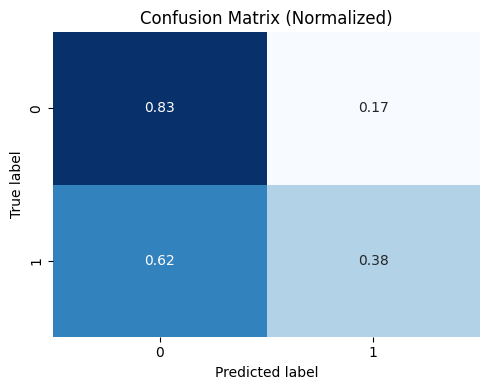

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
cmap="Blues"
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
normalize = True
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
            cmap=cmap, cbar=False, xticklabels=["0", "1"], yticklabels=["0", "1"])

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
plt.tight_layout()
plt.show()

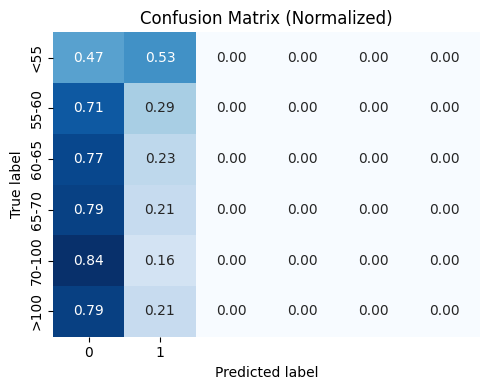

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_sub_true, y_pred)
cmap="Blues"
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
normalize = True
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
            cmap=cmap, cbar=False, xticklabels=["0", "1"], yticklabels=labels)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
plt.tight_layout()
plt.show()

In [ ]:

from sklearn.metrics import precision_recall_fscore_support
# after y_true/y_pred are computed:
prec, rec, f1c, sup = precision_recall_fscore_support(y_true, y_pred, labels=[0,1], zero_division=0)
print(f"  P0={prec[0]:.3f} R0={rec[0]:.3f} F1_0={f1c[0]:.3f} | P1={prec[1]:.3f} R1={rec[1]:.3f} F1_1={f1c[1]:.3f}")

  P0=0.909 R0=0.862 F1_0=0.885 | P1=0.236 R1=0.330 F1_1=0.275


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve

@torch.no_grad()
def collect_probs(model, loader, device):
    model.eval()
    probs, ys = [], []
    for x, y in tqdm(loader):
        x = x.to(device)
        y = torch.where(y < 3, 1, 0).to(device)   # your mapping
        p1 = F.softmax(model(x), dim=-1)[..., 1].view(-1)
        probs.append(p1.cpu())
        ys.append(y.view(-1).cpu())
    return torch.cat(probs).numpy(), torch.cat(ys).numpy()

def best_threshold_macro_f1(y_true, p1):
    ps, rs, ths = precision_recall_curve(y_true, p1)
    f1s = 2*ps*rs / np.clip(ps+rs, 1e-12, None)
    idx = int(np.nanargmax(f1s))
    thr = float(ths[idx]) if idx < len(ths) else 0.5
    return thr, float(f1s[idx])

def cm_at_threshold(y_true, p1, thr):
    y_pred = (p1 >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize='true')
    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]
    bal_acc = 0.5*(tn + tp)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return cm, bal_acc, f1

# usage
p1, y = collect_probs(model, test_loader, device)
thr, f1_best = best_threshold_macro_f1(y, p1)
cm, bal_acc, f1_macro = cm_at_threshold(y, p1, thr)
print(f"Best thr={thr:.3f} | macro-F1(best)={f1_best:.4f} | bal_acc={bal_acc:.3f}")
print(cm)


100%|██████████| 1461/1461 [13:13<00:00,  1.84it/s]


Best thr=0.477 | macro-F1(best)=0.2763 | bal_acc=0.601
[[0.82827648 0.17172352]
 [0.6268512  0.3731488 ]]


In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score

# y_true, y_pred should BOTH be binary ints {0,1}
assert set(np.unique(y_true)).issubset({0,1})
assert set(np.unique(y_pred)).issubset({0,1})

macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
prec, rec, f1c, sup = precision_recall_fscore_support(y_true, y_pred, labels=[0,1], zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # counts, not normalized
tn, fp, fn, tp = cm.ravel()
bal_acc = balanced_accuracy_score(y_true, y_pred)

print("macro_f1 =", macro_f1)
print(f"F1_0={f1c[0]:.3f}, F1_1={f1c[1]:.3f}, BalAcc={bal_acc:.3f}")
print(cm)


macro_f1 = 0.58001715252569
F1_0=0.885, F1_1=0.275, BalAcc=0.596
[[570745  91459]
 [ 57347  28273]]


In [ ]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
prec, rec, f1c, sup = precision_recall_fscore_support(y_true, y_pred, labels=[0,1], zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
spec = tn / (tn + fp + 1e-12)   # class 0 recall
sens = tp / (tp + fn + 1e-12)   # class 1 recall
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"P0={prec[0]:.3f} R0={rec[0]:.3f} F1_0={f1c[0]:.3f} | "
      f"P1={prec[1]:.3f} R1={rec[1]:.3f} F1_1={f1c[1]:.3f} | "
      f"Spec={spec:.3f} Sens={sens:.3f} BalAcc={bal_acc:.3f}")


P0=0.909 R0=0.862 F1_0=0.885 | P1=0.236 R1=0.330 F1_1=0.275 | Spec=0.862 Sens=0.330 BalAcc=0.596


In [ ]:
import numpy as np, torch.nn.functional as F
from sklearn.metrics import precision_recall_curve, f1_score

# probs for class 1 from your CE logits
p1 = F.softmax(logits_all, dim=1)[:, 1].cpu().numpy()   # collect over val
ps, rs, ths = precision_recall_curve(y_true, p1)
f1s = 2*ps*rs / np.clip(ps+rs, 1e-12, None)
best = int(np.nanargmax(f1s)); thr = ths[best] if best < len(ths) else 0.5

y_pred_thr = (p1 >= thr).astype(int)
prec, rec, f1c, sup = precision_recall_fscore_support(y_true, y_pred_thr, labels=[0,1], zero_division=0)
print(f"@thr={thr:.3f} -> F1_macro={f1_score(y_true, y_pred_thr, average='macro'):.3f} | "
      f"P1={prec[1]:.3f} R1={rec[1]:.3f} F1_1={f1c[1]:.3f}")


NameError: name 'logits_all' is not defined

# PRE WANDB

In [ ]:
stride = 20
index_cache_path = os.path.join(NP_PATH, f"test_chunk_index_T{CONTEXT_CHUNK_SIZE}_stride{stride}.pkl")
with open(index_cache_path, "rb") as f:
    test_chunk_index = pickle.load(f)

In [ ]:
test_caseid_to_segments = defaultdict(list)

for caseid, start_idx in tqdm(test_chunk_index):
  test_caseid_to_segments[caseid].append((start_idx, None))

100%|██████████| 70196/70196 [00:00<00:00, 4010834.98it/s]


In [ ]:
caseid_to_segments = {k: test_caseid_to_segments[k] for k in list(test_caseid_to_segments.keys())[:200]}
data_dir = NP_PATH
T = CONTEXT_CHUNK_SIZE
window_size = WINDOW_SIZE
segments = []
labels = []

for caseid, segment_list in tqdm(caseid_to_segments.items(), desc="📥 Loading segments"):
    case_path = os.path.join(data_dir, f"case_{caseid}_ecg.npy")
    case_data = np.load(case_path, mmap_mode="r")  # shape: [N_windows, window_size]
    # case_labels_path = os.path.join(data_dir, f"case_{caseid}_labels.npy")
    # case_labels = np.load(case_labels_path, mmap_mode="r")  # shape: [N_windows]


    for start_idx, label in segment_list:
        if start_idx + T <= len(case_data):
            segment = case_data[start_idx:start_idx + T]  # [T, window_size]
            # segment_labels = case_labels[start_idx:start_idx + T]  # shape: [T]
            if segment.shape == (T, window_size):  # double check
                segments.append(segment.astype(np.float32))
                # labels.append(segment_labels)

print(len(segments))
segments_np = np.stack(segments)
print(segments_np.shape)
np.save(os.path.join(NP_PATH, "test_segments_part1.npy"), segments_np)

📥 Loading segments: 100%|██████████| 200/200 [21:50<00:00,  6.55s/it]


23626
(23626, 16, 30000)


In [ ]:
os.path.exists(os.path.join(NP_PATH, "test_segments_part1.npy"))

True

In [ ]:
caseid_to_segments = {k: test_caseid_to_segments[k] for k in list(test_caseid_to_segments.keys())[200:400]}
data_dir = NP_PATH
T = CONTEXT_CHUNK_SIZE
window_size = WINDOW_SIZE
segments = []
labels = []

for caseid, segment_list in tqdm(caseid_to_segments.items(), desc="📥 Loading segments"):
    case_path = os.path.join(data_dir, f"case_{caseid}_ecg.npy")
    case_data = np.load(case_path, mmap_mode="r")  # shape: [N_windows, window_size]
    # case_labels_path = os.path.join(data_dir, f"case_{caseid}_labels.npy")
    # case_labels = np.load(case_labels_path, mmap_mode="r")  # shape: [N_windows]


    for start_idx, label in segment_list:
        if start_idx + T <= len(case_data):
            segment = case_data[start_idx:start_idx + T]  # [T, window_size]
            # segment_labels = case_labels[start_idx:start_idx + T]  # shape: [T]
            if segment.shape == (T, window_size):  # double check
                segments.append(segment.astype(np.float32))
                # labels.append(segment_labels)

segments_np = np.stack(segments)
np.save(os.path.join(NP_PATH, "test_segments_part2.npy"), segments_np)

📥 Loading segments: 100%|██████████| 200/200 [20:06<00:00,  6.03s/it]


In [ ]:
caseid_to_segments = {k: test_caseid_to_segments[k] for k in list(test_caseid_to_segments.keys())[400:]}
data_dir = NP_PATH
T = CONTEXT_CHUNK_SIZE
window_size = WINDOW_SIZE
segments = []
labels = []

for caseid, segment_list in tqdm(caseid_to_segments.items(), desc="📥 Loading segments"):
    case_path = os.path.join(data_dir, f"case_{caseid}_ecg.npy")
    case_data = np.load(case_path, mmap_mode="r")  # shape: [N_windows, window_size]
    # case_labels_path = os.path.join(data_dir, f"case_{caseid}_labels.npy")
    # case_labels = np.load(case_labels_path, mmap_mode="r")  # shape: [N_windows]


    for start_idx, label in segment_list:
        if start_idx + T <= len(case_data):
            segment = case_data[start_idx:start_idx + T]  # [T, window_size]
            # segment_labels = case_labels[start_idx:start_idx + T]  # shape: [T]
            if segment.shape == (T, window_size):  # double check
                segments.append(segment.astype(np.float32))
                # labels.append(segment_labels)

segments_np = np.stack(segments)
np.save(os.path.join(NP_PATH, "test_segments_part3.npy"), segments_np)

📥 Loading segments: 100%|██████████| 194/194 [18:35<00:00,  5.75s/it]


In [ ]:
caseid_to_segments = test_caseid_to_segments
data_dir = NP_PATH
T = CONTEXT_CHUNK_SIZE
window_size = WINDOW_SIZE
segments = []
labels = []

for caseid, segment_list in tqdm(caseid_to_segments.items(), desc="📥 Loading segments"):
    # case_path = os.path.join(data_dir, f"case_{caseid}_ecg.npy")
    # case_data = np.load(case_path, mmap_mode="r")  # shape: [N_windows, window_size]
    case_labels_path = os.path.join(data_dir, f"case_{caseid}_labels.npy")
    case_labels = np.load(case_labels_path, mmap_mode="r")  # shape: [N_windows]


    for start_idx, label in segment_list:
        if start_idx + T <= len(case_labels):
            # segment = case_data[start_idx:start_idx + T]  # [T, window_size]
            segment_labels = case_labels[start_idx:start_idx + T]  # shape: [T]
            if segment_labels.shape == (T,):  # double check
                # segments.append(segment.astype(np.float32))
                labels.append(segment_labels)

labels_np = np.stack(labels)
np.save(os.path.join(NP_PATH, "test_labels.npy"), labels_np)

📥 Loading segments: 100%|██████████| 594/594 [02:21<00:00,  4.19it/s]


In [ ]:
caseid_to_segments = test_caseid_to_segments
data_dir = NP_PATH
T = CONTEXT_CHUNK_SIZE
window_size = WINDOW_SIZE
segments = []
labels = []

for caseid, segment_list in tqdm(caseid_to_segments.items(), desc="📥 Loading segments"):
    case_path = os.path.join(data_dir, f"case_{caseid}_ecg.npy")
    case_data = np.load(case_path, mmap_mode="r")  # shape: [N_windows, window_size]
    # case_labels_path = os.path.join(data_dir, f"case_{caseid}_labels.npy")
    # case_labels = np.load(case_labels_path, mmap_mode="r")  # shape: [N_windows]


    for start_idx, label in segment_list:
        if start_idx + T <= len(case_data):
            segment = case_data[start_idx:start_idx + T]  # [T, window_size]
            # segment_labels = case_labels[start_idx:start_idx + T]  # shape: [T]
            if segment.shape == (T, window_size):  # double check
                segments.append(segment.astype(np.float32))
                # labels.append(segment_labels)

segments_np = np.stack(segments)
np.save(os.path.join(NP_PATH, "test_segments_part2.npy"), segments_np)

In [ ]:
test_seg_part1 = np.load(os.path.join(NP_PATH, "test_segments_part1.npy"))
test_seg_part2 = np.load(os.path.join(NP_PATH, "test_segments_part2.npy"))
test_seg_part3 = np.load(os.path.join(NP_PATH, "test_segments_part3.npy"))

In [ ]:
test_seg = np.concatenate([test_seg_part1, test_seg_part2, test_seg_part3], axis=0)

In [ ]:
np.save(os.path.join(NP_PATH, "test_segments.npy"), test_seg)

In [ ]:
bins = [-np.inf, 55, 60, 65, 70, 100, np.inf]
labels = ['<55', '55-60', '60-65', '65-70', '70-100', '>100']
label_to_int = {label: i for i, label in enumerate(labels)}
int_to_label = {i: label for label, i in label_to_int.items()}

In [ ]:
# A dataset after segmenting and resampling
class SplitDataset(Dataset):
    def __init__(self, segemnts_paths, labels_path):
        self.labels = np.load(labels_path)
        self.parts = [np.load(path, mmap_mode='r') for path in segemnts_paths]
        self.lens = [part.shape[0] for part in self.parts]
        self.cumsum = np.cumsum([0] + self.lens)  # for lookup
        self.total = self.cumsum[-1]


    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        part_idx = np.searchsorted(self.cumsum, idx, side='right') - 1
        local_idx = idx - self.cumsum[part_idx]

        segment = self.parts[part_idx][local_idx]
        label = self.labels[idx]
        return torch.tensor(segment, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.relu(out)

class ResNet1DEncoder(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, out_dim=128, num_blocks=(2, 2, 2, 2)):
        """
        num_blocks: list or tuple, length = number of stages
        Each value = number of residual blocks in that stage.
        """
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, base_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        layers = []
        in_ch = base_channels
        for i, blocks in enumerate(num_blocks):
            out_ch = base_channels * (2 ** i)
            stride = 1 if i == 0 else 2
            layers.append(self._make_layer(in_ch, out_ch, blocks, stride))
            in_ch = out_ch  # next input = current output

        self.layers = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(in_ch, out_dim)

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = []
        downsample = None
        if stride != 1 or in_ch != out_ch:
            downsample = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_ch)
            )
        layers.append(BasicBlock1D(in_ch, out_ch, stride, downsample))
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layers(x)
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

class CNNLSTMModel(nn.Module):
    def __init__(self, cnn_out_dim=128, lstm_hidden=128, num_classes=6, num_blocks=(2, 2, 2)):
        super().__init__()
        self.cnn = ResNet1DEncoder(in_channels=1, out_dim=cnn_out_dim, num_blocks=num_blocks)
        self.lstm = nn.LSTM(input_size=cnn_out_dim, hidden_size=lstm_hidden,
                            batch_first=True, bidirectional=False)
        self.classifier = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        B, T, L = x.shape
        x = x.view(B * T, 1, L)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        lstm_out, _ = self.lstm(x)
        return self.classifier(lstm_out)


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Can be a list of class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
def accuracy_per_class(preds, labels, num_classes):
    correct = defaultdict(int)
    total = defaultdict(int)

    preds = preds.view(-1).cpu()
    labels = labels.view(-1).cpu()

    for p, y in zip(preds, labels):
        total[int(y)] += 1
        if int(p) == int(y):
            correct[int(y)] += 1

    acc_dict = {}
    for cls in range(num_classes):
        if total[cls] > 0:
            acc_dict[cls] = correct[cls] / total[cls]
        else:
            acc_dict[cls] = float('nan')  # no samples
    return acc_dict, total

@torch.no_grad()
def evaluate_model(model, val_loader, num_classes, device, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    for signals, labels in tqdm(val_loader, desc=f"eval stage", leave=False):
        signals = signals.to(device)
        labels = torch.where(labels < 3, 1, 0)
        labels = labels.to(device)

        logits = model(signals)  # (B, T, num_classes)
        if num_classes == 1:
            loss = criterion(logits.view(-1).float(), labels.view(-1).float())  # Both are 1D and float
        else:
            loss = criterion(
                logits.view(-1, logits.shape[-1]),
                labels.view(-1)
            )
        total_loss += loss.item()

        if num_classes == 1:
            probs = torch.sigmoid(logits) # (B, T, 1)
            preds = (probs > 0.5).long().squeeze(-1) # (B, T)
        else:
            preds = torch.argmax(logits, dim=-1)  # (B, T)
        all_preds.append(preds)
        all_labels.append(labels)


    all_preds = torch.cat(all_preds, dim=0).reshape(-1)
    all_labels = torch.cat(all_labels, dim=0).reshape(-1)

    # overall_accuracy = (all_preds == all_labels).float().mean().item()
    per_class_acc, class_counts = accuracy_per_class(all_preds, all_labels, num_classes)

    all_preds = all_preds.cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss / len(val_loader)

    return macro_f1, per_class_acc, avg_loss

@torch.no_grad()
def plot_confusion_matrix(model, dataloader, device, num_classes, label_names=None, normalize='true', return_probs=False):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_sub_labels =[]

    for signals, labels in tqdm(dataloader, desc='cm stage', leave=False):
        signals = signals.to(device)
        all_sub_labels.append(labels.cpu())
        labels = torch.where(labels < 3, 1, 0)
        labels = labels.to(device)

        logits = model(signals)
        if num_classes == 1:
            probs = torch.sigmoid(logits) # (B, T, 1)
            preds = (probs > 0.5).long().squeeze(-1) # (B, T)
        else:
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        if return_probs:
            all_probs.append(probs.cpu())

    y_pred = torch.cat(all_preds, dim=0).numpy().reshape(-1)
    y_true = torch.cat(all_labels, dim=0).numpy().reshape(-1)
    y_sub_true = torch.cat(all_sub_labels, dim=0).numpy().reshape(-1)
    if return_probs:
        y_probs = torch.cat(all_probs, dim=0).numpy().reshape(-1)

    # cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)), normalize=normalize)
    cm = None
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    # fig, ax = plt.subplots(figsize=(8, 6))
    # disp.plot(ax=ax, cmap='Blues', values_format='.2f')
    # plt.title("Normalized Confusion Matrix" if normalize else "Confusion Matrix")
    # plt.tight_layout()
    # plt.show()
    if return_probs:
        return cm, y_pred, y_true, y_probs, y_sub_true
    return cm, y_pred, y_true

In [ ]:
from copy import deepcopy
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs,
    num_classes,
    patience=20,
    save_dir="./checkpoints",
    model_name="model",
    scheduler=None,
    scheduler_mode="max",
):
    os.makedirs(save_dir, exist_ok=True)

    best_val_macro_f1 = 0.0
    best_epoch = 0
    best_model_state = None
    no_improve_epochs = 0

    loss_history = []
    val_accuracies = []
    val_per_class_history = []
    val_loss_history = []
    lr_history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

        for signals, labels in train_bar:
            signals = signals.to(device)
            labels = torch.where(labels < 3, 1, 0)
            labels = labels.to(device)

            logits = model(signals)
            if num_classes == 1:
                loss = criterion(logits.view(-1).float(), labels.view(-1).float())  # Both are 1D and float
            else:
                loss = criterion(logits.view(-1, logits.shape[-1]), labels.view(-1))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        loss_history.append(avg_train_loss)

        val_macro_f1, val_per_class, val_loss = evaluate_model(model, val_loader, num_classes, device, criterion)
        val_accuracies.append(val_macro_f1)
        val_per_class_history.append(val_per_class)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, Val val_macro_f1 = {val_macro_f1:.4f}")

        for cls, acc in val_per_class.items():
            print(f"  Class {cls} Accuracy: {acc:.2%}")

        # Checkpoint (latest)
        torch.save(model.state_dict(), os.path.join(save_dir, f"latest_{model_name}.pt"))

        # Checkpoint (best)
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            best_epoch = epoch
            best_model_state = deepcopy(model.state_dict())
            torch.save(best_model_state, os.path.join(save_dir, f"best_{model_name}.pt"))
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"⏹️ Early stopping at epoch {epoch} after {patience} epochs without improvement.")
                break

        # scheduler step
        if scheduler is not None:
            if scheduler_mode == "max":
                scheduler.step(val_macro_f1)
            elif scheduler_mode == "min":
                scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"📉 Learning Rate: {current_lr:.6f}")
        lr_history.append(optimizer.param_groups[0]["lr"])

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, {
        "train_loss": loss_history,
        "val_loss": val_loss_history,
        "val_accuracy": val_accuracies,
        "val_per_class": val_per_class_history,
        "best_epoch": best_epoch,
        "best_val_acc": best_val_macro_f1,
        "lr_history": lr_history
    }


In [ ]:
# Copy data to local drive for faster IO during training
!cp {os.path.join(NP_PATH, "train_segments_part1.npy")} train_segments_part1.npy
!cp {os.path.join(NP_PATH, "train_segments_part2.npy")} train_segments_part2.npy

!sleep 5
!cp {os.path.join(NP_PATH, "test_segments_part1.npy")} test_segments_part1.npy
!cp {os.path.join(NP_PATH, "test_segments_part2.npy")} test_segments_part2.npy
# !cp {os.path.join(NP_PATH, "test_segments_part3.npy")} test_segments_part3.npy

!sleep 5
!cp {os.path.join(NP_PATH, "test_labels.npy")} test_labels.npy

!sleep 5
!cp {os.path.join(NP_PATH, "test_labels.npy")} test_labels.npy

In [ ]:
!cp {os.path.join(NP_PATH, "train_segments_part1.npy")} train_segments_part1.npy
!cp {os.path.join(NP_PATH, "train_segments_part2.npy")} train_segments_part2.npy

In [ ]:
!sleep 5
!cp {os.path.join(NP_PATH, "test_segments_part1.npy")} test_segments_part1.npy
!cp {os.path.join(NP_PATH, "test_segments_part2.npy")} test_segments_part2.npy
# !cp {os.path.join(NP_PATH, "test_segments_part3.npy")} test_segments_part3.npy

In [ ]:
!sleep 5
!cp {os.path.join(NP_PATH, "test_labels.npy")} test_labels.npy

In [ ]:
!sleep 5
!cp {os.path.join(NP_PATH, "train_labels.npy")} train_labels.npy

In [ ]:
# !cd drive/MyDrive/data/ecg2bg/vitlab_data/np; zip -r test_segments.zip test_segments_part1.npy test_segments_part2.npy test_segments_part3.npy test_labels.npy train_labels.npy train_segments_part1.npy train_segments_part2.npy

  adding: test_segments_part1.npy


zip error: Interrupted (aborting)


In [ ]:
NP_PATH

'drive/MyDrive/data/ecg2bg/vitlab_data/np'

In [ ]:
!ls -hl

total 165G
drwx------ 5 root root 4.0K Aug  1 15:59 drive
drwxr-xr-x 1 root root 4.0K Jul 30 13:39 sample_data
-rw------- 1 root root 8.6M Aug  1 16:14 test_labels.npy
-rw------- 1 root root  43G Aug  1 16:23 test_segments_part1.npy
-rw------- 1 root root  42G Aug  1 16:31 test_segments_part2.npy
-rw------- 1 root root  33G Aug  1 16:37 test_segments_part3.npy
-rw------- 1 root root 3.4M Aug  1 16:00 train_labels.npy
-rw------- 1 root root  29G Aug  1 16:07 train_segments_part1.npy
-rw------- 1 root root  21G Aug  1 16:14 train_segments_part2.npy


In [ ]:
train_ds = SplitDataset(["train_segments_part1.npy",
                         "train_segments_part2.npy"],
                        "train_labels.npy")
test_ds = SplitDataset(["test_segments_part1.npy",
                        "test_segments_part2.npy",],
                       "test_labels.npy")


In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
# for k, v in list(locals().items()):
#   if isinstance(v, torch.Tensor):
#     v.cpu()
#     print(k, v.shape)
#   if isinstance(v, torch.nn.Module):
#     v.cpu()
#     print(k, v)
# torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")
model_name = "CNNLSTM_NP_T16_H90s_binary_baseline_head_size2_longrun_v2"
model = CNNLSTMModel(
    cnn_out_dim=128,
    lstm_hidden=64,
    num_classes=2,
    num_blocks=(1, 1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
)
criterion = nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()

num_epochs = 50
model, evaluation = train_model(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    device,
    num_epochs,
    2,
    patience=30,
    save_dir=os.path.join(BASE_PATH, "checkpoints"),
    model_name=model_name,
    scheduler=scheduler,
    scheduler_mode="min"
)

with open(os.path.join(BASE_PATH, f"{model_name}_metrics.json"), "w") as f:
    json.dump(evaluation, f)

using cuda device


Epoch 1: Train Loss = 0.6806, Val Loss = 0.6182, Val val_macro_f1 = 0.5578
  Class 0 Accuracy: 85.60%
  Class 1 Accuracy: 28.43%
📉 Learning Rate: 0.000100


Epoch 2: Train Loss = 0.6789, Val Loss = 0.6161, Val val_macro_f1 = 0.5632
  Class 0 Accuracy: 84.83%
  Class 1 Accuracy: 31.16%
📉 Learning Rate: 0.000100


Epoch 3: Train Loss = 0.6775, Val Loss = 0.6530, Val val_macro_f1 = 0.5487
  Class 0 Accuracy: 77.31%
  Class 1 Accuracy: 41.38%
📉 Learning Rate: 0.000100


Epoch 4: Train Loss = 0.6766, Val Loss = 0.6551, Val val_macro_f1 = 0.5139
  Class 0 Accuracy: 68.48%
  Class 1 Accuracy: 48.19%
📉 Learning Rate: 0.000100


Epoch 5: Train Loss = 0.6763, Val Loss = 0.6534, Val val_macro_f1 = 0.5170
  Class 0 Accuracy: 69.78%
  Class 1 Accuracy: 46.44%
📉 Learning Rate: 0.000100


Epoch 6: Train Loss = 0.6750, Val Loss = 0.7224, Val val_macro_f1 = 0.3900
  Class 0 Accuracy: 38.88%
  Class 1 Accuracy: 75.42%
📉 Learning Rate: 0.000050


Epoch 7: Train Loss = 0.6710, Val Loss = 0.6788, Val val_macro_f1 = 0.4954
  Class 0 Accuracy: 62.57%
  Class 1 Accuracy: 55.02%
📉 Learning Rate: 0.000050


Epoch 8: Train Loss = 0.6700, Val Loss = 0.6567, Val val_macro_f1 = 0.5214
  Class 0 Accuracy: 69.98%
  Class 1 Accuracy: 47.64%
📉 Learning Rate: 0.000050


Epoch 9: Train Loss = 0.6706, Val Loss = 0.6268, Val val_macro_f1 = 0.5425
  Class 0 Accuracy: 77.98%
  Class 1 Accuracy: 38.01%
📉 Learning Rate: 0.000050


Epoch 10: Train Loss = 0.6718, Val Loss = 0.5829, Val val_macro_f1 = 0.5598
  Class 0 Accuracy: 83.68%
  Class 1 Accuracy: 32.32%
📉 Learning Rate: 0.000050


Epoch 11: Train Loss = 0.6710, Val Loss = 0.5412, Val val_macro_f1 = 0.5716
  Class 0 Accuracy: 90.51%
  Class 1 Accuracy: 23.62%
📉 Learning Rate: 0.000050


Epoch 12: Train Loss = 0.6715, Val Loss = 0.6823, Val val_macro_f1 = 0.4986
  Class 0 Accuracy: 62.65%
  Class 1 Accuracy: 56.27%
📉 Learning Rate: 0.000050


Epoch 13: Train Loss = 0.6717, Val Loss = 0.7231, Val val_macro_f1 = 0.3944
  Class 0 Accuracy: 39.33%
  Class 1 Accuracy: 76.29%
📉 Learning Rate: 0.000050


Epoch 14: Train Loss = 0.6718, Val Loss = 0.6270, Val val_macro_f1 = 0.5623
  Class 0 Accuracy: 80.95%
  Class 1 Accuracy: 38.21%
📉 Learning Rate: 0.000050


Epoch 15: Train Loss = 0.6722, Val Loss = 0.6351, Val val_macro_f1 = 0.5586
  Class 0 Accuracy: 80.79%
  Class 1 Accuracy: 37.41%
📉 Learning Rate: 0.000025


Epoch 16: Train Loss = 0.6714, Val Loss = 0.6421, Val val_macro_f1 = 0.5461
  Class 0 Accuracy: 76.07%
  Class 1 Accuracy: 43.13%
📉 Learning Rate: 0.000025


Epoch 17: Train Loss = 0.6713, Val Loss = 0.6809, Val val_macro_f1 = 0.4887
  Class 0 Accuracy: 60.50%
  Class 1 Accuracy: 57.50%
📉 Learning Rate: 0.000025


Epoch 18: Train Loss = 0.6722, Val Loss = 0.6344, Val val_macro_f1 = 0.5543
  Class 0 Accuracy: 79.46%
  Class 1 Accuracy: 38.77%
📉 Learning Rate: 0.000025


Epoch 19: Train Loss = 0.6726, Val Loss = 0.6449, Val val_macro_f1 = 0.5520
  Class 0 Accuracy: 79.19%
  Class 1 Accuracy: 38.59%
📉 Learning Rate: 0.000013


Epoch 20: Train Loss = 0.6725, Val Loss = 0.6559, Val val_macro_f1 = 0.5426
  Class 0 Accuracy: 75.38%
  Class 1 Accuracy: 43.41%
📉 Learning Rate: 0.000013


Epoch 21: Train Loss = 0.6728, Val Loss = 0.6492, Val val_macro_f1 = 0.5548
  Class 0 Accuracy: 78.22%
  Class 1 Accuracy: 41.45%
📉 Learning Rate: 0.000013


Epoch 22: Train Loss = 0.6734, Val Loss = 0.6582, Val val_macro_f1 = 0.5478
  Class 0 Accuracy: 76.07%
  Class 1 Accuracy: 43.70%
📉 Learning Rate: 0.000013


Epoch 23: Train Loss = 0.6739, Val Loss = 0.6594, Val val_macro_f1 = 0.5449
  Class 0 Accuracy: 75.75%
  Class 1 Accuracy: 43.42%
📉 Learning Rate: 0.000006


Epoch 24: Train Loss = 0.6745, Val Loss = 0.6567, Val val_macro_f1 = 0.5493
  Class 0 Accuracy: 77.08%
  Class 1 Accuracy: 42.04%
📉 Learning Rate: 0.000006


Epoch 25: Train Loss = 0.6744, Val Loss = 0.6616, Val val_macro_f1 = 0.5437
  Class 0 Accuracy: 75.03%
  Class 1 Accuracy: 44.55%
📉 Learning Rate: 0.000006


Epoch 26: Train Loss = 0.6750, Val Loss = 0.6641, Val val_macro_f1 = 0.5448
  Class 0 Accuracy: 75.15%
  Class 1 Accuracy: 44.65%
📉 Learning Rate: 0.000006


Epoch 27: Train Loss = 0.6752, Val Loss = 0.6723, Val val_macro_f1 = 0.5250
  Class 0 Accuracy: 70.01%
  Class 1 Accuracy: 48.97%
📉 Learning Rate: 0.000003


Epoch 28: Train Loss = 0.6749, Val Loss = 0.6593, Val val_macro_f1 = 0.5519
  Class 0 Accuracy: 77.11%
  Class 1 Accuracy: 42.83%
📉 Learning Rate: 0.000003


Epoch 29: Train Loss = 0.6748, Val Loss = 0.6544, Val val_macro_f1 = 0.5572
  Class 0 Accuracy: 79.05%
  Class 1 Accuracy: 40.53%
📉 Learning Rate: 0.000003


Epoch 30: Train Loss = 0.6753, Val Loss = 0.6674, Val val_macro_f1 = 0.5419
  Class 0 Accuracy: 74.71%
  Class 1 Accuracy: 44.59%
📉 Learning Rate: 0.000003


Epoch 31: Train Loss = 0.6757, Val Loss = 0.6568, Val val_macro_f1 = 0.5574
  Class 0 Accuracy: 79.52%
  Class 1 Accuracy: 39.61%
📉 Learning Rate: 0.000002


Epoch 32: Train Loss = 0.6757, Val Loss = 0.6675, Val val_macro_f1 = 0.5434
  Class 0 Accuracy: 74.99%
  Class 1 Accuracy: 44.51%
📉 Learning Rate: 0.000002


Epoch 33: Train Loss = 0.6759, Val Loss = 0.6713, Val val_macro_f1 = 0.5367
  Class 0 Accuracy: 72.91%
  Class 1 Accuracy: 46.73%
📉 Learning Rate: 0.000002


Epoch 34: Train Loss = 0.6762, Val Loss = 0.6685, Val val_macro_f1 = 0.5420
  Class 0 Accuracy: 74.35%
  Class 1 Accuracy: 45.43%
📉 Learning Rate: 0.000002


Epoch 35: Train Loss = 0.6763, Val Loss = 0.6674, Val val_macro_f1 = 0.5426
  Class 0 Accuracy: 74.48%
  Class 1 Accuracy: 45.35%
📉 Learning Rate: 0.000001


Epoch 36: Train Loss = 0.6761, Val Loss = 0.6622, Val val_macro_f1 = 0.5520
  Class 0 Accuracy: 77.65%
  Class 1 Accuracy: 41.75%
📉 Learning Rate: 0.000001


Epoch 37: Train Loss = 0.6761, Val Loss = 0.6625, Val val_macro_f1 = 0.5515
  Class 0 Accuracy: 77.45%
  Class 1 Accuracy: 42.00%
📉 Learning Rate: 0.000001


Epoch 38: Train Loss = 0.6765, Val Loss = 0.6692, Val val_macro_f1 = 0.5442
  Class 0 Accuracy: 74.92%
  Class 1 Accuracy: 44.95%
📉 Learning Rate: 0.000001


Epoch 39: Train Loss = 0.6766, Val Loss = 0.6617, Val val_macro_f1 = 0.5543
  Class 0 Accuracy: 78.98%
  Class 1 Accuracy: 39.73%
📉 Learning Rate: 0.000000


Epoch 40: Train Loss = 0.6764, Val Loss = 0.6752, Val val_macro_f1 = 0.5277
  Class 0 Accuracy: 70.34%
  Class 1 Accuracy: 49.27%
📉 Learning Rate: 0.000000


Epoch 41: Train Loss = 0.6765, Val Loss = 0.6679, Val val_macro_f1 = 0.5447
  Class 0 Accuracy: 75.84%
  Class 1 Accuracy: 43.13%
⏹️ Early stopping at epoch 41 after 30 epochs without improvement.


#### MixUp

In [ ]:
def targeted_binary_mixup(x, y, target_subclasses=[1, 2], alpha=0.4):
    """
    Mixes only samples from selected sub-classes with samples from the *opposite* binary class.

    Args:
        x: Tensor of shape (B, T, WINDOW)
        y: Tensor of shape (B, T), sub-class labels (int: 0–5)
        target_subclasses: list of sub-classes to focus on (e.g., [1, 2])
        alpha: MixUp interpolation strength

    Returns:
        mixed_x: same shape as x
        mixed_y: shape (B, T), soft binary labels (float in [0, 1])
    """
    B, T, W = x.shape

    # Convert to binary labels: 1 if <3, else 0
    binary_y = (y < 3).long()

    mixed_x = x.clone()
    mixed_y = binary_y.clone().float()

    # Find sample indices where the dominant label is in [1, 2]
    for i in range(B):
        dominant_label = torch.mode(y[i])[0].item()
        if dominant_label not in target_subclasses:
            continue

        # Mix with a sample from opposite binary class
        curr_bin = binary_y[i, 0].item()  # assume consistent within time steps
        opp_bin = 1 - curr_bin

        # Find candidates in batch with opposite binary label
        candidates = [j for j in range(B) if binary_y[j, 0].item() == opp_bin]
        if not candidates:
            continue

        j = random.choice(candidates)
        lam = np.random.beta(alpha, alpha)

        # Mix input
        mixed_x[i] = lam * x[i] + (1 - lam) * x[j]

        # Mix binary labels as floats
        mixed_y[i] = lam * binary_y[i].float() + (1 - lam) * binary_y[j].float()

    return mixed_x, mixed_y


In [ ]:
x = torch.randn(10, 16, 256)   # (B=16, T=10, WINDOW=256)
y = torch.randint(0, 6, (10, 16))  # 6-class sequence labels

# You define what classes you want to mix together
mix_pairs = {
    2: [3],     # mix class 2 with 3
    0: [4, 5],  # mix class 0 with 4 or 5
}

x_mix, y_mix = mixup_inputs_and_labels(x, y, mix_pairs, alpha=0.4)

TypeError: one_hot(): argument 'num_classes' (position 2) must be int, not dict

In [ ]:
lam = 0.37088767299059955
(lam * y[4].float() + (1 - lam) * y[3].float())

tensor([1.0000, 2.5164, 2.6291, 1.7418, 2.1127, 1.6291, 3.1456, 0.7418, 3.3709,
        4.0000, 0.0000, 2.3709, 0.6291, 2.5164, 3.1127, 3.8873])

In [ ]:
y_mix

tensor([[1, 1, 4, 2, 0, 2, 1, 1, 5, 4, 1, 0, 2, 5, 1, 0],
        [5, 1, 5, 4, 0, 4, 3, 5, 4, 1, 3, 0, 5, 2, 3, 5],
        [1, 0, 4, 3, 2, 1, 5, 4, 1, 3, 4, 4, 1, 3, 1, 5],
        [5, 0, 3, 2, 0, 2, 1, 3, 3, 2, 2, 1, 3, 2, 2, 4],
        [3, 1, 1, 1, 3, 3, 2, 1, 4, 4, 0, 1, 0, 4, 4, 2],
        [1, 4, 4, 3, 0, 2, 3, 4, 2, 5, 1, 1, 0, 2, 4, 1],
        [3, 5, 3, 5, 5, 5, 3, 4, 3, 1, 5, 5, 1, 3, 5, 2],
        [3, 2, 1, 1, 4, 4, 3, 1, 4, 5, 0, 2, 0, 4, 4, 2],
        [3, 2, 4, 1, 0, 5, 3, 5, 5, 1, 4, 2, 5, 3, 4, 3],
        [4, 0, 2, 1, 1, 0, 0, 1, 2, 3, 1, 3, 2, 2, 2, 3]])

#### After training eval

In [ ]:
model_name = "CNNLSTM_NP_T16_H90s_binary_baseline_head_size2_longrun"
model = CNNLSTMModel(cnn_out_dim=128,
                     lstm_hidden=64,
                     num_classes=2,
                     num_blocks=(1, 1))
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "checkpoints", f"latest_{model_name}.pt")))

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cm, y_pred, y_true, y_probs, y_sub_true = plot_confusion_matrix(model=model,
                                                    dataloader=test_loader,
                                                    device=device,
                                                    normalize='true',
                                                    num_classes=2,
                                                    label_names=['is_IOH'],
                                                    return_probs=True)

In [ ]:
pd.Series(y_true).value_counts().rename('y_true'), pd.Series(y_pred).value_counts().rename('y_pred')

NameError: name 'y_true' is not defined

In [ ]:
y_true.shape, y_pred.shape

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
(y_pred == y_true).sum() / len(y_true)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def plot_f1_vs_threshold(y_true, y_probs, num_points=100):
    """
    Plots macro-F1 score against different classification thresholds.

    Parameters:
    - y_true: Ground truth binary labels (array-like, shape (n_samples,))
    - y_probs: Predicted probabilities for class 1 (array-like, shape (n_samples,))
    - num_points: Number of threshold points to evaluate

    Returns:
    - best_threshold: Threshold value with the highest macro-F1
    - best_f1: Macro-F1 score at that threshold
    """
    thresholds = np.linspace(0.0, 1.0, num_points)
    f1_scores = []

    for t in thresholds:
        preds = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, preds, average='macro')
        f1_scores.append(f1)

    best_idx = int(np.argmax(f1_scores))
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.axvline(best_threshold, color='r', linestyle='--',
                label=f"Best Threshold = {best_threshold:.2f}, F1 = {best_f1:.4f}")
    plt.xlabel("Threshold")
    plt.ylabel("Macro F1 Score")
    plt.title("Macro-F1 Score vs Classification Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold, best_f1


In [ ]:
y_probs.shape

In [ ]:
probs = F.softmax(torch.tensor(y_probs)).cpu().argmax().numpy().reshape(-1)  # Convert to probabilities
best_t, best_f1 = plot_f1_vs_threshold(y_true, probs)
print(f"Best threshold: {best_t:.4f}, Best macro-F1: {best_f1:.4f}")

In [ ]:
new_preds = (y_probs >= 0.63).astype(int)
print(classification_report(y_true, new_preds))
(new_preds == y_true).sum() / len(y_true)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93    662204
           1       0.36      0.12      0.18     85620

    accuracy                           0.87    747824
   macro avg       0.63      0.55      0.56    747824
weighted avg       0.83      0.87      0.85    747824



np.float64(0.8749705813132502)

array([[ 20403,  19502],
       [  8612,   2937],
       [ 26044,   8122],
       [ 53032,  14850],
       [422753,  83172],
       [ 71742,  16655]])

In [ ]:
cm = confusion_matrix(y_sub_true, y_pred, labels=[0, 1, 2, 3, 4, 5], normalize='true')

# Turn into DataFrame for better display
df_cm = pd.DataFrame(cm[:,:2],
                     index=[f"True {i}" for i in range(6)],
                     columns=["Pred Bin 0", "Pred Bin 1"])

print(df_cm)

        Pred Bin 0  Pred Bin 1
True 0    0.511289    0.488711
True 1    0.745692    0.254308
True 2    0.762278    0.237722
True 3    0.781238    0.218762
True 4    0.835604    0.164396
True 5    0.811589    0.188411


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
def plot_metrics_vs_threshold(y_true, y_probs, num_points=100, class1_weight=1.0):
    """
    Plots precision, recall, and F1 score (macro and weighted) against thresholds.
    Allows extra weight for class 1 in F1 optimization.

    Parameters:
    - y_true: Ground truth binary labels (array-like, shape (n_samples,))
    - y_probs: Predicted probabilities for class 1 (array-like, shape (n_samples,))
    - num_points: Number of threshold points to evaluate
    - class1_weight: Extra weight for class 1's F1 in macro computation

    Returns:
    - best_threshold: Threshold value with highest weighted macro-F1
    - best_f1: Weighted macro-F1 score at that threshold
    """
    thresholds = np.linspace(0.0, 1.0, num_points)
    f1_scores_macro = []
    f1_scores_weighted_macro = []
    precision_class1 = []
    recall_class1 = []

    for t in thresholds:
        preds = (y_probs >= t).astype(int)

        # Regular macro F1
        f1_macro = f1_score(y_true, preds, average='macro')
        f1_scores_macro.append(f1_macro)

        # Weighted macro F1 (manual adjustment for class 1 importance)
        f1_class0 = f1_score(y_true, preds, labels=[0], average=None)[0]
        f1_class1 = f1_score(y_true, preds, labels=[1], average=None)[0]
        weighted_macro = (f1_class0 + class1_weight * f1_class1) / (1 + class1_weight)
        f1_scores_weighted_macro.append(weighted_macro)

        # Precision & recall for class 1
        prec1 = precision_score(y_true, preds, pos_label=1, zero_division=0)
        rec1 = recall_score(y_true, preds, pos_label=1, zero_division=0)
        precision_class1.append(prec1)
        recall_class1.append(rec1)

    # Best threshold based on weighted macro-F1
    best_idx = int(np.argmax(f1_scores_weighted_macro))
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores_weighted_macro[best_idx]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores_macro, label="Macro-F1", marker='o')
    plt.plot(thresholds, f1_scores_weighted_macro,
             label=f"Weighted Macro-F1 (class1_weight={class1_weight})", marker='x')
    plt.plot(thresholds, precision_class1, label="Precision (Class 1)", linestyle='--')
    plt.plot(thresholds, recall_class1, label="Recall (Class 1)", linestyle='--')
    plt.axvline(best_threshold, color='r', linestyle='--',
                label=f"Best Threshold = {best_threshold:.2f}, Weighted Macro-F1 = {best_f1:.4f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Metrics vs Classification Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold, best_f1

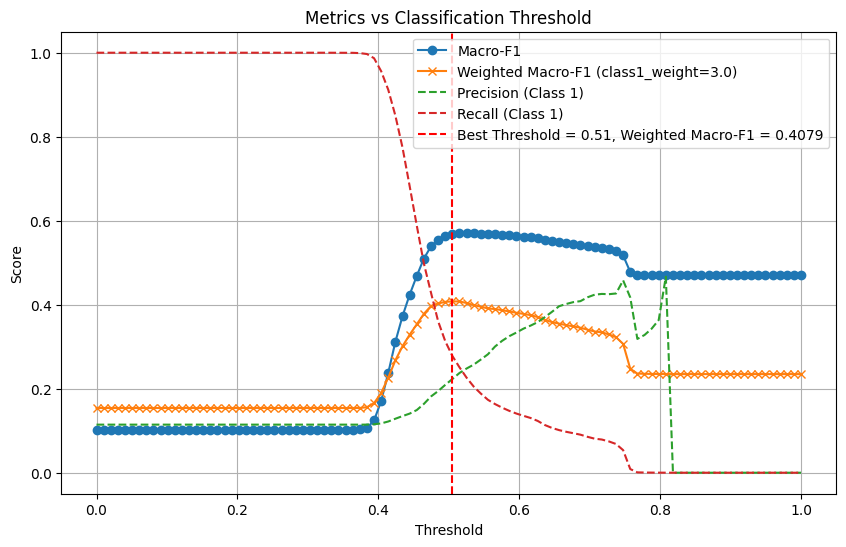

Best threshold: 0.5051, Best weighted macro-F1: 0.4079


In [ ]:
best_t, best_f1 = plot_metrics_vs_threshold(y_true, y_probs, class1_weight=3.0)
print(f"Best threshold: {best_t:.4f}, Best weighted macro-F1: {best_f1:.4f}")

In [ ]:
new_preds = (y_probs >= 0.75).astype(int)
print(classification_report(y_true, new_preds))
(new_preds == y_true).sum() / len(y_true)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    662204
           1       0.49      0.05      0.08     85620

    accuracy                           0.89    747824
   macro avg       0.69      0.52      0.51    747824
weighted avg       0.84      0.89      0.84    747824



np.float64(0.8853059008536768)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


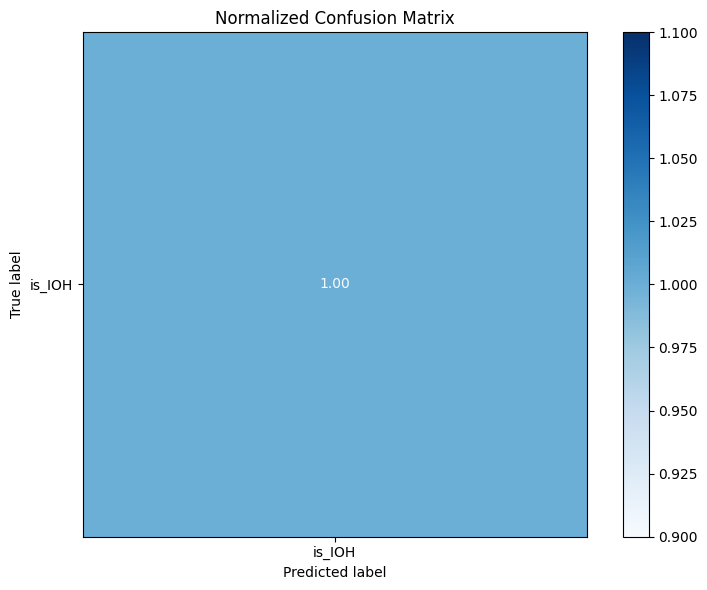

In [ ]:
cm, y_pred, y_true = plot_confusion_matrix(model=model,
                                           dataloader=test_loader,
                                           device=device,
                                           normalize='true',
                                           num_classes=1,
                                           label_names=['is_IOH'])

In [ ]:
pd.Series(y_true).value_counts().rename('y_true'), pd.Series(y_pred).value_counts().rename('y_pred')

(0    662204
 1     85620
 Name: y_true, dtype: int64,
 0    600523
 1    147301
 Name: y_pred, dtype: int64)

In [ ]:
(y_pred == y_true).sum() / len(y_true)

np.float64(0.7732848905624853)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87    662204
           1       0.21      0.32      0.25     85620

    accuracy                           0.78    747824
   macro avg       0.56      0.58      0.56    747824
weighted avg       0.83      0.78      0.80    747824



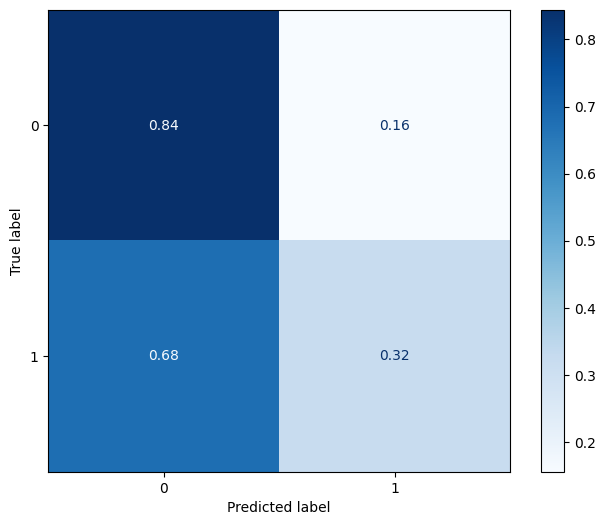

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='.2f')

In [ ]:
list(evaluation.keys())

['train_loss',
 'val_loss',
 'val_accuracy',
 'val_per_class',
 'best_epoch',
 'best_val_acc']

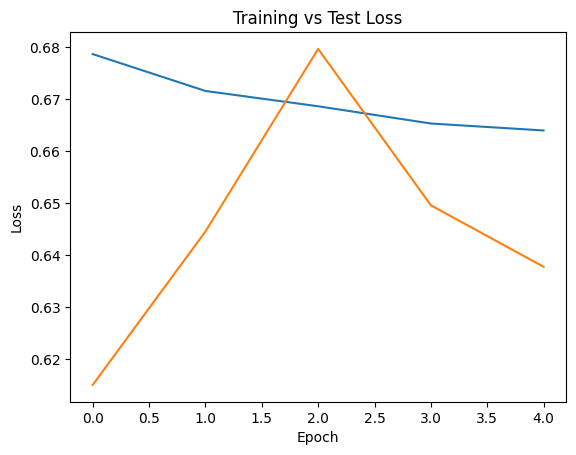

In [ ]:
plt.plot(evaluation['train_loss'], label='Train Loss')
plt.plot(evaluation['val_loss'], label='Validation Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

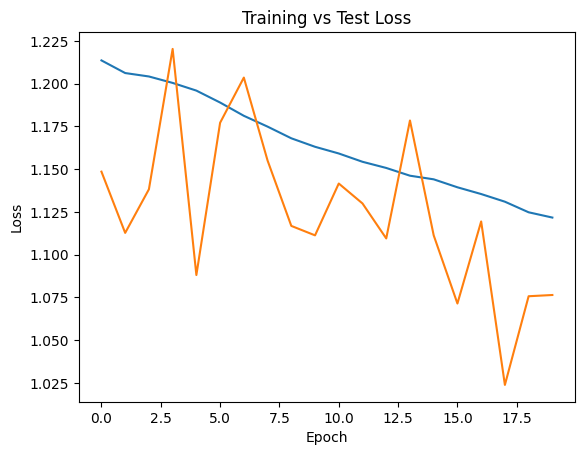

In [ ]:
plt.plot(evaluation['train_loss'], label='Train Loss')
plt.plot(evaluation['val_loss'], label='Validation Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

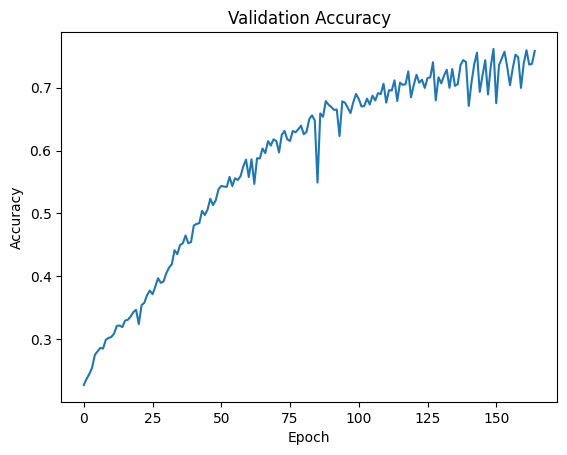

In [ ]:
plt.plot(evaluation['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

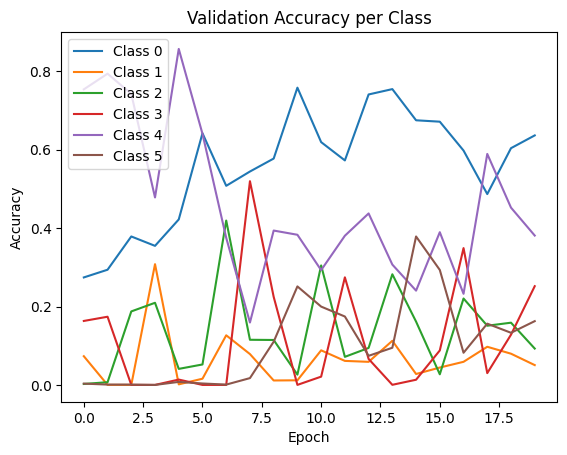

In [ ]:
# Per class accuracy during training
best_epoch = evaluation['best_epoch']
for cls in evaluation['val_per_class'][0]:
    plt.plot([acc[cls] for acc in evaluation['val_per_class']], label=f"Class {cls}")

plt.title('Validation Accuracy per Class')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

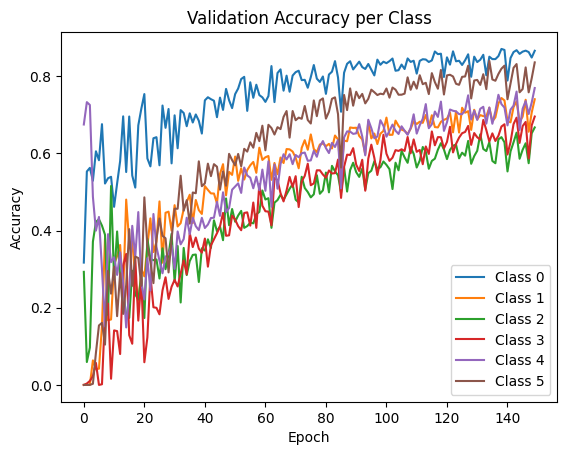

In [ ]:
# Per class accuracy during training
best_epoch = evaluation['best_epoch']
for cls in evaluation['val_per_class'][0]:
    plt.plot([acc[cls] for acc in evaluation['val_per_class'][:best_epoch]], label=f"Class {cls}")

plt.title('Validation Accuracy per Class')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# last val accuracy
best_epoch = evaluation['best_epoch']
print(f"✅ Val Accuracy: {evaluation['best_val_acc']:.4f}")
for cls, acc in evaluation['val_per_class'][best_epoch].items():
    print(f"  Class {cls} Accuracy: {acc:.2%}")

✅ Val Accuracy: 0.6065
  Class 0 Accuracy: 64.20%
  Class 1 Accuracy: 1.58%
  Class 2 Accuracy: 5.22%
  Class 3 Accuracy: 0.00%
  Class 4 Accuracy: 64.06%
  Class 5 Accuracy: 0.37%


In [ ]:
# last val accuracy
best_epoch = evaluation['best_epoch']
print(f"✅ Val Accuracy: {evaluation['best_val_acc']:.4f}")
for cls, acc in evaluation['val_per_class'][best_epoch].items():
    print(f"  Class {cls} Accuracy: {acc:.2%}")

✅ Val Accuracy: 0.7615
  Class 0 Accuracy: 85.00%
  Class 1 Accuracy: 66.95%
  Class 2 Accuracy: 55.06%
  Class 3 Accuracy: 59.00%
  Class 4 Accuracy: 64.67%
  Class 5 Accuracy: 75.88%


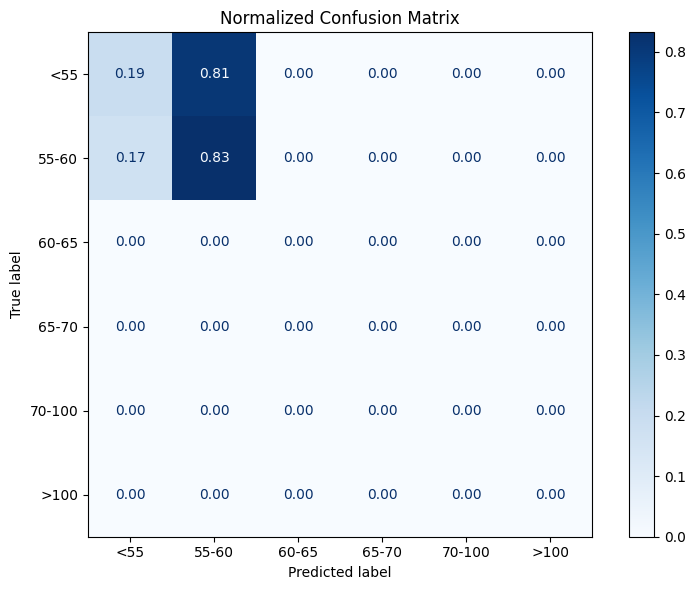

In [ ]:
# lastest_model = CNNLSTMModel(num_classes=6).to(device)
# lastest_model.load_state_dict(torch.load(os.path.join(BASE_PATH, "checkpoints", "latest_CNNLSTM_NP_T16_H90s_baseline.pt")))
# lastest_model.to(device)
cm, y_pred, y_true = plot_confusion_matrix(model=model,
                                           dataloader=test_loader,
                                           device=device,
                                           normalize='true',
                                           num_classes=len(label_to_int),
                                           label_names=list(label_to_int.keys()))

In [ ]:
list(label_to_int.keys())

['<55', '55-60', '60-65', '65-70', '70-100', '>100']

In [ ]:
val_acc, val_per_class, val_loss = evaluate_model(model, test_loader, 6, device, criterion)

In [ ]:
val_per_class

{0: 0.8660273054694698,
 1: 0.7403680014550305,
 2: 0.6673394543823545,
 3: 0.6955559778477576,
 4: 0.7694728560188828,
 5: 0.8359286201409412}

In [ ]:
lastest_model = CNNLSTMModel(num_classes=6).to(device)
lastest_model.load_state_dict(torch.load(os.path.join(BASE_PATH, "checkpoints", "latest_CNNLSTM_NP_T16_H90s_baseline.pt")))
lastest_model.to(device)

CNNLSTMModel(
  (cnn): CNN1DEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 16, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
      (4): ReLU()
      (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (6): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (7): ReLU()
      (8): AdaptiveAvgPool1d(output_size=1)
    )
    (fc): Linear(in_features=64, out_features=128, bias=True)
  )
  (lstm): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
lastest_model == model

False

In [ ]:
import torch

def compare_models(model_a, model_b):
    for (name_a, param_a), (name_b, param_b) in zip(model_a.named_parameters(), model_b.named_parameters()):
        if name_a != name_b:
            print(f"❌ Mismatched layer names: {name_a} vs {name_b}")
            return False
        if not torch.allclose(param_a, param_b, atol=1e-6):
            print(f"❌ Parameter mismatch in layer: {name_a}")
            return False
    print("✅ Models are identical.")
    return True
compare_models(lastest_model, model)

❌ Parameter mismatch in layer: cnn.encoder.0.weight


False

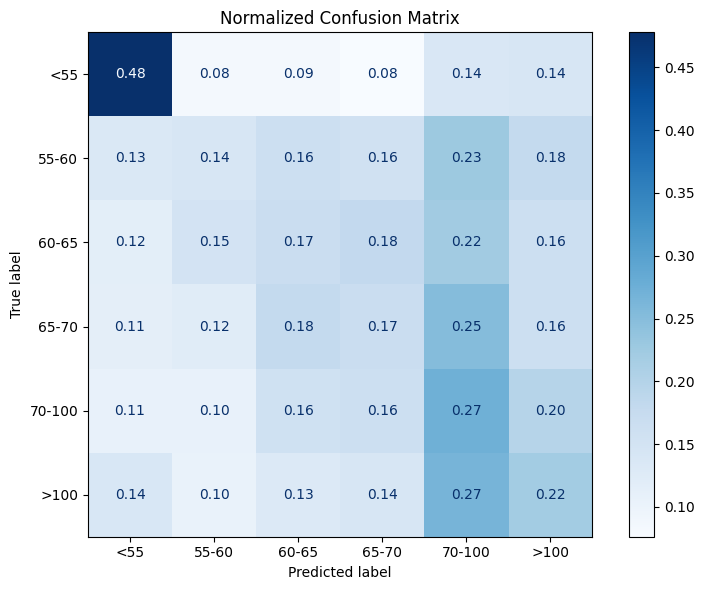

In [ ]:
# lastest_model = CNNLSTMModel(num_classes=6).to(device)
# lastest_model.load_state_dict(torch.load(os.path.join(BASE_PATH, "checkpoints", "latest_CNNLSTM_NP_T16_H90s_baseline.pt")))
# lastest_model.to(device)
cm, y_pred, y_true = plot_confusion_matrix(model=model,
                                           dataloader=test_loader,
                                           device=device,
                                           normalize='true',
                                           num_classes=len(label_to_int),
                                           label_names=list(label_to_int.keys()))

In [ ]:
accuracy_per_class(torch.tensor(y_pred), torch.tensor(y_true), len(label_to_int))

{0: 0.477784738754542,
 1: 0.14027188501168933,
 2: 0.16873499970731137,
 3: 0.16848354497510384,
 4: 0.27248505213223306,
 5: 0.22041471995655962}

In [ ]:
print(y_pred.shape, y_true.shape)

(747824,) (747824,)


In [ ]:
pd.Series(y_pred).value_counts()

,count
4,194018
5,143006
3,117629
2,114182
0,98462
1,80527


In [ ]:
# add CV split
stride = 20
index_cache_path = os.path.join(NP_PATH, f"train_chunk_index_T{CONTEXT_CHUNK_SIZE}_stride{stride}.pkl")
with open(index_cache_path, "rb") as f:
    train_chunk_index = pickle.load(f)
train_caseid_to_segments = defaultdict(list)

for caseid, start_idx in tqdm(test_chunk_index):
  train_caseid_to_segments[caseid].append((start_idx, None))

caseid_to_labels = {
  cid: [label for _, label in segments]
  for cid, segments in caseid_to_segments.items()
}

caseid_label_hist = {
    cid: Counter(labels)
    for cid, labels in caseid_to_labels.items()
}

caseid_majority_label = {
    cid: Counter(labels).most_common(1)[0][0]
    for cid, labels in caseid_to_labels.items()
}


case_ids = list(caseid_to_segments.keys())
case_labels = [caseid_majority_label[cid] for cid in case_ids]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for train_idx, val_idx in skf.split(case_ids, case_labels):
    train_ids = [case_ids[i] for i in train_idx]
    val_ids = [case_ids[i] for i in val_idx]
    folds.append((train_ids, val_ids))

In [ ]:
# Baseline with optuna
def objective(trial):
    # Define the hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    cnn_out_dim = trial.suggest_categorical("cnn_out_dim", [64, 128, 256])
    lstm_hidden = trial.suggest_categorical("lstm_hidden", [64, 128, 256])

    model = CNNLSTMModel(cnn_out_dim=cnn_out_dim, lstm_hidden=lstm_hidden, num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 🧠 Train and validate
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=30,
        num_classes=6,
        patience=5,
        save_dir=os.path.join(BASE_PATH, "optuna_trials", f"trial_{trial.number}")
        model_name="CNNLSTM_NP_T16_H90s_baseline"
    )

6

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")
model = CNNLSTMModel(num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
criterion = nn.CrossEntropyLoss()
num_epochs = 300
early_stopping = EarlyStopping(patience=15, min_delta=0.01, mode='max')

loss_history = []
val_loss_history = []
val_accuracies = []
val_per_class_history = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for signals, labels in train_bar:
        signals = signals.to(device)
        labels = labels.to(device)

        logits = model(signals)
        loss = criterion(
            logits.view(-1, logits.shape[-1]),
            labels.view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.set_postfix(loss=loss.item())
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}")

    val_acc, val_per_class, val_loss = evaluate_model(model,
                                                      test_loader,
                                                      num_classes=len(label_to_int),
                                                      device=device,
                                                      criterion=criterion)
    val_accuracies.append(val_acc)
    val_per_class_history.append(val_per_class)
    val_loss_history.append(val_loss)
    print(f"✅ Val Accuracy: {val_acc:.4f}, Val LossL {val_loss}")
    for cls, acc in val_per_class.items():
        print(f"  Class {cls} Accuracy: {acc:.2%}")

    scheduler.step(val_acc) # update lr based on val

    early_stopping(val_acc, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

using cuda device


Epoch 1 - Train Loss: 1.7634


✅ Val Accuracy: 0.2240
  Class 0 Accuracy: 28.14%
  Class 1 Accuracy: 6.21%
  Class 2 Accuracy: 4.19%
  Class 3 Accuracy: 1.49%
  Class 4 Accuracy: 85.79%
  Class 5 Accuracy: 0.00%


Epoch 2 - Train Loss: 1.7461


✅ Val Accuracy: 0.2304
  Class 0 Accuracy: 49.62%
  Class 1 Accuracy: 0.03%
  Class 2 Accuracy: 6.22%
  Class 3 Accuracy: 0.00%
  Class 4 Accuracy: 74.80%
  Class 5 Accuracy: 0.00%


Epoch 3 - Train Loss: 1.7394


✅ Val Accuracy: 0.2365
  Class 0 Accuracy: 44.85%
  Class 1 Accuracy: 0.35%
  Class 2 Accuracy: 8.06%
  Class 3 Accuracy: 0.00%
  Class 4 Accuracy: 80.31%
  Class 5 Accuracy: 0.00%


Epoch 4 - Train Loss: 1.7319


✅ Val Accuracy: 0.2392
  Class 0 Accuracy: 64.02%
  Class 1 Accuracy: 3.07%
  Class 2 Accuracy: 13.83%
  Class 3 Accuracy: 0.13%
  Class 4 Accuracy: 57.11%
  Class 5 Accuracy: 0.09%


Epoch 5 - Train Loss: 1.7267


✅ Val Accuracy: 0.2501
  Class 0 Accuracy: 45.05%
  Class 1 Accuracy: 7.13%
  Class 2 Accuracy: 21.18%
  Class 3 Accuracy: 24.47%
  Class 4 Accuracy: 46.90%
  Class 5 Accuracy: 0.74%


Epoch 6 - Train Loss: 1.7181


✅ Val Accuracy: 0.2459
  Class 0 Accuracy: 63.46%
  Class 1 Accuracy: 2.64%
  Class 2 Accuracy: 15.36%
  Class 3 Accuracy: 0.10%
  Class 4 Accuracy: 40.73%
  Class 5 Accuracy: 22.52%


Epoch 7 - Train Loss: 1.7118


✅ Val Accuracy: 0.2476
  Class 0 Accuracy: 34.97%
  Class 1 Accuracy: 5.11%
  Class 2 Accuracy: 62.66%
  Class 3 Accuracy: 0.02%
  Class 4 Accuracy: 39.55%
  Class 5 Accuracy: 0.80%


Epoch 8 - Train Loss: 1.7016


✅ Val Accuracy: 0.2511
  Class 0 Accuracy: 72.28%
  Class 1 Accuracy: 3.93%
  Class 2 Accuracy: 7.61%
  Class 3 Accuracy: 0.06%
  Class 4 Accuracy: 38.03%
  Class 5 Accuracy: 27.10%


Epoch 9 - Train Loss: 1.6930


✅ Val Accuracy: 0.2622
  Class 0 Accuracy: 65.52%
  Class 1 Accuracy: 13.65%
  Class 2 Accuracy: 7.96%
  Class 3 Accuracy: 2.55%
  Class 4 Accuracy: 30.93%
  Class 5 Accuracy: 37.00%


Epoch 10 - Train Loss: 1.6894


✅ Val Accuracy: 0.2684
  Class 0 Accuracy: 68.19%
  Class 1 Accuracy: 21.32%
  Class 2 Accuracy: 24.24%
  Class 3 Accuracy: 1.84%
  Class 4 Accuracy: 23.91%
  Class 5 Accuracy: 22.28%


Epoch 11 - Train Loss: 1.6781


✅ Val Accuracy: 0.2814
  Class 0 Accuracy: 68.57%
  Class 1 Accuracy: 14.71%
  Class 2 Accuracy: 24.10%
  Class 3 Accuracy: 0.36%
  Class 4 Accuracy: 40.04%
  Class 5 Accuracy: 19.28%


Epoch 12 - Train Loss: 1.6724


✅ Val Accuracy: 0.2859
  Class 0 Accuracy: 61.01%
  Class 1 Accuracy: 10.05%
  Class 2 Accuracy: 34.89%
  Class 3 Accuracy: 8.18%
  Class 4 Accuracy: 40.62%
  Class 5 Accuracy: 13.63%


Epoch 13 - Train Loss: 1.6661


✅ Val Accuracy: 0.2849
  Class 0 Accuracy: 65.88%
  Class 1 Accuracy: 12.89%
  Class 2 Accuracy: 18.89%
  Class 3 Accuracy: 3.92%
  Class 4 Accuracy: 32.41%
  Class 5 Accuracy: 36.60%


Epoch 14 - Train Loss: 1.6592


✅ Val Accuracy: 0.2948
  Class 0 Accuracy: 64.30%
  Class 1 Accuracy: 13.89%
  Class 2 Accuracy: 29.35%
  Class 3 Accuracy: 13.28%
  Class 4 Accuracy: 33.02%
  Class 5 Accuracy: 21.64%


Epoch 15 - Train Loss: 1.6544


✅ Val Accuracy: 0.2880
  Class 0 Accuracy: 68.68%
  Class 1 Accuracy: 12.37%
  Class 2 Accuracy: 15.76%
  Class 3 Accuracy: 5.99%
  Class 4 Accuracy: 30.20%
  Class 5 Accuracy: 39.90%


Epoch 16 - Train Loss: 1.6513


✅ Val Accuracy: 0.3001
  Class 0 Accuracy: 58.86%
  Class 1 Accuracy: 17.54%
  Class 2 Accuracy: 29.64%
  Class 3 Accuracy: 11.08%
  Class 4 Accuracy: 38.76%
  Class 5 Accuracy: 22.40%


Epoch 17 - Train Loss: 1.6428


✅ Val Accuracy: 0.3021
  Class 0 Accuracy: 51.96%
  Class 1 Accuracy: 18.99%
  Class 2 Accuracy: 36.47%
  Class 3 Accuracy: 23.89%
  Class 4 Accuracy: 31.83%
  Class 5 Accuracy: 16.58%


Epoch 18 - Train Loss: 1.6353


✅ Val Accuracy: 0.3062
  Class 0 Accuracy: 65.54%
  Class 1 Accuracy: 14.22%
  Class 2 Accuracy: 23.35%
  Class 3 Accuracy: 11.81%
  Class 4 Accuracy: 42.89%
  Class 5 Accuracy: 23.79%


Epoch 19 - Train Loss: 1.6330


✅ Val Accuracy: 0.3047
  Class 0 Accuracy: 45.56%
  Class 1 Accuracy: 41.95%
  Class 2 Accuracy: 22.22%
  Class 3 Accuracy: 15.81%
  Class 4 Accuracy: 27.26%
  Class 5 Accuracy: 32.28%


Epoch 20 - Train Loss: 1.6291


✅ Val Accuracy: 0.3144
  Class 0 Accuracy: 58.30%
  Class 1 Accuracy: 23.22%
  Class 2 Accuracy: 46.90%
  Class 3 Accuracy: 11.10%
  Class 4 Accuracy: 20.09%
  Class 5 Accuracy: 29.55%


Epoch 21 - Train Loss: 1.6216


✅ Val Accuracy: 0.3173
  Class 0 Accuracy: 58.90%
  Class 1 Accuracy: 17.82%
  Class 2 Accuracy: 37.20%
  Class 3 Accuracy: 16.57%
  Class 4 Accuracy: 37.00%
  Class 5 Accuracy: 21.00%


Epoch 22 - Train Loss: 1.6152


✅ Val Accuracy: 0.3189
  Class 0 Accuracy: 58.98%
  Class 1 Accuracy: 14.95%
  Class 2 Accuracy: 35.36%
  Class 3 Accuracy: 3.23%
  Class 4 Accuracy: 46.52%
  Class 5 Accuracy: 29.54%


Epoch 23 - Train Loss: 1.6137


✅ Val Accuracy: 0.3224
  Class 0 Accuracy: 65.95%
  Class 1 Accuracy: 20.25%
  Class 2 Accuracy: 27.60%
  Class 3 Accuracy: 21.17%
  Class 4 Accuracy: 23.22%
  Class 5 Accuracy: 36.16%


Epoch 24 - Train Loss: 1.6068


✅ Val Accuracy: 0.3247
  Class 0 Accuracy: 54.20%
  Class 1 Accuracy: 22.66%
  Class 2 Accuracy: 37.82%
  Class 3 Accuracy: 24.36%
  Class 4 Accuracy: 34.04%
  Class 5 Accuracy: 20.48%


Epoch 25 - Train Loss: 1.6035


✅ Val Accuracy: 0.3250
  Class 0 Accuracy: 64.76%
  Class 1 Accuracy: 22.06%
  Class 2 Accuracy: 23.29%
  Class 3 Accuracy: 10.60%
  Class 4 Accuracy: 36.85%
  Class 5 Accuracy: 37.30%


Epoch 26 - Train Loss: 1.5975


✅ Val Accuracy: 0.3306
  Class 0 Accuracy: 59.74%
  Class 1 Accuracy: 24.69%
  Class 2 Accuracy: 40.92%
  Class 3 Accuracy: 21.69%
  Class 4 Accuracy: 27.71%
  Class 5 Accuracy: 23.39%


Epoch 27 - Train Loss: 1.5896


✅ Val Accuracy: 0.3392
  Class 0 Accuracy: 61.18%
  Class 1 Accuracy: 35.24%
  Class 2 Accuracy: 32.41%
  Class 3 Accuracy: 18.77%
  Class 4 Accuracy: 32.29%
  Class 5 Accuracy: 24.33%


Epoch 28 - Train Loss: 1.5878


✅ Val Accuracy: 0.3242
  Class 0 Accuracy: 46.59%
  Class 1 Accuracy: 37.56%
  Class 2 Accuracy: 38.30%
  Class 3 Accuracy: 24.17%
  Class 4 Accuracy: 29.05%
  Class 5 Accuracy: 19.36%


Epoch 29 - Train Loss: 1.5866


✅ Val Accuracy: 0.3397
  Class 0 Accuracy: 71.09%
  Class 1 Accuracy: 30.94%
  Class 2 Accuracy: 21.51%
  Class 3 Accuracy: 15.22%
  Class 4 Accuracy: 25.00%
  Class 5 Accuracy: 42.42%


Epoch 30 - Train Loss: 1.5783


✅ Val Accuracy: 0.3375
  Class 0 Accuracy: 75.39%
  Class 1 Accuracy: 25.91%
  Class 2 Accuracy: 26.23%
  Class 3 Accuracy: 13.91%
  Class 4 Accuracy: 29.99%
  Class 5 Accuracy: 31.94%


Epoch 31 - Train Loss: 1.5705


✅ Val Accuracy: 0.3509
  Class 0 Accuracy: 64.66%
  Class 1 Accuracy: 31.42%
  Class 2 Accuracy: 20.66%
  Class 3 Accuracy: 18.57%
  Class 4 Accuracy: 37.34%
  Class 5 Accuracy: 38.69%


Epoch 32 - Train Loss: 1.5654


✅ Val Accuracy: 0.3544
  Class 0 Accuracy: 62.71%
  Class 1 Accuracy: 31.92%
  Class 2 Accuracy: 29.11%
  Class 3 Accuracy: 29.17%
  Class 4 Accuracy: 25.73%
  Class 5 Accuracy: 35.57%


Epoch 33 - Train Loss: 1.5574


✅ Val Accuracy: 0.3558
  Class 0 Accuracy: 65.30%
  Class 1 Accuracy: 41.65%
  Class 2 Accuracy: 27.33%
  Class 3 Accuracy: 17.81%
  Class 4 Accuracy: 30.35%
  Class 5 Accuracy: 33.15%


Epoch 34 - Train Loss: 1.5544


✅ Val Accuracy: 0.3662
  Class 0 Accuracy: 62.33%
  Class 1 Accuracy: 35.04%
  Class 2 Accuracy: 23.60%
  Class 3 Accuracy: 30.05%
  Class 4 Accuracy: 36.15%
  Class 5 Accuracy: 33.38%


Epoch 35 - Train Loss: 1.5441


✅ Val Accuracy: 0.3640
  Class 0 Accuracy: 68.05%
  Class 1 Accuracy: 35.01%
  Class 2 Accuracy: 33.66%
  Class 3 Accuracy: 16.50%
  Class 4 Accuracy: 38.47%
  Class 5 Accuracy: 26.90%


Epoch 36 - Train Loss: 1.5386


✅ Val Accuracy: 0.3449
  Class 0 Accuracy: 60.77%
  Class 1 Accuracy: 24.71%
  Class 2 Accuracy: 18.33%
  Class 3 Accuracy: 22.13%
  Class 4 Accuracy: 31.14%
  Class 5 Accuracy: 51.13%


Epoch 37 - Train Loss: 1.5322


✅ Val Accuracy: 0.3578
  Class 0 Accuracy: 70.46%
  Class 1 Accuracy: 26.94%
  Class 2 Accuracy: 18.69%
  Class 3 Accuracy: 18.19%
  Class 4 Accuracy: 33.75%
  Class 5 Accuracy: 47.94%


Epoch 38 - Train Loss: 1.5265


✅ Val Accuracy: 0.3759
  Class 0 Accuracy: 69.49%
  Class 1 Accuracy: 41.48%
  Class 2 Accuracy: 23.33%
  Class 3 Accuracy: 21.57%
  Class 4 Accuracy: 34.78%
  Class 5 Accuracy: 36.84%


Epoch 39 - Train Loss: 1.5206


✅ Val Accuracy: 0.3789
  Class 0 Accuracy: 67.37%
  Class 1 Accuracy: 34.17%
  Class 2 Accuracy: 25.84%
  Class 3 Accuracy: 26.31%
  Class 4 Accuracy: 34.78%
  Class 5 Accuracy: 40.07%


Epoch 40 - Train Loss: 1.5127


✅ Val Accuracy: 0.3863
  Class 0 Accuracy: 67.90%
  Class 1 Accuracy: 40.90%
  Class 2 Accuracy: 30.91%
  Class 3 Accuracy: 18.01%
  Class 4 Accuracy: 39.23%
  Class 5 Accuracy: 35.92%


Epoch 41 - Train Loss: 1.5111


✅ Val Accuracy: 0.3741
  Class 0 Accuracy: 76.69%
  Class 1 Accuracy: 31.16%
  Class 2 Accuracy: 26.95%
  Class 3 Accuracy: 22.46%
  Class 4 Accuracy: 29.81%
  Class 5 Accuracy: 39.01%


Epoch 42 - Train Loss: 1.4969


✅ Val Accuracy: 0.3940
  Class 0 Accuracy: 64.70%
  Class 1 Accuracy: 30.13%
  Class 2 Accuracy: 33.16%
  Class 3 Accuracy: 29.46%
  Class 4 Accuracy: 36.84%
  Class 5 Accuracy: 42.40%


Epoch 43 - Train Loss: 1.4980


✅ Val Accuracy: 0.3975
  Class 0 Accuracy: 62.52%
  Class 1 Accuracy: 45.81%
  Class 2 Accuracy: 27.86%
  Class 3 Accuracy: 27.49%
  Class 4 Accuracy: 37.93%
  Class 5 Accuracy: 38.64%


Epoch 44 - Train Loss: 1.4902


✅ Val Accuracy: 0.3965
  Class 0 Accuracy: 60.99%
  Class 1 Accuracy: 49.51%
  Class 2 Accuracy: 28.67%
  Class 3 Accuracy: 27.06%
  Class 4 Accuracy: 42.41%
  Class 5 Accuracy: 30.50%


Epoch 45 - Train Loss: 1.4781


✅ Val Accuracy: 0.4047
  Class 0 Accuracy: 63.30%
  Class 1 Accuracy: 44.40%
  Class 2 Accuracy: 35.22%
  Class 3 Accuracy: 28.93%
  Class 4 Accuracy: 33.15%
  Class 5 Accuracy: 39.72%


Epoch 46 - Train Loss: 1.4749


✅ Val Accuracy: 0.4070
  Class 0 Accuracy: 64.73%
  Class 1 Accuracy: 35.88%
  Class 2 Accuracy: 26.95%
  Class 3 Accuracy: 32.51%
  Class 4 Accuracy: 37.04%
  Class 5 Accuracy: 48.36%


Epoch 47 - Train Loss: 1.4647


✅ Val Accuracy: 0.4147
  Class 0 Accuracy: 67.81%
  Class 1 Accuracy: 37.37%
  Class 2 Accuracy: 30.38%
  Class 3 Accuracy: 29.15%
  Class 4 Accuracy: 40.95%
  Class 5 Accuracy: 43.95%


Epoch 48 - Train Loss: 1.4573


✅ Val Accuracy: 0.4062
  Class 0 Accuracy: 58.36%
  Class 1 Accuracy: 42.97%
  Class 2 Accuracy: 37.28%
  Class 3 Accuracy: 31.90%
  Class 4 Accuracy: 38.39%
  Class 5 Accuracy: 35.67%


Epoch 49 - Train Loss: 1.4509


✅ Val Accuracy: 0.4193
  Class 0 Accuracy: 68.71%
  Class 1 Accuracy: 39.84%
  Class 2 Accuracy: 28.02%
  Class 3 Accuracy: 29.63%
  Class 4 Accuracy: 42.31%
  Class 5 Accuracy: 44.03%


Epoch 50 - Train Loss: 1.4393


✅ Val Accuracy: 0.4205
  Class 0 Accuracy: 63.46%
  Class 1 Accuracy: 41.78%
  Class 2 Accuracy: 33.37%
  Class 3 Accuracy: 31.13%
  Class 4 Accuracy: 39.77%
  Class 5 Accuracy: 43.95%


Epoch 51 - Train Loss: 1.4335


✅ Val Accuracy: 0.4246
  Class 0 Accuracy: 75.35%
  Class 1 Accuracy: 46.02%
  Class 2 Accuracy: 32.17%
  Class 3 Accuracy: 29.34%
  Class 4 Accuracy: 33.94%
  Class 5 Accuracy: 40.32%


Epoch 52 - Train Loss: 1.4226


✅ Val Accuracy: 0.4204
  Class 0 Accuracy: 68.71%
  Class 1 Accuracy: 30.36%
  Class 2 Accuracy: 27.99%
  Class 3 Accuracy: 31.11%
  Class 4 Accuracy: 42.39%
  Class 5 Accuracy: 52.01%


Epoch 53 - Train Loss: 1.4216


✅ Val Accuracy: 0.4235
  Class 0 Accuracy: 76.95%
  Class 1 Accuracy: 39.75%
  Class 2 Accuracy: 36.52%
  Class 3 Accuracy: 25.98%
  Class 4 Accuracy: 34.34%
  Class 5 Accuracy: 42.24%


Epoch 54 - Train Loss: 1.4144


✅ Val Accuracy: 0.4426
  Class 0 Accuracy: 63.85%
  Class 1 Accuracy: 47.74%
  Class 2 Accuracy: 37.74%
  Class 3 Accuracy: 30.16%
  Class 4 Accuracy: 42.50%
  Class 5 Accuracy: 44.86%


Epoch 55 - Train Loss: 1.4023


✅ Val Accuracy: 0.4290
  Class 0 Accuracy: 73.54%
  Class 1 Accuracy: 41.12%
  Class 2 Accuracy: 30.72%
  Class 3 Accuracy: 28.35%
  Class 4 Accuracy: 35.38%
  Class 5 Accuracy: 50.43%


Epoch 56 - Train Loss: 1.3915


✅ Val Accuracy: 0.4492
  Class 0 Accuracy: 71.38%
  Class 1 Accuracy: 43.60%
  Class 2 Accuracy: 33.31%
  Class 3 Accuracy: 34.52%
  Class 4 Accuracy: 40.47%
  Class 5 Accuracy: 47.79%


Epoch 57 - Train Loss: 1.3898


✅ Val Accuracy: 0.4498
  Class 0 Accuracy: 65.89%
  Class 1 Accuracy: 41.32%
  Class 2 Accuracy: 35.38%
  Class 3 Accuracy: 34.92%
  Class 4 Accuracy: 45.31%
  Class 5 Accuracy: 47.61%


Epoch 58 - Train Loss: 1.3792


✅ Val Accuracy: 0.4556
  Class 0 Accuracy: 69.15%
  Class 1 Accuracy: 44.76%
  Class 2 Accuracy: 33.41%
  Class 3 Accuracy: 33.21%
  Class 4 Accuracy: 41.32%
  Class 5 Accuracy: 53.20%


Epoch 59 - Train Loss: 1.3732


✅ Val Accuracy: 0.4536
  Class 0 Accuracy: 65.41%
  Class 1 Accuracy: 52.03%
  Class 2 Accuracy: 40.09%
  Class 3 Accuracy: 36.18%
  Class 4 Accuracy: 38.86%
  Class 5 Accuracy: 41.54%


Epoch 60 - Train Loss: 1.3717


✅ Val Accuracy: 0.4677
  Class 0 Accuracy: 70.63%
  Class 1 Accuracy: 47.78%
  Class 2 Accuracy: 38.55%
  Class 3 Accuracy: 38.11%
  Class 4 Accuracy: 41.28%
  Class 5 Accuracy: 45.84%


Epoch 61 - Train Loss: 1.3546


✅ Val Accuracy: 0.4557
  Class 0 Accuracy: 74.76%
  Class 1 Accuracy: 44.60%
  Class 2 Accuracy: 34.03%
  Class 3 Accuracy: 33.02%
  Class 4 Accuracy: 42.47%
  Class 5 Accuracy: 45.95%


Epoch 62 - Train Loss: 1.3504


✅ Val Accuracy: 0.4527
  Class 0 Accuracy: 64.06%
  Class 1 Accuracy: 48.34%
  Class 2 Accuracy: 35.43%
  Class 3 Accuracy: 34.28%
  Class 4 Accuracy: 43.11%
  Class 5 Accuracy: 47.89%


Epoch 63 - Train Loss: 1.3424


✅ Val Accuracy: 0.4795
  Class 0 Accuracy: 67.87%
  Class 1 Accuracy: 49.71%
  Class 2 Accuracy: 37.88%
  Class 3 Accuracy: 37.00%
  Class 4 Accuracy: 46.65%
  Class 5 Accuracy: 49.83%


Epoch 64 - Train Loss: 1.3320


✅ Val Accuracy: 0.4665
  Class 0 Accuracy: 70.83%
  Class 1 Accuracy: 38.97%
  Class 2 Accuracy: 33.57%
  Class 3 Accuracy: 34.87%
  Class 4 Accuracy: 51.35%
  Class 5 Accuracy: 50.20%


Epoch 65 - Train Loss: 1.3242


✅ Val Accuracy: 0.4819
  Class 0 Accuracy: 65.15%
  Class 1 Accuracy: 46.16%
  Class 2 Accuracy: 40.93%
  Class 3 Accuracy: 35.98%
  Class 4 Accuracy: 49.99%
  Class 5 Accuracy: 51.35%


Epoch 66 - Train Loss: 1.3202


✅ Val Accuracy: 0.4851
  Class 0 Accuracy: 66.29%
  Class 1 Accuracy: 45.10%
  Class 2 Accuracy: 38.90%
  Class 3 Accuracy: 39.19%
  Class 4 Accuracy: 49.33%
  Class 5 Accuracy: 52.78%


Epoch 67 - Train Loss: 1.3086


✅ Val Accuracy: 0.4930
  Class 0 Accuracy: 76.11%
  Class 1 Accuracy: 46.00%
  Class 2 Accuracy: 39.51%
  Class 3 Accuracy: 39.88%
  Class 4 Accuracy: 41.59%
  Class 5 Accuracy: 54.41%


Epoch 68 - Train Loss: 1.2960


✅ Val Accuracy: 0.4847
  Class 0 Accuracy: 69.30%
  Class 1 Accuracy: 49.71%
  Class 2 Accuracy: 36.87%
  Class 3 Accuracy: 35.70%
  Class 4 Accuracy: 48.06%
  Class 5 Accuracy: 52.47%


Epoch 69 - Train Loss: 1.2986


✅ Val Accuracy: 0.4985
  Class 0 Accuracy: 73.03%
  Class 1 Accuracy: 47.87%
  Class 2 Accuracy: 35.90%
  Class 3 Accuracy: 37.05%
  Class 4 Accuracy: 50.51%
  Class 5 Accuracy: 55.78%


Epoch 70 - Train Loss: 1.2915


✅ Val Accuracy: 0.5046
  Class 0 Accuracy: 74.01%
  Class 1 Accuracy: 50.69%
  Class 2 Accuracy: 40.06%
  Class 3 Accuracy: 37.12%
  Class 4 Accuracy: 47.62%
  Class 5 Accuracy: 54.71%


Epoch 71 - Train Loss: 1.2793


✅ Val Accuracy: 0.4980
  Class 0 Accuracy: 75.50%
  Class 1 Accuracy: 47.64%
  Class 2 Accuracy: 37.90%
  Class 3 Accuracy: 38.93%
  Class 4 Accuracy: 45.76%
  Class 5 Accuracy: 54.53%


Epoch 72 - Train Loss: 1.2744


✅ Val Accuracy: 0.5046
  Class 0 Accuracy: 75.94%
  Class 1 Accuracy: 46.49%
  Class 2 Accuracy: 36.76%
  Class 3 Accuracy: 40.38%
  Class 4 Accuracy: 48.42%
  Class 5 Accuracy: 55.90%


Epoch 73 - Train Loss: 1.2727


✅ Val Accuracy: 0.5082
  Class 0 Accuracy: 73.84%
  Class 1 Accuracy: 48.78%
  Class 2 Accuracy: 43.62%
  Class 3 Accuracy: 40.83%
  Class 4 Accuracy: 48.30%
  Class 5 Accuracy: 50.42%


Epoch 74 - Train Loss: 1.2546


✅ Val Accuracy: 0.5128
  Class 0 Accuracy: 71.56%
  Class 1 Accuracy: 51.01%
  Class 2 Accuracy: 39.16%
  Class 3 Accuracy: 42.98%
  Class 4 Accuracy: 47.29%
  Class 5 Accuracy: 57.27%


Epoch 75 - Train Loss: 1.2520


✅ Val Accuracy: 0.5181
  Class 0 Accuracy: 71.64%
  Class 1 Accuracy: 57.68%
  Class 2 Accuracy: 41.27%
  Class 3 Accuracy: 40.10%
  Class 4 Accuracy: 50.04%
  Class 5 Accuracy: 51.77%


Epoch 76 - Train Loss: 1.2403


✅ Val Accuracy: 0.5212
  Class 0 Accuracy: 73.11%
  Class 1 Accuracy: 51.90%
  Class 2 Accuracy: 42.49%
  Class 3 Accuracy: 44.89%
  Class 4 Accuracy: 45.68%
  Class 5 Accuracy: 56.31%


Epoch 77 - Train Loss: 1.2471


✅ Val Accuracy: 0.5228
  Class 0 Accuracy: 72.44%
  Class 1 Accuracy: 53.91%
  Class 2 Accuracy: 39.71%
  Class 3 Accuracy: 40.54%
  Class 4 Accuracy: 53.00%
  Class 5 Accuracy: 55.25%


Epoch 78 - Train Loss: 1.2343


✅ Val Accuracy: 0.5182
  Class 0 Accuracy: 76.78%
  Class 1 Accuracy: 54.92%
  Class 2 Accuracy: 41.82%
  Class 3 Accuracy: 42.85%
  Class 4 Accuracy: 44.16%
  Class 5 Accuracy: 52.52%


Epoch 79 - Train Loss: 1.2292


✅ Val Accuracy: 0.5267
  Class 0 Accuracy: 73.34%
  Class 1 Accuracy: 56.29%
  Class 2 Accuracy: 40.35%
  Class 3 Accuracy: 43.78%
  Class 4 Accuracy: 47.50%
  Class 5 Accuracy: 56.82%


Epoch 80 - Train Loss: 1.2226


✅ Val Accuracy: 0.4950
  Class 0 Accuracy: 74.96%
  Class 1 Accuracy: 42.07%
  Class 2 Accuracy: 36.69%
  Class 3 Accuracy: 38.60%
  Class 4 Accuracy: 43.37%
  Class 5 Accuracy: 62.86%


Epoch 81 - Train Loss: 1.2221


✅ Val Accuracy: 0.5259
  Class 0 Accuracy: 77.34%
  Class 1 Accuracy: 53.94%
  Class 2 Accuracy: 43.86%
  Class 3 Accuracy: 41.52%
  Class 4 Accuracy: 43.67%
  Class 5 Accuracy: 57.44%


Epoch 82 - Train Loss: 1.2165


✅ Val Accuracy: 0.5427
  Class 0 Accuracy: 73.64%
  Class 1 Accuracy: 53.34%
  Class 2 Accuracy: 43.36%
  Class 3 Accuracy: 46.64%
  Class 4 Accuracy: 52.88%
  Class 5 Accuracy: 56.78%


Epoch 83 - Train Loss: 1.1989


✅ Val Accuracy: 0.5284
  Class 0 Accuracy: 77.95%
  Class 1 Accuracy: 47.06%
  Class 2 Accuracy: 40.93%
  Class 3 Accuracy: 40.80%
  Class 4 Accuracy: 51.16%
  Class 5 Accuracy: 60.10%


Epoch 84 - Train Loss: 1.1930


✅ Val Accuracy: 0.5421
  Class 0 Accuracy: 75.95%
  Class 1 Accuracy: 55.65%
  Class 2 Accuracy: 44.62%
  Class 3 Accuracy: 46.70%
  Class 4 Accuracy: 49.01%
  Class 5 Accuracy: 54.96%


Epoch 85 - Train Loss: 1.1873


✅ Val Accuracy: 0.5537
  Class 0 Accuracy: 73.44%
  Class 1 Accuracy: 55.25%
  Class 2 Accuracy: 45.43%
  Class 3 Accuracy: 50.21%
  Class 4 Accuracy: 51.43%
  Class 5 Accuracy: 57.76%


Epoch 86 - Train Loss: 1.1874


✅ Val Accuracy: 0.5492
  Class 0 Accuracy: 74.47%
  Class 1 Accuracy: 52.47%
  Class 2 Accuracy: 45.17%
  Class 3 Accuracy: 45.27%
  Class 4 Accuracy: 52.82%
  Class 5 Accuracy: 60.33%


Epoch 87 - Train Loss: 1.1697


✅ Val Accuracy: 0.5504
  Class 0 Accuracy: 76.06%
  Class 1 Accuracy: 52.26%
  Class 2 Accuracy: 42.10%
  Class 3 Accuracy: 46.39%
  Class 4 Accuracy: 51.24%
  Class 5 Accuracy: 63.65%


Epoch 88 - Train Loss: 1.1716


✅ Val Accuracy: 0.5339
  Class 0 Accuracy: 77.58%
  Class 1 Accuracy: 50.25%
  Class 2 Accuracy: 44.11%
  Class 3 Accuracy: 45.05%
  Class 4 Accuracy: 49.78%
  Class 5 Accuracy: 54.63%


Epoch 89 - Train Loss: 1.1721


✅ Val Accuracy: 0.5456
  Class 0 Accuracy: 68.18%
  Class 1 Accuracy: 54.53%
  Class 2 Accuracy: 44.68%
  Class 3 Accuracy: 46.48%
  Class 4 Accuracy: 57.93%
  Class 5 Accuracy: 55.93%


Epoch 90 - Train Loss: 1.1549


✅ Val Accuracy: 0.5549
  Class 0 Accuracy: 79.03%
  Class 1 Accuracy: 51.24%
  Class 2 Accuracy: 42.91%
  Class 3 Accuracy: 46.58%
  Class 4 Accuracy: 52.70%
  Class 5 Accuracy: 61.62%


Epoch 91 - Train Loss: 1.1471


✅ Val Accuracy: 0.5577
  Class 0 Accuracy: 77.44%
  Class 1 Accuracy: 52.63%
  Class 2 Accuracy: 46.64%
  Class 3 Accuracy: 44.54%
  Class 4 Accuracy: 54.07%
  Class 5 Accuracy: 60.21%


Epoch 92 - Train Loss: 1.1468


✅ Val Accuracy: 0.5551
  Class 0 Accuracy: 77.97%
  Class 1 Accuracy: 52.70%
  Class 2 Accuracy: 41.02%
  Class 3 Accuracy: 44.35%
  Class 4 Accuracy: 54.62%
  Class 5 Accuracy: 63.60%


Epoch 93 - Train Loss: 1.1460


✅ Val Accuracy: 0.5454
  Class 0 Accuracy: 79.89%
  Class 1 Accuracy: 50.10%
  Class 2 Accuracy: 43.63%
  Class 3 Accuracy: 39.36%
  Class 4 Accuracy: 54.09%
  Class 5 Accuracy: 61.06%


Epoch 94 - Train Loss: 1.1477


✅ Val Accuracy: 0.5559
  Class 0 Accuracy: 77.39%
  Class 1 Accuracy: 55.56%
  Class 2 Accuracy: 41.14%
  Class 3 Accuracy: 46.24%
  Class 4 Accuracy: 53.02%
  Class 5 Accuracy: 61.73%


Epoch 95 - Train Loss: 1.1312


✅ Val Accuracy: 0.5672
  Class 0 Accuracy: 80.83%
  Class 1 Accuracy: 49.56%
  Class 2 Accuracy: 46.31%
  Class 3 Accuracy: 50.15%
  Class 4 Accuracy: 54.07%
  Class 5 Accuracy: 60.03%


Epoch 96 - Train Loss: 1.1197


✅ Val Accuracy: 0.5702
  Class 0 Accuracy: 76.58%
  Class 1 Accuracy: 52.66%
  Class 2 Accuracy: 45.24%
  Class 3 Accuracy: 49.94%
  Class 4 Accuracy: 56.99%
  Class 5 Accuracy: 61.30%


Epoch 97 - Train Loss: 1.1116


✅ Val Accuracy: 0.5829
  Class 0 Accuracy: 76.64%
  Class 1 Accuracy: 60.67%
  Class 2 Accuracy: 44.20%
  Class 3 Accuracy: 50.70%
  Class 4 Accuracy: 56.39%
  Class 5 Accuracy: 62.70%


Epoch 98 - Train Loss: 1.1020


✅ Val Accuracy: 0.5843
  Class 0 Accuracy: 76.16%
  Class 1 Accuracy: 58.63%
  Class 2 Accuracy: 47.87%
  Class 3 Accuracy: 51.06%
  Class 4 Accuracy: 57.39%
  Class 5 Accuracy: 60.50%


Epoch 99 - Train Loss: 1.1075


✅ Val Accuracy: 0.5853
  Class 0 Accuracy: 76.71%
  Class 1 Accuracy: 58.13%
  Class 2 Accuracy: 44.14%
  Class 3 Accuracy: 51.31%
  Class 4 Accuracy: 56.80%
  Class 5 Accuracy: 65.45%


Epoch 100 - Train Loss: 1.0911


✅ Val Accuracy: 0.5933
  Class 0 Accuracy: 79.65%
  Class 1 Accuracy: 58.53%
  Class 2 Accuracy: 48.40%
  Class 3 Accuracy: 50.78%
  Class 4 Accuracy: 56.30%
  Class 5 Accuracy: 63.60%


Epoch 101 - Train Loss: 1.0891


✅ Val Accuracy: 0.5798
  Class 0 Accuracy: 81.92%
  Class 1 Accuracy: 55.80%
  Class 2 Accuracy: 42.32%
  Class 3 Accuracy: 49.30%
  Class 4 Accuracy: 56.92%
  Class 5 Accuracy: 62.81%


Epoch 102 - Train Loss: 1.0844


✅ Val Accuracy: 0.5565
  Class 0 Accuracy: 70.29%
  Class 1 Accuracy: 56.60%
  Class 2 Accuracy: 47.12%
  Class 3 Accuracy: 51.02%
  Class 4 Accuracy: 54.00%
  Class 5 Accuracy: 55.79%


Epoch 103 - Train Loss: 1.0855


✅ Val Accuracy: 0.5608
  Class 0 Accuracy: 70.38%
  Class 1 Accuracy: 54.60%
  Class 2 Accuracy: 46.11%
  Class 3 Accuracy: 48.90%
  Class 4 Accuracy: 55.69%
  Class 5 Accuracy: 61.58%


Epoch 104 - Train Loss: 1.0797


✅ Val Accuracy: 0.5983
  Class 0 Accuracy: 79.77%
  Class 1 Accuracy: 55.43%
  Class 2 Accuracy: 48.72%
  Class 3 Accuracy: 49.43%
  Class 4 Accuracy: 60.18%
  Class 5 Accuracy: 66.09%


Epoch 105 - Train Loss: 1.0672


✅ Val Accuracy: 0.5972
  Class 0 Accuracy: 80.35%
  Class 1 Accuracy: 55.31%
  Class 2 Accuracy: 49.18%
  Class 3 Accuracy: 54.09%
  Class 4 Accuracy: 58.21%
  Class 5 Accuracy: 61.86%


Epoch 106 - Train Loss: 1.0704


✅ Val Accuracy: 0.5798
  Class 0 Accuracy: 75.03%
  Class 1 Accuracy: 57.09%
  Class 2 Accuracy: 43.49%
  Class 3 Accuracy: 51.13%
  Class 4 Accuracy: 58.87%
  Class 5 Accuracy: 63.17%


Epoch 107 - Train Loss: 1.0598


✅ Val Accuracy: 0.6034
  Class 0 Accuracy: 77.62%
  Class 1 Accuracy: 61.44%
  Class 2 Accuracy: 46.02%
  Class 3 Accuracy: 54.77%
  Class 4 Accuracy: 59.31%
  Class 5 Accuracy: 64.16%


Epoch 108 - Train Loss: 1.0759


✅ Val Accuracy: 0.5937
  Class 0 Accuracy: 79.60%
  Class 1 Accuracy: 56.07%
  Class 2 Accuracy: 47.46%
  Class 3 Accuracy: 49.63%
  Class 4 Accuracy: 59.20%
  Class 5 Accuracy: 65.09%


Epoch 109 - Train Loss: 1.0532


✅ Val Accuracy: 0.6041
  Class 0 Accuracy: 81.57%
  Class 1 Accuracy: 57.84%
  Class 2 Accuracy: 48.05%
  Class 3 Accuracy: 51.25%
  Class 4 Accuracy: 59.32%
  Class 5 Accuracy: 65.43%


Epoch 110 - Train Loss: 1.0278


✅ Val Accuracy: 0.6173
  Class 0 Accuracy: 78.74%
  Class 1 Accuracy: 59.62%
  Class 2 Accuracy: 48.14%
  Class 3 Accuracy: 55.17%
  Class 4 Accuracy: 62.19%
  Class 5 Accuracy: 67.39%


Epoch 111 - Train Loss: 1.0475


✅ Val Accuracy: 0.6044
  Class 0 Accuracy: 80.98%
  Class 1 Accuracy: 59.97%
  Class 2 Accuracy: 49.85%
  Class 3 Accuracy: 50.82%
  Class 4 Accuracy: 54.66%
  Class 5 Accuracy: 68.13%


Epoch 112 - Train Loss: 1.0303


✅ Val Accuracy: 0.6183
  Class 0 Accuracy: 78.71%
  Class 1 Accuracy: 60.10%
  Class 2 Accuracy: 50.40%
  Class 3 Accuracy: 52.86%
  Class 4 Accuracy: 64.15%
  Class 5 Accuracy: 65.29%


Epoch 113 - Train Loss: 1.0306


✅ Val Accuracy: 0.6031
  Class 0 Accuracy: 81.57%
  Class 1 Accuracy: 55.47%
  Class 2 Accuracy: 49.14%
  Class 3 Accuracy: 48.59%
  Class 4 Accuracy: 60.02%
  Class 5 Accuracy: 67.84%


Epoch 114 - Train Loss: 1.0169


✅ Val Accuracy: 0.6202
  Class 0 Accuracy: 80.68%
  Class 1 Accuracy: 58.28%
  Class 2 Accuracy: 49.31%
  Class 3 Accuracy: 54.79%
  Class 4 Accuracy: 63.02%
  Class 5 Accuracy: 66.61%


Epoch 115 - Train Loss: 1.0109


✅ Val Accuracy: 0.6020
  Class 0 Accuracy: 78.34%
  Class 1 Accuracy: 55.23%
  Class 2 Accuracy: 49.70%
  Class 3 Accuracy: 51.62%
  Class 4 Accuracy: 60.35%
  Class 5 Accuracy: 66.53%


Epoch 116 - Train Loss: 1.0280


✅ Val Accuracy: 0.6050
  Class 0 Accuracy: 74.99%
  Class 1 Accuracy: 60.76%
  Class 2 Accuracy: 52.65%
  Class 3 Accuracy: 55.14%
  Class 4 Accuracy: 58.23%
  Class 5 Accuracy: 62.20%


Epoch 117 - Train Loss: 1.0256


✅ Val Accuracy: 0.6216
  Class 0 Accuracy: 79.85%
  Class 1 Accuracy: 58.79%
  Class 2 Accuracy: 47.87%
  Class 3 Accuracy: 55.50%
  Class 4 Accuracy: 62.85%
  Class 5 Accuracy: 68.89%


Epoch 118 - Train Loss: 1.0322


✅ Val Accuracy: 0.6289
  Class 0 Accuracy: 80.20%
  Class 1 Accuracy: 64.35%
  Class 2 Accuracy: 51.22%
  Class 3 Accuracy: 53.63%
  Class 4 Accuracy: 59.98%
  Class 5 Accuracy: 69.56%


Epoch 119 - Train Loss: 0.9916


✅ Val Accuracy: 0.6185
  Class 0 Accuracy: 76.63%
  Class 1 Accuracy: 63.54%
  Class 2 Accuracy: 51.30%
  Class 3 Accuracy: 54.32%
  Class 4 Accuracy: 59.22%
  Class 5 Accuracy: 67.48%


Epoch 120 - Train Loss: 0.9945


✅ Val Accuracy: 0.6392
  Class 0 Accuracy: 80.52%
  Class 1 Accuracy: 63.21%
  Class 2 Accuracy: 53.84%
  Class 3 Accuracy: 55.38%
  Class 4 Accuracy: 62.22%
  Class 5 Accuracy: 69.48%


Epoch 121 - Train Loss: 0.9885


✅ Val Accuracy: 0.6198
  Class 0 Accuracy: 82.01%
  Class 1 Accuracy: 61.66%
  Class 2 Accuracy: 50.25%
  Class 3 Accuracy: 53.46%
  Class 4 Accuracy: 59.88%
  Class 5 Accuracy: 65.88%


Epoch 122 - Train Loss: 1.0067


✅ Val Accuracy: 0.6382
  Class 0 Accuracy: 80.18%
  Class 1 Accuracy: 61.25%
  Class 2 Accuracy: 51.63%
  Class 3 Accuracy: 57.84%
  Class 4 Accuracy: 64.27%
  Class 5 Accuracy: 68.44%


Epoch 123 - Train Loss: 0.9782


✅ Val Accuracy: 0.6268
  Class 0 Accuracy: 79.00%
  Class 1 Accuracy: 59.32%
  Class 2 Accuracy: 52.31%
  Class 3 Accuracy: 56.09%
  Class 4 Accuracy: 62.71%
  Class 5 Accuracy: 67.28%


Epoch 124 - Train Loss: 0.9972


✅ Val Accuracy: 0.6252
  Class 0 Accuracy: 81.71%
  Class 1 Accuracy: 61.34%
  Class 2 Accuracy: 53.06%
  Class 3 Accuracy: 54.00%
  Class 4 Accuracy: 61.58%
  Class 5 Accuracy: 64.28%


Epoch 125 - Train Loss: 0.9883


✅ Val Accuracy: 0.6222
  Class 0 Accuracy: 79.68%
  Class 1 Accuracy: 57.37%
  Class 2 Accuracy: 49.93%
  Class 3 Accuracy: 51.40%
  Class 4 Accuracy: 63.28%
  Class 5 Accuracy: 72.36%


Epoch 126 - Train Loss: 0.9664


✅ Val Accuracy: 0.6324
  Class 0 Accuracy: 80.68%
  Class 1 Accuracy: 64.25%
  Class 2 Accuracy: 53.14%
  Class 3 Accuracy: 54.62%
  Class 4 Accuracy: 63.52%
  Class 5 Accuracy: 64.10%


Epoch 127 - Train Loss: 0.9561


✅ Val Accuracy: 0.6307
  Class 0 Accuracy: 76.34%
  Class 1 Accuracy: 60.43%
  Class 2 Accuracy: 54.43%
  Class 3 Accuracy: 56.28%
  Class 4 Accuracy: 62.30%
  Class 5 Accuracy: 69.32%


Epoch 128 - Train Loss: 0.9646


✅ Val Accuracy: 0.6369
  Class 0 Accuracy: 82.42%
  Class 1 Accuracy: 63.58%
  Class 2 Accuracy: 48.89%
  Class 3 Accuracy: 54.07%
  Class 4 Accuracy: 63.02%
  Class 5 Accuracy: 71.53%


Epoch 129 - Train Loss: 0.9656


✅ Val Accuracy: 0.6493
  Class 0 Accuracy: 82.48%
  Class 1 Accuracy: 62.26%
  Class 2 Accuracy: 52.27%
  Class 3 Accuracy: 59.55%
  Class 4 Accuracy: 66.29%
  Class 5 Accuracy: 67.29%


Epoch 130 - Train Loss: 0.9603


✅ Val Accuracy: 0.6473
  Class 0 Accuracy: 78.04%
  Class 1 Accuracy: 62.01%
  Class 2 Accuracy: 56.12%
  Class 3 Accuracy: 59.25%
  Class 4 Accuracy: 63.62%
  Class 5 Accuracy: 70.04%


Epoch 131 - Train Loss: 0.9475


✅ Val Accuracy: 0.6540
  Class 0 Accuracy: 81.05%
  Class 1 Accuracy: 64.26%
  Class 2 Accuracy: 55.06%
  Class 3 Accuracy: 58.22%
  Class 4 Accuracy: 63.92%
  Class 5 Accuracy: 70.92%


Epoch 132 - Train Loss: 0.9409


✅ Val Accuracy: 0.6489
  Class 0 Accuracy: 82.15%
  Class 1 Accuracy: 65.48%
  Class 2 Accuracy: 52.41%
  Class 3 Accuracy: 57.56%
  Class 4 Accuracy: 62.64%
  Class 5 Accuracy: 70.47%


Epoch 133 - Train Loss: 0.9492


✅ Val Accuracy: 0.6461
  Class 0 Accuracy: 79.50%
  Class 1 Accuracy: 66.19%
  Class 2 Accuracy: 54.86%
  Class 3 Accuracy: 55.16%
  Class 4 Accuracy: 64.02%
  Class 5 Accuracy: 69.06%


Epoch 134 - Train Loss: 0.9558


✅ Val Accuracy: 0.6289
  Class 0 Accuracy: 82.28%
  Class 1 Accuracy: 60.13%
  Class 2 Accuracy: 50.07%
  Class 3 Accuracy: 53.74%
  Class 4 Accuracy: 61.06%
  Class 5 Accuracy: 71.25%


Epoch 135 - Train Loss: 0.9546


✅ Val Accuracy: 0.6321
  Class 0 Accuracy: 79.36%
  Class 1 Accuracy: 58.57%
  Class 2 Accuracy: 51.81%
  Class 3 Accuracy: 56.40%
  Class 4 Accuracy: 65.96%
  Class 5 Accuracy: 67.36%


Epoch 136 - Train Loss: 0.9333


✅ Val Accuracy: 0.6701
  Class 0 Accuracy: 82.73%
  Class 1 Accuracy: 63.47%
  Class 2 Accuracy: 55.73%
  Class 3 Accuracy: 59.91%
  Class 4 Accuracy: 67.91%
  Class 5 Accuracy: 72.89%


Epoch 137 - Train Loss: 0.9170


✅ Val Accuracy: 0.6623
  Class 0 Accuracy: 80.67%
  Class 1 Accuracy: 63.43%
  Class 2 Accuracy: 57.64%
  Class 3 Accuracy: 57.28%
  Class 4 Accuracy: 66.78%
  Class 5 Accuracy: 72.17%


Epoch 138 - Train Loss: 0.9503


✅ Val Accuracy: 0.6114
  Class 0 Accuracy: 67.97%
  Class 1 Accuracy: 61.96%
  Class 2 Accuracy: 51.39%
  Class 3 Accuracy: 58.23%
  Class 4 Accuracy: 62.85%
  Class 5 Accuracy: 65.00%


Epoch 139 - Train Loss: 0.9334


✅ Val Accuracy: 0.6602
  Class 0 Accuracy: 82.23%
  Class 1 Accuracy: 64.15%
  Class 2 Accuracy: 56.03%
  Class 3 Accuracy: 59.08%
  Class 4 Accuracy: 63.52%
  Class 5 Accuracy: 72.18%


Epoch 140 - Train Loss: 0.9070


✅ Val Accuracy: 0.6558
  Class 0 Accuracy: 81.67%
  Class 1 Accuracy: 63.90%
  Class 2 Accuracy: 56.15%
  Class 3 Accuracy: 58.88%
  Class 4 Accuracy: 62.37%
  Class 5 Accuracy: 71.66%


Epoch 141 - Train Loss: 0.9351


✅ Val Accuracy: 0.6484
  Class 0 Accuracy: 82.46%
  Class 1 Accuracy: 61.92%
  Class 2 Accuracy: 50.13%
  Class 3 Accuracy: 58.57%
  Class 4 Accuracy: 64.21%
  Class 5 Accuracy: 72.80%


Epoch 142 - Train Loss: 0.9060


✅ Val Accuracy: 0.6359
  Class 0 Accuracy: 82.44%
  Class 1 Accuracy: 62.80%
  Class 2 Accuracy: 53.94%
  Class 3 Accuracy: 55.84%
  Class 4 Accuracy: 60.70%
  Class 5 Accuracy: 67.00%


Epoch 143 - Train Loss: 0.9204


✅ Val Accuracy: 0.6550
  Class 0 Accuracy: 84.05%
  Class 1 Accuracy: 63.31%
  Class 2 Accuracy: 53.27%
  Class 3 Accuracy: 57.60%
  Class 4 Accuracy: 63.76%
  Class 5 Accuracy: 72.12%


Epoch 144 - Train Loss: 0.8918


✅ Val Accuracy: 0.6614
  Class 0 Accuracy: 80.71%
  Class 1 Accuracy: 63.45%
  Class 2 Accuracy: 55.70%
  Class 3 Accuracy: 63.32%
  Class 4 Accuracy: 65.55%
  Class 5 Accuracy: 68.73%


Epoch 145 - Train Loss: 0.9182


✅ Val Accuracy: 0.6710
  Class 0 Accuracy: 80.09%
  Class 1 Accuracy: 63.99%
  Class 2 Accuracy: 56.36%
  Class 3 Accuracy: 61.79%
  Class 4 Accuracy: 67.37%
  Class 5 Accuracy: 73.61%


Epoch 146 - Train Loss: 0.9107


✅ Val Accuracy: 0.6749
  Class 0 Accuracy: 82.89%
  Class 1 Accuracy: 65.16%
  Class 2 Accuracy: 56.89%
  Class 3 Accuracy: 58.31%
  Class 4 Accuracy: 68.15%
  Class 5 Accuracy: 74.26%


Epoch 147 - Train Loss: 0.8796


✅ Val Accuracy: 0.6688
  Class 0 Accuracy: 81.45%
  Class 1 Accuracy: 65.54%
  Class 2 Accuracy: 55.64%
  Class 3 Accuracy: 61.02%
  Class 4 Accuracy: 67.13%
  Class 5 Accuracy: 71.28%


Epoch 148 - Train Loss: 0.8751


✅ Val Accuracy: 0.6581
  Class 0 Accuracy: 81.81%
  Class 1 Accuracy: 63.27%
  Class 2 Accuracy: 55.06%
  Class 3 Accuracy: 58.87%
  Class 4 Accuracy: 63.55%
  Class 5 Accuracy: 73.38%


Epoch 149 - Train Loss: 0.8915


✅ Val Accuracy: 0.6732
  Class 0 Accuracy: 83.58%
  Class 1 Accuracy: 66.94%
  Class 2 Accuracy: 55.94%
  Class 3 Accuracy: 60.89%
  Class 4 Accuracy: 65.15%
  Class 5 Accuracy: 72.64%


Epoch 150 - Train Loss: 0.8744


✅ Val Accuracy: 0.6860
  Class 0 Accuracy: 83.90%
  Class 1 Accuracy: 66.14%
  Class 2 Accuracy: 56.17%
  Class 3 Accuracy: 62.46%
  Class 4 Accuracy: 68.94%
  Class 5 Accuracy: 74.77%


Epoch 151 - Train Loss: 0.8854


✅ Val Accuracy: 0.6789
  Class 0 Accuracy: 84.55%
  Class 1 Accuracy: 66.67%
  Class 2 Accuracy: 55.68%
  Class 3 Accuracy: 61.26%
  Class 4 Accuracy: 66.37%
  Class 5 Accuracy: 73.92%


Epoch 152 - Train Loss: 0.8727


✅ Val Accuracy: 0.6763
  Class 0 Accuracy: 82.53%
  Class 1 Accuracy: 64.06%
  Class 2 Accuracy: 57.13%
  Class 3 Accuracy: 61.77%
  Class 4 Accuracy: 64.79%
  Class 5 Accuracy: 76.56%


Epoch 153 - Train Loss: 0.8719


✅ Val Accuracy: 0.6721
  Class 0 Accuracy: 81.72%
  Class 1 Accuracy: 65.63%
  Class 2 Accuracy: 56.42%
  Class 3 Accuracy: 61.25%
  Class 4 Accuracy: 66.62%
  Class 5 Accuracy: 72.47%


Epoch 154 - Train Loss: 0.8800


✅ Val Accuracy: 0.6526
  Class 0 Accuracy: 78.85%
  Class 1 Accuracy: 63.54%
  Class 2 Accuracy: 58.80%
  Class 3 Accuracy: 58.45%
  Class 4 Accuracy: 62.59%
  Class 5 Accuracy: 70.20%


Epoch 155 - Train Loss: 0.8746


✅ Val Accuracy: 0.6700
  Class 0 Accuracy: 81.19%
  Class 1 Accuracy: 61.64%
  Class 2 Accuracy: 58.90%
  Class 3 Accuracy: 61.82%
  Class 4 Accuracy: 67.33%
  Class 5 Accuracy: 71.35%


Epoch 156 - Train Loss: 0.8657


✅ Val Accuracy: 0.6685
  Class 0 Accuracy: 79.10%
  Class 1 Accuracy: 62.20%
  Class 2 Accuracy: 59.02%
  Class 3 Accuracy: 62.22%
  Class 4 Accuracy: 67.27%
  Class 5 Accuracy: 71.51%


Epoch 157 - Train Loss: 0.8686


✅ Val Accuracy: 0.6765
  Class 0 Accuracy: 82.42%
  Class 1 Accuracy: 65.20%
  Class 2 Accuracy: 56.11%
  Class 3 Accuracy: 61.43%
  Class 4 Accuracy: 68.07%
  Class 5 Accuracy: 73.38%


Epoch 158 - Train Loss: 0.8716


✅ Val Accuracy: 0.6705
  Class 0 Accuracy: 80.59%
  Class 1 Accuracy: 65.66%
  Class 2 Accuracy: 59.73%
  Class 3 Accuracy: 59.88%
  Class 4 Accuracy: 68.16%
  Class 5 Accuracy: 68.67%


Epoch 159 - Train Loss: 0.8707


✅ Val Accuracy: 0.6947
  Class 0 Accuracy: 84.83%
  Class 1 Accuracy: 66.16%
  Class 2 Accuracy: 60.36%
  Class 3 Accuracy: 62.90%
  Class 4 Accuracy: 69.31%
  Class 5 Accuracy: 73.82%


Epoch 160 - Train Loss: 0.8476


✅ Val Accuracy: 0.6884
  Class 0 Accuracy: 82.95%
  Class 1 Accuracy: 67.08%
  Class 2 Accuracy: 55.22%
  Class 3 Accuracy: 62.77%
  Class 4 Accuracy: 70.41%
  Class 5 Accuracy: 75.31%


Epoch 161 - Train Loss: 0.8411


✅ Val Accuracy: 0.6893
  Class 0 Accuracy: 83.13%
  Class 1 Accuracy: 67.16%
  Class 2 Accuracy: 58.14%
  Class 3 Accuracy: 62.80%
  Class 4 Accuracy: 67.20%
  Class 5 Accuracy: 76.20%


Epoch 162 - Train Loss: 0.8413


✅ Val Accuracy: 0.6838
  Class 0 Accuracy: 82.01%
  Class 1 Accuracy: 66.34%
  Class 2 Accuracy: 56.20%
  Class 3 Accuracy: 61.69%
  Class 4 Accuracy: 69.95%
  Class 5 Accuracy: 74.71%


Epoch 163 - Train Loss: 0.8511


✅ Val Accuracy: 0.6743
  Class 0 Accuracy: 80.60%
  Class 1 Accuracy: 63.82%
  Class 2 Accuracy: 59.07%
  Class 3 Accuracy: 62.46%
  Class 4 Accuracy: 65.72%
  Class 5 Accuracy: 73.61%


Epoch 164 - Train Loss: 0.8446


✅ Val Accuracy: 0.6980
  Class 0 Accuracy: 84.24%
  Class 1 Accuracy: 67.31%
  Class 2 Accuracy: 59.31%
  Class 3 Accuracy: 61.87%
  Class 4 Accuracy: 70.24%
  Class 5 Accuracy: 76.55%


Epoch 165 - Train Loss: 0.8559


✅ Val Accuracy: 0.6770
  Class 0 Accuracy: 83.30%
  Class 1 Accuracy: 67.88%
  Class 2 Accuracy: 57.49%
  Class 3 Accuracy: 58.22%
  Class 4 Accuracy: 66.06%
  Class 5 Accuracy: 74.44%


Epoch 166 - Train Loss: 0.8522


✅ Val Accuracy: 0.6855
  Class 0 Accuracy: 83.63%
  Class 1 Accuracy: 64.91%
  Class 2 Accuracy: 58.52%
  Class 3 Accuracy: 62.09%
  Class 4 Accuracy: 67.74%
  Class 5 Accuracy: 75.08%


Epoch 167 - Train Loss: 0.8170


✅ Val Accuracy: 0.6749
  Class 0 Accuracy: 83.33%
  Class 1 Accuracy: 62.91%
  Class 2 Accuracy: 55.48%
  Class 3 Accuracy: 60.68%
  Class 4 Accuracy: 68.71%
  Class 5 Accuracy: 74.31%


Epoch 168 - Train Loss: 0.8897


✅ Val Accuracy: 0.6666
  Class 0 Accuracy: 79.72%
  Class 1 Accuracy: 63.56%
  Class 2 Accuracy: 59.21%
  Class 3 Accuracy: 59.25%
  Class 4 Accuracy: 66.27%
  Class 5 Accuracy: 72.51%


Epoch 169 - Train Loss: 0.8460


✅ Val Accuracy: 0.6929
  Class 0 Accuracy: 82.95%
  Class 1 Accuracy: 63.81%
  Class 2 Accuracy: 59.56%
  Class 3 Accuracy: 65.90%
  Class 4 Accuracy: 67.44%
  Class 5 Accuracy: 76.69%


Epoch 170 - Train Loss: 0.8222


✅ Val Accuracy: 0.7076
  Class 0 Accuracy: 85.73%
  Class 1 Accuracy: 69.21%
  Class 2 Accuracy: 59.86%
  Class 3 Accuracy: 64.69%
  Class 4 Accuracy: 69.90%
  Class 5 Accuracy: 76.08%


Epoch 171 - Train Loss: 0.8304


✅ Val Accuracy: 0.7028
  Class 0 Accuracy: 82.07%
  Class 1 Accuracy: 71.03%
  Class 2 Accuracy: 59.21%
  Class 3 Accuracy: 62.65%
  Class 4 Accuracy: 71.63%
  Class 5 Accuracy: 75.94%


Epoch 172 - Train Loss: 0.7981


✅ Val Accuracy: 0.7157
  Class 0 Accuracy: 84.36%
  Class 1 Accuracy: 67.63%
  Class 2 Accuracy: 62.50%
  Class 3 Accuracy: 65.47%
  Class 4 Accuracy: 72.74%
  Class 5 Accuracy: 77.06%


Epoch 173 - Train Loss: 0.7850


✅ Val Accuracy: 0.7120
  Class 0 Accuracy: 85.03%
  Class 1 Accuracy: 69.37%
  Class 2 Accuracy: 61.39%
  Class 3 Accuracy: 63.57%
  Class 4 Accuracy: 72.19%
  Class 5 Accuracy: 76.28%


Epoch 174 - Train Loss: 0.8131


✅ Val Accuracy: 0.7058
  Class 0 Accuracy: 85.07%
  Class 1 Accuracy: 69.48%
  Class 2 Accuracy: 58.60%
  Class 3 Accuracy: 63.93%
  Class 4 Accuracy: 69.84%
  Class 5 Accuracy: 77.59%


Epoch 175 - Train Loss: 0.8290


✅ Val Accuracy: 0.6733
  Class 0 Accuracy: 82.51%
  Class 1 Accuracy: 64.70%
  Class 2 Accuracy: 57.86%
  Class 3 Accuracy: 60.93%
  Class 4 Accuracy: 67.78%
  Class 5 Accuracy: 70.71%


Epoch 176 - Train Loss: 0.8537


✅ Val Accuracy: 0.6944
  Class 0 Accuracy: 82.01%
  Class 1 Accuracy: 65.41%
  Class 2 Accuracy: 58.53%
  Class 3 Accuracy: 63.77%
  Class 4 Accuracy: 70.37%
  Class 5 Accuracy: 77.06%


Epoch 177 - Train Loss: 0.8183


✅ Val Accuracy: 0.6971
  Class 0 Accuracy: 81.36%
  Class 1 Accuracy: 68.95%
  Class 2 Accuracy: 61.72%
  Class 3 Accuracy: 62.32%
  Class 4 Accuracy: 70.19%
  Class 5 Accuracy: 74.33%


Epoch 178 - Train Loss: 0.7942


✅ Val Accuracy: 0.7014
  Class 0 Accuracy: 86.08%
  Class 1 Accuracy: 67.60%
  Class 2 Accuracy: 58.76%
  Class 3 Accuracy: 63.59%
  Class 4 Accuracy: 69.68%
  Class 5 Accuracy: 75.95%


Epoch 179 - Train Loss: 0.8856


✅ Val Accuracy: 0.6330
  Class 0 Accuracy: 78.88%
  Class 1 Accuracy: 63.20%
  Class 2 Accuracy: 53.48%
  Class 3 Accuracy: 58.19%
  Class 4 Accuracy: 62.26%
  Class 5 Accuracy: 64.65%


Epoch 180 - Train Loss: 0.8734


✅ Val Accuracy: 0.6789
  Class 0 Accuracy: 82.33%
  Class 1 Accuracy: 63.78%
  Class 2 Accuracy: 55.40%
  Class 3 Accuracy: 60.74%
  Class 4 Accuracy: 68.82%
  Class 5 Accuracy: 76.93%


Epoch 181 - Train Loss: 0.7932


✅ Val Accuracy: 0.7034
  Class 0 Accuracy: 81.79%
  Class 1 Accuracy: 69.27%
  Class 2 Accuracy: 59.72%
  Class 3 Accuracy: 65.08%
  Class 4 Accuracy: 71.06%
  Class 5 Accuracy: 75.77%


Epoch 182 - Train Loss: 0.7865


✅ Val Accuracy: 0.7062
  Class 0 Accuracy: 85.92%
  Class 1 Accuracy: 67.85%
  Class 2 Accuracy: 58.82%
  Class 3 Accuracy: 64.21%
  Class 4 Accuracy: 70.58%
  Class 5 Accuracy: 77.10%


Epoch 183 - Train Loss: 0.7657


✅ Val Accuracy: 0.7204
  Class 0 Accuracy: 85.38%
  Class 1 Accuracy: 71.12%
  Class 2 Accuracy: 61.19%
  Class 3 Accuracy: 66.21%
  Class 4 Accuracy: 71.50%
  Class 5 Accuracy: 77.74%


Epoch 184 - Train Loss: 0.7746


✅ Val Accuracy: 0.7099
  Class 0 Accuracy: 82.23%
  Class 1 Accuracy: 70.65%
  Class 2 Accuracy: 61.60%
  Class 3 Accuracy: 66.17%
  Class 4 Accuracy: 69.31%
  Class 5 Accuracy: 76.94%


Epoch 185 - Train Loss: 0.7922


✅ Val Accuracy: 0.6930
  Class 0 Accuracy: 81.08%
  Class 1 Accuracy: 66.22%
  Class 2 Accuracy: 56.83%
  Class 3 Accuracy: 67.82%
  Class 4 Accuracy: 69.17%
  Class 5 Accuracy: 75.30%


Epoch 186 - Train Loss: 0.7879


✅ Val Accuracy: 0.7176
  Class 0 Accuracy: 85.24%
  Class 1 Accuracy: 71.39%
  Class 2 Accuracy: 60.15%
  Class 3 Accuracy: 66.90%
  Class 4 Accuracy: 70.16%
  Class 5 Accuracy: 77.85%


Epoch 187 - Train Loss: 0.8246


✅ Val Accuracy: 0.7118
  Class 0 Accuracy: 83.58%
  Class 1 Accuracy: 69.09%
  Class 2 Accuracy: 62.15%
  Class 3 Accuracy: 67.34%
  Class 4 Accuracy: 70.15%
  Class 5 Accuracy: 75.46%


Epoch 188 - Train Loss: 0.9112


✅ Val Accuracy: 0.6688
  Class 0 Accuracy: 84.72%
  Class 1 Accuracy: 65.09%
  Class 2 Accuracy: 57.76%
  Class 3 Accuracy: 56.23%
  Class 4 Accuracy: 66.61%
  Class 5 Accuracy: 71.68%


Epoch 189 - Train Loss: 0.8437


✅ Val Accuracy: 0.6893
  Class 0 Accuracy: 82.27%
  Class 1 Accuracy: 67.28%
  Class 2 Accuracy: 57.51%
  Class 3 Accuracy: 62.50%
  Class 4 Accuracy: 69.09%
  Class 5 Accuracy: 75.75%


Epoch 190 - Train Loss: 0.7587


✅ Val Accuracy: 0.7315
  Class 0 Accuracy: 85.37%
  Class 1 Accuracy: 70.83%
  Class 2 Accuracy: 62.43%
  Class 3 Accuracy: 68.00%
  Class 4 Accuracy: 73.25%
  Class 5 Accuracy: 79.74%


Epoch 191 - Train Loss: 0.7767


✅ Val Accuracy: 0.7191
  Class 0 Accuracy: 84.03%
  Class 1 Accuracy: 67.23%
  Class 2 Accuracy: 62.98%
  Class 3 Accuracy: 67.04%
  Class 4 Accuracy: 71.90%
  Class 5 Accuracy: 78.65%


Epoch 192 - Train Loss: 0.7437


✅ Val Accuracy: 0.7235
  Class 0 Accuracy: 85.47%
  Class 1 Accuracy: 70.38%
  Class 2 Accuracy: 62.67%
  Class 3 Accuracy: 64.04%
  Class 4 Accuracy: 73.23%
  Class 5 Accuracy: 78.94%


Epoch 193 - Train Loss: 0.7823


✅ Val Accuracy: 0.6895
  Class 0 Accuracy: 86.02%
  Class 1 Accuracy: 64.76%
  Class 2 Accuracy: 59.81%
  Class 3 Accuracy: 61.60%
  Class 4 Accuracy: 67.58%
  Class 5 Accuracy: 74.61%


Epoch 194 - Train Loss: 0.7640


✅ Val Accuracy: 0.7300
  Class 0 Accuracy: 85.98%
  Class 1 Accuracy: 69.05%
  Class 2 Accuracy: 63.83%
  Class 3 Accuracy: 66.44%
  Class 4 Accuracy: 74.43%
  Class 5 Accuracy: 78.60%


Epoch 195 - Train Loss: 0.7562


✅ Val Accuracy: 0.7244
  Class 0 Accuracy: 83.92%
  Class 1 Accuracy: 72.85%
  Class 2 Accuracy: 62.75%
  Class 3 Accuracy: 66.49%
  Class 4 Accuracy: 71.50%
  Class 5 Accuracy: 78.12%


Epoch 196 - Train Loss: 0.8486


✅ Val Accuracy: 0.6802
  Class 0 Accuracy: 78.16%
  Class 1 Accuracy: 65.19%
  Class 2 Accuracy: 59.82%
  Class 3 Accuracy: 62.01%
  Class 4 Accuracy: 70.68%
  Class 5 Accuracy: 72.42%


Epoch 197 - Train Loss: 0.8035


✅ Val Accuracy: 0.7081
  Class 0 Accuracy: 83.94%
  Class 1 Accuracy: 67.95%
  Class 2 Accuracy: 61.82%
  Class 3 Accuracy: 65.40%
  Class 4 Accuracy: 70.40%
  Class 5 Accuracy: 75.94%


Epoch 198 - Train Loss: 0.7576


✅ Val Accuracy: 0.7190
  Class 0 Accuracy: 83.40%
  Class 1 Accuracy: 68.49%
  Class 2 Accuracy: 61.68%
  Class 3 Accuracy: 66.92%
  Class 4 Accuracy: 72.53%
  Class 5 Accuracy: 78.89%


Epoch 199 - Train Loss: 0.7404


✅ Val Accuracy: 0.7332
  Class 0 Accuracy: 86.13%
  Class 1 Accuracy: 71.07%
  Class 2 Accuracy: 61.87%
  Class 3 Accuracy: 68.13%
  Class 4 Accuracy: 74.39%
  Class 5 Accuracy: 78.95%


Epoch 200 - Train Loss: 0.7507


✅ Val Accuracy: 0.7157
  Class 0 Accuracy: 85.83%
  Class 1 Accuracy: 67.76%
  Class 2 Accuracy: 60.97%
  Class 3 Accuracy: 64.62%
  Class 4 Accuracy: 72.50%
  Class 5 Accuracy: 78.24%


Epoch 201 - Train Loss: 0.7824


✅ Val Accuracy: 0.6936
  Class 0 Accuracy: 80.60%
  Class 1 Accuracy: 69.93%
  Class 2 Accuracy: 59.55%
  Class 3 Accuracy: 62.36%
  Class 4 Accuracy: 70.39%
  Class 5 Accuracy: 74.07%


Epoch 202 - Train Loss: 0.8083


✅ Val Accuracy: 0.7118
  Class 0 Accuracy: 86.04%
  Class 1 Accuracy: 66.27%
  Class 2 Accuracy: 60.81%
  Class 3 Accuracy: 65.88%
  Class 4 Accuracy: 71.47%
  Class 5 Accuracy: 77.01%


Epoch 203 - Train Loss: 0.7889


✅ Val Accuracy: 0.7024
  Class 0 Accuracy: 85.14%
  Class 1 Accuracy: 67.38%
  Class 2 Accuracy: 60.76%
  Class 3 Accuracy: 64.35%
  Class 4 Accuracy: 68.88%
  Class 5 Accuracy: 75.71%


Epoch 204 - Train Loss: 0.7448


✅ Val Accuracy: 0.7288
  Class 0 Accuracy: 85.92%
  Class 1 Accuracy: 68.99%
  Class 2 Accuracy: 64.36%
  Class 3 Accuracy: 67.41%
  Class 4 Accuracy: 73.11%
  Class 5 Accuracy: 77.88%


Epoch 205 - Train Loss: 0.7364


✅ Val Accuracy: 0.7366
  Class 0 Accuracy: 86.74%
  Class 1 Accuracy: 71.60%
  Class 2 Accuracy: 63.40%
  Class 3 Accuracy: 68.35%
  Class 4 Accuracy: 71.89%
  Class 5 Accuracy: 80.89%


Epoch 206 - Train Loss: 0.7546


✅ Val Accuracy: 0.7240
  Class 0 Accuracy: 85.21%
  Class 1 Accuracy: 70.62%
  Class 2 Accuracy: 61.41%
  Class 3 Accuracy: 67.41%
  Class 4 Accuracy: 70.16%
  Class 5 Accuracy: 80.65%


Epoch 207 - Train Loss: 0.7505


✅ Val Accuracy: 0.7263
  Class 0 Accuracy: 84.18%
  Class 1 Accuracy: 71.01%
  Class 2 Accuracy: 62.17%
  Class 3 Accuracy: 68.18%
  Class 4 Accuracy: 73.93%
  Class 5 Accuracy: 76.77%


Epoch 208 - Train Loss: 0.7510


✅ Val Accuracy: 0.7185
  Class 0 Accuracy: 84.34%
  Class 1 Accuracy: 66.87%
  Class 2 Accuracy: 62.46%
  Class 3 Accuracy: 64.95%
  Class 4 Accuracy: 72.55%
  Class 5 Accuracy: 80.35%


Epoch 209 - Train Loss: 0.7657


✅ Val Accuracy: 0.7234
  Class 0 Accuracy: 84.16%
  Class 1 Accuracy: 70.61%
  Class 2 Accuracy: 62.70%
  Class 3 Accuracy: 64.85%
  Class 4 Accuracy: 73.85%
  Class 5 Accuracy: 78.38%


Epoch 210 - Train Loss: 0.7353


✅ Val Accuracy: 0.7242
  Class 0 Accuracy: 84.04%
  Class 1 Accuracy: 69.53%
  Class 2 Accuracy: 61.64%
  Class 3 Accuracy: 66.95%
  Class 4 Accuracy: 74.30%
  Class 5 Accuracy: 78.48%


Epoch 211 - Train Loss: 0.7652


✅ Val Accuracy: 0.6864
  Class 0 Accuracy: 83.10%
  Class 1 Accuracy: 63.36%
  Class 2 Accuracy: 57.86%
  Class 3 Accuracy: 64.57%
  Class 4 Accuracy: 68.31%
  Class 5 Accuracy: 75.14%


Epoch 212 - Train Loss: 0.7979


✅ Val Accuracy: 0.7294
  Class 0 Accuracy: 85.10%
  Class 1 Accuracy: 71.32%
  Class 2 Accuracy: 64.28%
  Class 3 Accuracy: 66.38%
  Class 4 Accuracy: 72.99%
  Class 5 Accuracy: 78.24%


Epoch 213 - Train Loss: 0.7453


✅ Val Accuracy: 0.7084
  Class 0 Accuracy: 84.26%
  Class 1 Accuracy: 71.37%
  Class 2 Accuracy: 62.45%
  Class 3 Accuracy: 63.53%
  Class 4 Accuracy: 69.44%
  Class 5 Accuracy: 74.95%


Epoch 214 - Train Loss: 0.7583


✅ Val Accuracy: 0.7191
  Class 0 Accuracy: 85.38%
  Class 1 Accuracy: 68.33%
  Class 2 Accuracy: 59.56%
  Class 3 Accuracy: 67.64%
  Class 4 Accuracy: 72.29%
  Class 5 Accuracy: 78.91%


Epoch 215 - Train Loss: 0.7735


✅ Val Accuracy: 0.7263
  Class 0 Accuracy: 85.87%
  Class 1 Accuracy: 69.09%
  Class 2 Accuracy: 62.01%
  Class 3 Accuracy: 67.50%
  Class 4 Accuracy: 73.28%
  Class 5 Accuracy: 78.57%


Epoch 216 - Train Loss: 0.7445


✅ Val Accuracy: 0.7066
  Class 0 Accuracy: 82.68%
  Class 1 Accuracy: 68.50%
  Class 2 Accuracy: 60.54%
  Class 3 Accuracy: 65.40%
  Class 4 Accuracy: 71.26%
  Class 5 Accuracy: 76.20%


Epoch 217 - Train Loss: 0.7296


✅ Val Accuracy: 0.7488
  Class 0 Accuracy: 85.92%
  Class 1 Accuracy: 74.67%
  Class 2 Accuracy: 64.23%
  Class 3 Accuracy: 69.20%
  Class 4 Accuracy: 75.81%
  Class 5 Accuracy: 80.15%


Epoch 218 - Train Loss: 0.7250


✅ Val Accuracy: 0.7127
  Class 0 Accuracy: 85.00%
  Class 1 Accuracy: 68.83%
  Class 2 Accuracy: 60.31%
  Class 3 Accuracy: 64.69%
  Class 4 Accuracy: 69.58%
  Class 5 Accuracy: 80.22%


Epoch 219 - Train Loss: 0.7674


✅ Val Accuracy: 0.7083
  Class 0 Accuracy: 82.13%
  Class 1 Accuracy: 69.71%
  Class 2 Accuracy: 63.10%
  Class 3 Accuracy: 63.78%
  Class 4 Accuracy: 70.44%
  Class 5 Accuracy: 76.52%


Epoch 220 - Train Loss: 0.7717


✅ Val Accuracy: 0.7313
  Class 0 Accuracy: 85.41%
  Class 1 Accuracy: 69.84%
  Class 2 Accuracy: 63.51%
  Class 3 Accuracy: 68.42%
  Class 4 Accuracy: 71.82%
  Class 5 Accuracy: 80.49%


Epoch 221 - Train Loss: 0.7429


✅ Val Accuracy: 0.7319
  Class 0 Accuracy: 85.83%
  Class 1 Accuracy: 70.53%
  Class 2 Accuracy: 63.01%
  Class 3 Accuracy: 67.68%
  Class 4 Accuracy: 73.72%
  Class 5 Accuracy: 78.94%


Epoch 222 - Train Loss: 0.7165


✅ Val Accuracy: 0.7511
  Class 0 Accuracy: 87.21%
  Class 1 Accuracy: 71.16%
  Class 2 Accuracy: 67.35%
  Class 3 Accuracy: 69.22%
  Class 4 Accuracy: 75.47%
  Class 5 Accuracy: 80.58%


Epoch 223 - Train Loss: 0.7106


✅ Val Accuracy: 0.7098
  Class 0 Accuracy: 80.75%
  Class 1 Accuracy: 70.53%
  Class 2 Accuracy: 63.25%
  Class 3 Accuracy: 67.25%
  Class 4 Accuracy: 69.31%
  Class 5 Accuracy: 75.64%


Epoch 224 - Train Loss: 0.7187


✅ Val Accuracy: 0.7427
  Class 0 Accuracy: 84.46%
  Class 1 Accuracy: 71.85%
  Class 2 Accuracy: 64.62%
  Class 3 Accuracy: 70.57%
  Class 4 Accuracy: 74.65%
  Class 5 Accuracy: 80.00%


Epoch 225 - Train Loss: 0.7001


✅ Val Accuracy: 0.7167
  Class 0 Accuracy: 83.62%
  Class 1 Accuracy: 71.47%
  Class 2 Accuracy: 62.40%
  Class 3 Accuracy: 66.02%
  Class 4 Accuracy: 71.87%
  Class 5 Accuracy: 75.35%


Epoch 226 - Train Loss: 0.7404


✅ Val Accuracy: 0.7132
  Class 0 Accuracy: 83.26%
  Class 1 Accuracy: 69.22%
  Class 2 Accuracy: 62.47%
  Class 3 Accuracy: 66.50%
  Class 4 Accuracy: 70.20%
  Class 5 Accuracy: 77.03%


Epoch 227 - Train Loss: 0.7345


✅ Val Accuracy: 0.7176
  Class 0 Accuracy: 82.51%
  Class 1 Accuracy: 71.85%
  Class 2 Accuracy: 63.21%
  Class 3 Accuracy: 66.96%
  Class 4 Accuracy: 70.27%
  Class 5 Accuracy: 76.69%


Epoch 228 - Train Loss: 0.7063


✅ Val Accuracy: 0.7155
  Class 0 Accuracy: 85.23%
  Class 1 Accuracy: 67.92%
  Class 2 Accuracy: 59.99%
  Class 3 Accuracy: 65.97%
  Class 4 Accuracy: 71.66%
  Class 5 Accuracy: 79.21%


Epoch 229 - Train Loss: 0.7900


✅ Val Accuracy: 0.7236
  Class 0 Accuracy: 81.76%
  Class 1 Accuracy: 70.32%
  Class 2 Accuracy: 63.83%
  Class 3 Accuracy: 67.07%
  Class 4 Accuracy: 73.16%
  Class 5 Accuracy: 78.54%


Epoch 230 - Train Loss: 0.7751


✅ Val Accuracy: 0.7209
  Class 0 Accuracy: 84.04%
  Class 1 Accuracy: 67.05%
  Class 2 Accuracy: 62.32%
  Class 3 Accuracy: 67.10%
  Class 4 Accuracy: 72.31%
  Class 5 Accuracy: 80.15%


Epoch 231 - Train Loss: 0.7118


✅ Val Accuracy: 0.7536
  Class 0 Accuracy: 85.46%
  Class 1 Accuracy: 73.72%
  Class 2 Accuracy: 66.36%
  Class 3 Accuracy: 70.45%
  Class 4 Accuracy: 75.84%
  Class 5 Accuracy: 80.89%


Epoch 232 - Train Loss: 0.6902


✅ Val Accuracy: 0.7514
  Class 0 Accuracy: 86.54%
  Class 1 Accuracy: 73.35%
  Class 2 Accuracy: 66.97%
  Class 3 Accuracy: 69.24%
  Class 4 Accuracy: 75.17%
  Class 5 Accuracy: 80.19%


Epoch 233 - Train Loss: 0.6733


✅ Val Accuracy: 0.7538
  Class 0 Accuracy: 87.44%
  Class 1 Accuracy: 71.69%
  Class 2 Accuracy: 66.73%
  Class 3 Accuracy: 71.06%
  Class 4 Accuracy: 74.78%
  Class 5 Accuracy: 81.12%


Epoch 234 - Train Loss: 0.6992


✅ Val Accuracy: 0.7450
  Class 0 Accuracy: 85.89%
  Class 1 Accuracy: 70.79%
  Class 2 Accuracy: 66.13%
  Class 3 Accuracy: 69.94%
  Class 4 Accuracy: 74.35%
  Class 5 Accuracy: 80.38%


Epoch 235 - Train Loss: 0.7146


✅ Val Accuracy: 0.6864
  Class 0 Accuracy: 81.25%
  Class 1 Accuracy: 72.83%
  Class 2 Accuracy: 59.63%
  Class 3 Accuracy: 60.16%
  Class 4 Accuracy: 65.13%
  Class 5 Accuracy: 74.52%


Epoch 236 - Train Loss: 0.7283


✅ Val Accuracy: 0.7525
  Class 0 Accuracy: 87.23%
  Class 1 Accuracy: 74.15%
  Class 2 Accuracy: 66.37%
  Class 3 Accuracy: 69.92%
  Class 4 Accuracy: 75.23%
  Class 5 Accuracy: 79.29%


Epoch 237 - Train Loss: 0.6806


✅ Val Accuracy: 0.7463
  Class 0 Accuracy: 85.83%
  Class 1 Accuracy: 70.19%
  Class 2 Accuracy: 67.46%
  Class 3 Accuracy: 69.62%
  Class 4 Accuracy: 74.33%
  Class 5 Accuracy: 80.71%


Epoch 238 - Train Loss: 0.7147


✅ Val Accuracy: 0.7191
  Class 0 Accuracy: 82.31%
  Class 1 Accuracy: 72.02%
  Class 2 Accuracy: 62.42%
  Class 3 Accuracy: 66.52%
  Class 4 Accuracy: 73.22%
  Class 5 Accuracy: 75.55%


Epoch 239 - Train Loss: 0.7895


✅ Val Accuracy: 0.7243
  Class 0 Accuracy: 86.46%
  Class 1 Accuracy: 70.39%
  Class 2 Accuracy: 61.17%
  Class 3 Accuracy: 66.26%
  Class 4 Accuracy: 72.56%
  Class 5 Accuracy: 78.50%


Epoch 240 - Train Loss: 0.7236


✅ Val Accuracy: 0.7060
  Class 0 Accuracy: 86.13%
  Class 1 Accuracy: 67.93%
  Class 2 Accuracy: 60.03%
  Class 3 Accuracy: 64.55%
  Class 4 Accuracy: 70.29%
  Class 5 Accuracy: 75.36%


Epoch 241 - Train Loss: 0.7159


✅ Val Accuracy: 0.7463
  Class 0 Accuracy: 86.52%
  Class 1 Accuracy: 70.34%
  Class 2 Accuracy: 65.91%
  Class 3 Accuracy: 69.38%
  Class 4 Accuracy: 76.10%
  Class 5 Accuracy: 79.77%


Epoch 242 - Train Loss: 0.6653


✅ Val Accuracy: 0.7638
  Class 0 Accuracy: 86.29%
  Class 1 Accuracy: 73.76%
  Class 2 Accuracy: 68.56%
  Class 3 Accuracy: 70.37%
  Class 4 Accuracy: 77.52%
  Class 5 Accuracy: 82.13%


Epoch 243 - Train Loss: 0.6577


✅ Val Accuracy: 0.7500
  Class 0 Accuracy: 87.48%
  Class 1 Accuracy: 71.75%
  Class 2 Accuracy: 64.91%
  Class 3 Accuracy: 70.12%
  Class 4 Accuracy: 76.25%
  Class 5 Accuracy: 79.85%


Epoch 244 - Train Loss: 0.6537


✅ Val Accuracy: 0.7565
  Class 0 Accuracy: 86.51%
  Class 1 Accuracy: 74.82%
  Class 2 Accuracy: 65.54%
  Class 3 Accuracy: 71.46%
  Class 4 Accuracy: 76.40%
  Class 5 Accuracy: 79.76%


Epoch 245 - Train Loss: 0.7978


✅ Val Accuracy: 0.7419
  Class 0 Accuracy: 85.05%
  Class 1 Accuracy: 73.34%
  Class 2 Accuracy: 66.10%
  Class 3 Accuracy: 68.36%
  Class 4 Accuracy: 73.82%
  Class 5 Accuracy: 79.17%


Epoch 246 - Train Loss: 0.7033


✅ Val Accuracy: 0.7355
  Class 0 Accuracy: 84.48%
  Class 1 Accuracy: 73.00%
  Class 2 Accuracy: 62.94%
  Class 3 Accuracy: 69.54%
  Class 4 Accuracy: 73.15%
  Class 5 Accuracy: 79.04%


Epoch 247 - Train Loss: 0.6673


✅ Val Accuracy: 0.7377
  Class 0 Accuracy: 84.46%
  Class 1 Accuracy: 72.91%
  Class 2 Accuracy: 66.76%
  Class 3 Accuracy: 68.69%
  Class 4 Accuracy: 72.60%
  Class 5 Accuracy: 77.94%


Epoch 248 - Train Loss: 0.6664


✅ Val Accuracy: 0.7645
  Class 0 Accuracy: 86.93%
  Class 1 Accuracy: 75.33%
  Class 2 Accuracy: 68.11%
  Class 3 Accuracy: 70.50%
  Class 4 Accuracy: 77.72%
  Class 5 Accuracy: 80.60%


Epoch 249 - Train Loss: 0.6574


✅ Val Accuracy: 0.7504
  Class 0 Accuracy: 86.73%
  Class 1 Accuracy: 71.58%
  Class 2 Accuracy: 67.22%
  Class 3 Accuracy: 71.84%
  Class 4 Accuracy: 74.04%
  Class 5 Accuracy: 79.33%


Epoch 250 - Train Loss: 0.7616


✅ Val Accuracy: 0.6906
  Class 0 Accuracy: 85.93%
  Class 1 Accuracy: 68.62%
  Class 2 Accuracy: 61.26%
  Class 3 Accuracy: 62.23%
  Class 4 Accuracy: 64.64%
  Class 5 Accuracy: 72.95%


Epoch 251 - Train Loss: 0.7399


✅ Val Accuracy: 0.7349
  Class 0 Accuracy: 85.49%
  Class 1 Accuracy: 72.58%
  Class 2 Accuracy: 63.67%
  Class 3 Accuracy: 68.60%
  Class 4 Accuracy: 73.57%
  Class 5 Accuracy: 77.73%


Epoch 252 - Train Loss: 0.6936


✅ Val Accuracy: 0.7421
  Class 0 Accuracy: 85.06%
  Class 1 Accuracy: 72.16%
  Class 2 Accuracy: 64.74%
  Class 3 Accuracy: 69.89%
  Class 4 Accuracy: 76.11%
  Class 5 Accuracy: 77.58%


Epoch 253 - Train Loss: 0.7117


✅ Val Accuracy: 0.7401
  Class 0 Accuracy: 88.23%
  Class 1 Accuracy: 73.21%
  Class 2 Accuracy: 65.12%
  Class 3 Accuracy: 68.33%
  Class 4 Accuracy: 72.48%
  Class 5 Accuracy: 77.56%


Epoch 254 - Train Loss: 0.6817


✅ Val Accuracy: 0.7630
  Class 0 Accuracy: 87.48%
  Class 1 Accuracy: 73.75%
  Class 2 Accuracy: 68.86%
  Class 3 Accuracy: 71.95%
  Class 4 Accuracy: 75.75%
  Class 5 Accuracy: 80.51%


Epoch 255 - Train Loss: 0.6752


✅ Val Accuracy: 0.7711
  Class 0 Accuracy: 87.08%
  Class 1 Accuracy: 75.07%
  Class 2 Accuracy: 67.41%
  Class 3 Accuracy: 72.27%
  Class 4 Accuracy: 78.27%
  Class 5 Accuracy: 83.04%


Epoch 256 - Train Loss: 0.6564


✅ Val Accuracy: 0.7727
  Class 0 Accuracy: 87.76%
  Class 1 Accuracy: 75.93%
  Class 2 Accuracy: 68.18%
  Class 3 Accuracy: 73.25%
  Class 4 Accuracy: 76.69%
  Class 5 Accuracy: 82.51%


Epoch 257 - Train Loss: 1.0209


✅ Val Accuracy: 0.7007
  Class 0 Accuracy: 82.45%
  Class 1 Accuracy: 72.63%
  Class 2 Accuracy: 61.77%
  Class 3 Accuracy: 65.39%
  Class 4 Accuracy: 67.00%
  Class 5 Accuracy: 72.43%


Epoch 258 - Train Loss: 0.7551


✅ Val Accuracy: 0.7499
  Class 0 Accuracy: 87.77%
  Class 1 Accuracy: 74.03%
  Class 2 Accuracy: 65.43%
  Class 3 Accuracy: 69.37%
  Class 4 Accuracy: 73.76%
  Class 5 Accuracy: 80.50%


Epoch 259 - Train Loss: 0.6545


✅ Val Accuracy: 0.7691
  Class 0 Accuracy: 85.95%
  Class 1 Accuracy: 76.50%
  Class 2 Accuracy: 67.39%
  Class 3 Accuracy: 72.22%
  Class 4 Accuracy: 78.54%
  Class 5 Accuracy: 81.35%


Epoch 260 - Train Loss: 0.6222


✅ Val Accuracy: 0.7658
  Class 0 Accuracy: 87.62%
  Class 1 Accuracy: 74.67%
  Class 2 Accuracy: 67.31%
  Class 3 Accuracy: 72.59%
  Class 4 Accuracy: 77.27%
  Class 5 Accuracy: 80.51%


Epoch 261 - Train Loss: 0.6626


✅ Val Accuracy: 0.7594
  Class 0 Accuracy: 86.48%
  Class 1 Accuracy: 73.65%
  Class 2 Accuracy: 68.37%
  Class 3 Accuracy: 72.43%
  Class 4 Accuracy: 75.25%
  Class 5 Accuracy: 79.95%


Epoch 262 - Train Loss: 0.6566


✅ Val Accuracy: 0.7590
  Class 0 Accuracy: 86.93%
  Class 1 Accuracy: 73.09%
  Class 2 Accuracy: 67.59%
  Class 3 Accuracy: 70.91%
  Class 4 Accuracy: 75.56%
  Class 5 Accuracy: 81.89%


Epoch 263 - Train Loss: 0.7257


✅ Val Accuracy: 0.7071
  Class 0 Accuracy: 84.29%
  Class 1 Accuracy: 68.47%
  Class 2 Accuracy: 59.85%
  Class 3 Accuracy: 66.24%
  Class 4 Accuracy: 68.68%
  Class 5 Accuracy: 77.74%


Epoch 264 - Train Loss: 0.7006


✅ Val Accuracy: 0.7660
  Class 0 Accuracy: 87.70%
  Class 1 Accuracy: 73.94%
  Class 2 Accuracy: 69.15%
  Class 3 Accuracy: 71.38%
  Class 4 Accuracy: 75.88%
  Class 5 Accuracy: 82.12%


Epoch 265 - Train Loss: 0.7290


✅ Val Accuracy: 0.7375
  Class 0 Accuracy: 84.45%
  Class 1 Accuracy: 72.51%
  Class 2 Accuracy: 64.92%
  Class 3 Accuracy: 69.05%
  Class 4 Accuracy: 73.29%
  Class 5 Accuracy: 78.99%


Epoch 266 - Train Loss: 0.6712


✅ Val Accuracy: 0.7638
  Class 0 Accuracy: 88.63%
  Class 1 Accuracy: 74.22%
  Class 2 Accuracy: 67.12%
  Class 3 Accuracy: 72.67%
  Class 4 Accuracy: 75.89%
  Class 5 Accuracy: 80.38%


Epoch 267 - Train Loss: 0.7394


✅ Val Accuracy: 0.7547
  Class 0 Accuracy: 88.32%
  Class 1 Accuracy: 73.29%
  Class 2 Accuracy: 65.15%
  Class 3 Accuracy: 69.91%
  Class 4 Accuracy: 75.06%
  Class 5 Accuracy: 81.84%


Epoch 268 - Train Loss: 0.7251


✅ Val Accuracy: 0.7571
  Class 0 Accuracy: 86.68%
  Class 1 Accuracy: 74.00%
  Class 2 Accuracy: 68.38%
  Class 3 Accuracy: 70.06%
  Class 4 Accuracy: 75.17%
  Class 5 Accuracy: 80.59%


Epoch 269 - Train Loss: 0.6855


✅ Val Accuracy: 0.7458
  Class 0 Accuracy: 86.44%
  Class 1 Accuracy: 73.36%
  Class 2 Accuracy: 66.45%
  Class 3 Accuracy: 68.94%
  Class 4 Accuracy: 74.48%
  Class 5 Accuracy: 78.45%


Epoch 270 - Train Loss: 0.6408


✅ Val Accuracy: 0.7691
  Class 0 Accuracy: 86.51%
  Class 1 Accuracy: 75.46%
  Class 2 Accuracy: 67.32%
  Class 3 Accuracy: 71.14%
  Class 4 Accuracy: 77.35%
  Class 5 Accuracy: 84.38%


Epoch 271 - Train Loss: 0.6145


✅ Val Accuracy: 0.7721
  Class 0 Accuracy: 87.49%
  Class 1 Accuracy: 75.39%
  Class 2 Accuracy: 66.86%
  Class 3 Accuracy: 73.49%
  Class 4 Accuracy: 78.40%
  Class 5 Accuracy: 82.15%


Epoch 272 - Train Loss: 0.6173


✅ Val Accuracy: 0.7189
  Class 0 Accuracy: 84.39%
  Class 1 Accuracy: 69.50%
  Class 2 Accuracy: 64.14%
  Class 3 Accuracy: 68.19%
  Class 4 Accuracy: 69.84%
  Class 5 Accuracy: 75.98%


Epoch 273 - Train Loss: 0.8371


✅ Val Accuracy: 0.7504
  Class 0 Accuracy: 84.55%
  Class 1 Accuracy: 71.13%
  Class 2 Accuracy: 67.48%
  Class 3 Accuracy: 70.21%
  Class 4 Accuracy: 75.76%
  Class 5 Accuracy: 81.38%


Epoch 274 - Train Loss: 0.8328


✅ Val Accuracy: 0.7494
  Class 0 Accuracy: 87.96%
  Class 1 Accuracy: 73.40%
  Class 2 Accuracy: 65.65%
  Class 3 Accuracy: 70.65%
  Class 4 Accuracy: 74.55%
  Class 5 Accuracy: 78.09%


Epoch 275 - Train Loss: 0.6507


✅ Val Accuracy: 0.7763
  Class 0 Accuracy: 88.19%
  Class 1 Accuracy: 75.84%
  Class 2 Accuracy: 67.70%
  Class 3 Accuracy: 73.23%
  Class 4 Accuracy: 78.48%
  Class 5 Accuracy: 82.92%


Epoch 276 - Train Loss: 0.6185


✅ Val Accuracy: 0.7740
  Class 0 Accuracy: 87.15%
  Class 1 Accuracy: 74.89%
  Class 2 Accuracy: 69.52%
  Class 3 Accuracy: 73.26%
  Class 4 Accuracy: 77.15%
  Class 5 Accuracy: 82.92%


Epoch 277 - Train Loss: 0.6123


✅ Val Accuracy: 0.7849
  Class 0 Accuracy: 88.59%
  Class 1 Accuracy: 75.59%
  Class 2 Accuracy: 70.06%
  Class 3 Accuracy: 74.87%
  Class 4 Accuracy: 78.48%
  Class 5 Accuracy: 83.82%


Epoch 278 - Train Loss: 0.6310


✅ Val Accuracy: 0.7504
  Class 0 Accuracy: 86.80%
  Class 1 Accuracy: 70.81%
  Class 2 Accuracy: 67.35%
  Class 3 Accuracy: 71.12%
  Class 4 Accuracy: 74.95%
  Class 5 Accuracy: 79.56%


Epoch 279 - Train Loss: 0.6648


✅ Val Accuracy: 0.7508
  Class 0 Accuracy: 85.25%
  Class 1 Accuracy: 74.69%
  Class 2 Accuracy: 67.28%
  Class 3 Accuracy: 69.27%
  Class 4 Accuracy: 72.80%
  Class 5 Accuracy: 82.24%


Epoch 280 - Train Loss: 0.7566


✅ Val Accuracy: 0.7494
  Class 0 Accuracy: 87.08%
  Class 1 Accuracy: 71.73%
  Class 2 Accuracy: 67.50%
  Class 3 Accuracy: 67.67%
  Class 4 Accuracy: 75.30%
  Class 5 Accuracy: 80.79%


Epoch 281 - Train Loss: 0.6511


✅ Val Accuracy: 0.7750
  Class 0 Accuracy: 87.88%
  Class 1 Accuracy: 75.16%
  Class 2 Accuracy: 68.57%
  Class 3 Accuracy: 73.46%
  Class 4 Accuracy: 77.73%
  Class 5 Accuracy: 82.69%


Epoch 282 - Train Loss: 0.6385


✅ Val Accuracy: 0.7588
  Class 0 Accuracy: 84.98%
  Class 1 Accuracy: 74.96%
  Class 2 Accuracy: 67.17%
  Class 3 Accuracy: 71.31%
  Class 4 Accuracy: 77.06%
  Class 5 Accuracy: 80.24%


Epoch 283 - Train Loss: 0.6299


✅ Val Accuracy: 0.7774
  Class 0 Accuracy: 86.03%
  Class 1 Accuracy: 77.07%
  Class 2 Accuracy: 70.10%
  Class 3 Accuracy: 72.73%
  Class 4 Accuracy: 77.94%
  Class 5 Accuracy: 83.20%


Epoch 284 - Train Loss: 0.6053


✅ Val Accuracy: 0.7787
  Class 0 Accuracy: 87.97%
  Class 1 Accuracy: 75.18%
  Class 2 Accuracy: 70.44%
  Class 3 Accuracy: 73.36%
  Class 4 Accuracy: 78.64%
  Class 5 Accuracy: 81.91%


Epoch 285 - Train Loss: 0.7472


✅ Val Accuracy: 0.6953
  Class 0 Accuracy: 78.98%
  Class 1 Accuracy: 68.19%
  Class 2 Accuracy: 59.97%
  Class 3 Accuracy: 63.85%
  Class 4 Accuracy: 69.98%
  Class 5 Accuracy: 76.87%


Epoch 286 - Train Loss: 0.7170


✅ Val Accuracy: 0.7611
  Class 0 Accuracy: 87.78%
  Class 1 Accuracy: 73.64%
  Class 2 Accuracy: 65.72%
  Class 3 Accuracy: 72.42%
  Class 4 Accuracy: 75.42%
  Class 5 Accuracy: 82.38%


Epoch 287 - Train Loss: 0.6696


✅ Val Accuracy: 0.7585
  Class 0 Accuracy: 88.91%
  Class 1 Accuracy: 73.99%
  Class 2 Accuracy: 68.08%
  Class 3 Accuracy: 70.28%
  Class 4 Accuracy: 75.31%
  Class 5 Accuracy: 79.13%


Epoch 288 - Train Loss: 0.6540


✅ Val Accuracy: 0.7768
  Class 0 Accuracy: 88.38%
  Class 1 Accuracy: 76.27%
  Class 2 Accuracy: 67.76%
  Class 3 Accuracy: 72.45%
  Class 4 Accuracy: 78.48%
  Class 5 Accuracy: 83.37%


Epoch 289 - Train Loss: 0.6056


✅ Val Accuracy: 0.7563
  Class 0 Accuracy: 87.26%
  Class 1 Accuracy: 73.18%
  Class 2 Accuracy: 67.32%
  Class 3 Accuracy: 68.90%
  Class 4 Accuracy: 74.99%
  Class 5 Accuracy: 82.81%


Epoch 290 - Train Loss: 0.6176


✅ Val Accuracy: 0.7737
  Class 0 Accuracy: 88.55%
  Class 1 Accuracy: 75.40%
  Class 2 Accuracy: 68.61%
  Class 3 Accuracy: 72.48%
  Class 4 Accuracy: 76.51%
  Class 5 Accuracy: 83.38%


Epoch 291 - Train Loss: 0.6635


✅ Val Accuracy: 0.7744
  Class 0 Accuracy: 88.94%
  Class 1 Accuracy: 75.14%
  Class 2 Accuracy: 69.24%
  Class 3 Accuracy: 72.68%
  Class 4 Accuracy: 76.41%
  Class 5 Accuracy: 82.89%


Epoch 292 - Train Loss: 0.6923


✅ Val Accuracy: 0.6173
  Class 0 Accuracy: 82.96%
  Class 1 Accuracy: 62.56%
  Class 2 Accuracy: 51.09%
  Class 3 Accuracy: 53.20%
  Class 4 Accuracy: 55.47%
  Class 5 Accuracy: 66.97%


Epoch 293 - Train Loss: 0.7677


✅ Val Accuracy: 0.7542
  Class 0 Accuracy: 84.99%
  Class 1 Accuracy: 72.78%
  Class 2 Accuracy: 66.83%
  Class 3 Accuracy: 71.83%
  Class 4 Accuracy: 75.23%
  Class 5 Accuracy: 81.38%


Epoch 294 - Train Loss: 0.6291


✅ Val Accuracy: 0.7705
  Class 0 Accuracy: 88.92%
  Class 1 Accuracy: 75.52%
  Class 2 Accuracy: 68.68%
  Class 3 Accuracy: 71.39%
  Class 4 Accuracy: 76.55%
  Class 5 Accuracy: 81.89%


Epoch 295 - Train Loss: 0.6055


✅ Val Accuracy: 0.7778
  Class 0 Accuracy: 87.61%
  Class 1 Accuracy: 75.23%
  Class 2 Accuracy: 67.80%
  Class 3 Accuracy: 73.48%
  Class 4 Accuracy: 79.91%
  Class 5 Accuracy: 82.98%


Epoch 296 - Train Loss: 0.6304


✅ Val Accuracy: 0.7562
  Class 0 Accuracy: 85.70%
  Class 1 Accuracy: 74.24%
  Class 2 Accuracy: 69.55%
  Class 3 Accuracy: 71.07%
  Class 4 Accuracy: 74.04%
  Class 5 Accuracy: 79.81%


Epoch 297 - Train Loss: 0.7008


✅ Val Accuracy: 0.7730
  Class 0 Accuracy: 86.97%
  Class 1 Accuracy: 75.48%
  Class 2 Accuracy: 69.79%
  Class 3 Accuracy: 72.48%
  Class 4 Accuracy: 77.36%
  Class 5 Accuracy: 82.26%


Epoch 298 - Train Loss: 0.6668


✅ Val Accuracy: 0.7724
  Class 0 Accuracy: 87.52%
  Class 1 Accuracy: 74.35%
  Class 2 Accuracy: 71.18%
  Class 3 Accuracy: 74.23%
  Class 4 Accuracy: 75.74%
  Class 5 Accuracy: 80.91%


Epoch 299 - Train Loss: 0.6246


✅ Val Accuracy: 0.7717
  Class 0 Accuracy: 86.96%
  Class 1 Accuracy: 73.21%
  Class 2 Accuracy: 70.11%
  Class 3 Accuracy: 73.32%
  Class 4 Accuracy: 77.03%
  Class 5 Accuracy: 82.71%


Epoch 300 - Train Loss: 0.6706


✅ Val Accuracy: 0.7451
  Class 0 Accuracy: 86.28%
  Class 1 Accuracy: 72.38%
  Class 2 Accuracy: 65.44%
  Class 3 Accuracy: 68.53%
  Class 4 Accuracy: 72.91%
  Class 5 Accuracy: 82.39%


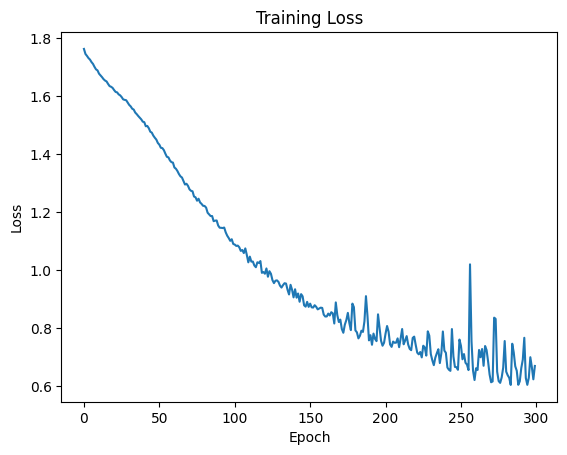

In [ ]:
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

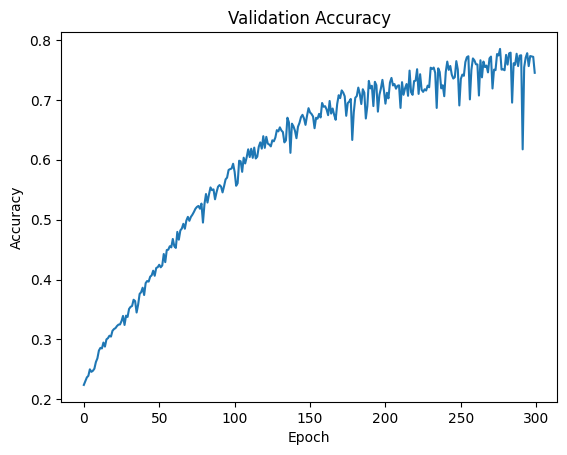

In [ ]:
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print(f"✅ Val Accuracy: {val_acc:.4f}")
for cls, acc in val_per_class.items():
    print(f"  Class {cls} Accuracy: {acc:.2%}")

✅ Val Accuracy: 0.7451
  Class 0 Accuracy: 86.28%
  Class 1 Accuracy: 72.38%
  Class 2 Accuracy: 65.44%
  Class 3 Accuracy: 68.53%
  Class 4 Accuracy: 72.91%
  Class 5 Accuracy: 82.39%


In [ ]:
torch.save(model.state_dict(), os.path.join(BASE_PATH, "CNNLSTM_NP_T16_H90s_baseline.pth"))

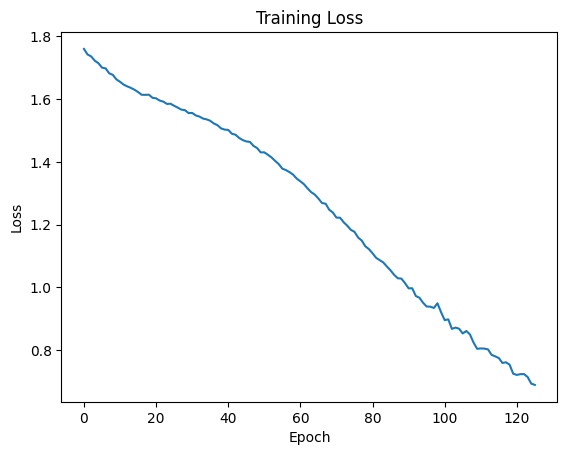

In [ ]:
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

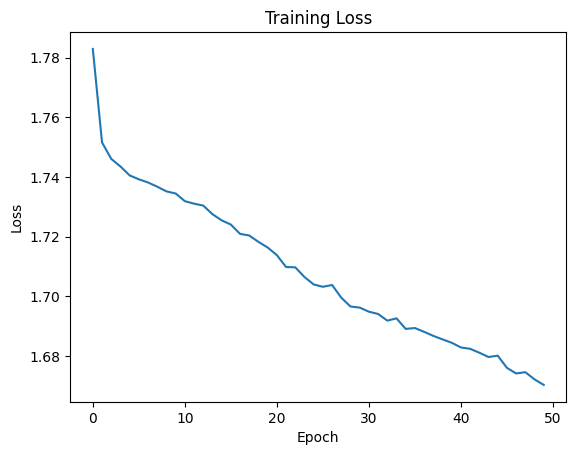

In [ ]:
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()